In the following notebook, i will be focusing on the data handling of the database, which means, i will be cleaning, showcasing and analysing the diffrent parameters before we tsrt training and testing.

We will focus on the extraction of statistics and scores, to conclude on the full time result, so it will use the most import parameters for a footballgame.


In [1]:
#We will start by loading our database into the file, so we can access the data easily

In [27]:
import sqlite3
import requests
import json
import time
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd

# Configuration
API_TOKEN = "PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1"
CORE_BASE_URL = "https://api.sportmonks.com/v3/core"
FOOTBALL_BASE_URL = "https://api.sportmonks.com/v3/football"
DB_PATH = "db_sportmonks.db"

# Rate limiting configuration
REQUESTS_PER_SECOND = 10
TIME_BETWEEN_REQUESTS = 1.0 / REQUESTS_PER_SECOND

# Global rate limiter
last_request_time = time.time()

def rate_limited_request():
    """Simple rate limiter to avoid hitting API limits"""
    global last_request_time
    current_time = time.time()
    time_since_last_request = current_time - last_request_time
    if time_since_last_request < TIME_BETWEEN_REQUESTS:
        time.sleep(TIME_BETWEEN_REQUESTS - time_since_last_request)
    last_request_time = time.time()

class SportMonksSync:
    def __init__(self):
        self.conn = sqlite3.connect(DB_PATH)
        self.session = requests.Session()
        self.session.headers.update({'Accept': 'application/json'})
        
    def close(self):
        """Clean up resources"""
        self.conn.close()
        self.session.close()
    
    def make_request(self, url, params=None):
        """Make an API request with rate limiting"""
        rate_limited_request()
        
        if params is None:
            params = {}
        params['api_token'] = API_TOKEN
        
        response = self.session.get(url, params=params)
        response.raise_for_status()
        return response.json()
    
    def get_latest_timestamp(self, table_name, timestamp_column='updated_at'):
        """Get the latest timestamp from a table"""
        try:
            query = f"SELECT MAX({timestamp_column}) FROM {table_name}"
            result = self.conn.execute(query).fetchone()
            return result[0] if result and result[0] else None
        except sqlite3.OperationalError:
            return None
    
    def sync_continents(self):
        """Sync continents data"""
        print("Syncing continents...")
        url = f"{CORE_BASE_URL}/continents"
        data = self.make_request(url)
        
        count = 0
        for continent in data.get('data', []):
            self.conn.execute("""
                INSERT OR REPLACE INTO continents (id, name, updated_at, raw)
                VALUES (?, ?, ?, ?)
            """, (
                continent['id'],
                continent['name'],
                datetime.now().isoformat(),
                json.dumps(continent)
            ))
            count += 1
        
        self.conn.commit()
        print(f"Updated {count} continents")
    
    def sync_countries(self):
        """Sync countries data"""
        print("Syncing countries...")
        
        page = 1
        total_updated = 0
        
        while True:
            url = f"{CORE_BASE_URL}/countries"
            params = {'page': page, 'per_page': 1000}
            
            data = self.make_request(url, params)
            countries = data.get('data', [])
            
            if not countries:
                break
            
            for country in countries:
                self.conn.execute("""
                    INSERT OR REPLACE INTO countries (id, continent_id, name, iso2, updated_at, raw)
                    VALUES (?, ?, ?, ?, ?, ?)
                """, (
                    country['id'],
                    country.get('continent_id'),
                    country['name'],
                    country.get('code'),  # or 'iso2' depending on API response
                    datetime.now().isoformat(),
                    json.dumps(country)
                ))
                total_updated += 1
            
            self.conn.commit()
            
            pagination = data.get('pagination', {})
            if not pagination.get('has_more', False):
                break
                
            page += 1
        
        print(f"Updated {total_updated} countries")
    
    def sync_leagues(self):
        """Sync leagues data"""
        print("Syncing leagues...")
        latest_update = self.get_latest_timestamp('leagues')
        
        page = 1
        total_updated = 0
        
        while True:
            url = f"{FOOTBALL_BASE_URL}/leagues"
            params = {'page': page, 'per_page': 1000}
            
            if latest_update:
                params['updated_after'] = latest_update
            
            data = self.make_request(url, params)
            leagues = data.get('data', [])
            
            if not leagues:
                break
            
            for league in leagues:
                self.conn.execute("""
                    INSERT OR REPLACE INTO leagues (id, name, country_id, type, logo_path, updated_at, raw)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (
                    league['id'],
                    league['name'],
                    league.get('country_id'),
                    league.get('type'),
                    league.get('logo_path'),
                    datetime.now().isoformat(),
                    json.dumps(league)
                ))
                total_updated += 1
            
            self.conn.commit()
            
            pagination = data.get('pagination', {})
            if not pagination.get('has_more', False):
                break
                
            page += 1
        
        print(f"Updated {total_updated} leagues")
    
    def sync_seasons(self):
        """Sync seasons data"""
        print("Syncing seasons...")
        latest_update = self.get_latest_timestamp('seasons')
        
        page = 1
        total_updated = 0
        
        while True:
            url = f"{FOOTBALL_BASE_URL}/seasons"
            params = {'page': page, 'per_page': 1000}
            
            if latest_update:
                params['updated_after'] = latest_update
            
            data = self.make_request(url, params)
            seasons = data.get('data', [])
            
            if not seasons:
                break
            
            for season in seasons:
                self.conn.execute("""
                    INSERT OR REPLACE INTO seasons (id, league_id, name, start_date, end_date, updated_at, raw)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (
                    season['id'],
                    season.get('league_id'),
                    season['name'],
                    season.get('starting_at'),
                    season.get('ending_at'),
                    datetime.now().isoformat(),
                    json.dumps(season)
                ))
                total_updated += 1
            
            self.conn.commit()
            
            pagination = data.get('pagination', {})
            if not pagination.get('has_more', False):
                break
                
            page += 1
        
        print(f"Updated {total_updated} seasons")
    
    def sync_teams(self):
        """Sync teams data"""
        print("Syncing teams...")
        latest_update = self.get_latest_timestamp('teams')
        
        page = 1
        total_updated = 0
        
        while True:
            url = f"{FOOTBALL_BASE_URL}/teams"
            params = {'page': page, 'per_page': 1000}
            
            if latest_update:
                params['updated_after'] = latest_update
            
            data = self.make_request(url, params)
            teams = data.get('data', [])
            
            if not teams:
                break
            
            for team in teams:
                self.conn.execute("""
                    INSERT OR REPLACE INTO teams (id, name, country_id, venue_id, coach_id, founded, logo_path, updated_at, raw)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (
                    team['id'],
                    team['name'],
                    team.get('country_id'),
                    team.get('venue_id'),
                    team.get('coach_id'),
                    team.get('founded'),
                    team.get('logo_path'),
                    datetime.now().isoformat(),
                    json.dumps(team)
                ))
                total_updated += 1
            
            self.conn.commit()
            
            pagination = data.get('pagination', {})
            if not pagination.get('has_more', False):
                break
                
            page += 1
        
        print(f"Updated {total_updated} teams")
    
    def sync_fixtures(self, days_back=7, days_forward=30):
        """Sync fixtures data for a specific date range"""
        print(f"Syncing fixtures ({days_back} days back, {days_forward} days forward)...")
        
        start_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
        end_date = (datetime.now() + timedelta(days=days_forward)).strftime('%Y-%m-%d')
        
        print(f"Date range: {start_date} to {end_date}")
        
        current_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_datetime = datetime.strptime(end_date, '%Y-%m-%d')
        
        total_updated = 0
        
        while current_date <= end_datetime:
            date_str = current_date.strftime('%Y-%m-%d')
            print(f"Fetching fixtures for {date_str}")
            
            url = f"{FOOTBALL_BASE_URL}/fixtures/date/{date_str}"
            params = {
                'include': 'scores;participants'
            }
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    # Extract team IDs
                    home_team_id = None
                    away_team_id = None
                    
                    for participant in fixture.get('participants', []):
                        if participant.get('meta', {}).get('location') == 'home':
                            home_team_id = participant.get('id')
                        elif participant.get('meta', {}).get('location') == 'away':
                            away_team_id = participant.get('id')
                    
                    # Extract scores
                    home_score = None
                    away_score = None
                    
                    for score in fixture.get('scores', []):
                        score_info = score.get('score', {})
                        if score.get('description') == 'CURRENT':
                            participant = score.get('score', {}).get('participant')
                            if participant == 'home':
                                home_score = score_info.get('goals')
                            elif participant == 'away':
                                away_score = score_info.get('goals')
                    
                    self.conn.execute("""
                        INSERT OR REPLACE INTO fixtures (
                            id, league_id, season_id, home_team_id, away_team_id,
                            venue_id, referee_id, starting_at, status,
                            score_home, score_away, updated_at, raw
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    """, (
                        fixture['id'],
                        fixture.get('league_id'),
                        fixture.get('season_id'),
                        home_team_id,
                        away_team_id,
                        fixture.get('venue_id'),
                        fixture.get('referee_id'),
                        fixture.get('starting_at'),
                        fixture.get('state', {}).get('state', fixture.get('status')),
                        home_score,
                        away_score,
                        datetime.now().isoformat(),
                        json.dumps(fixture)
                    ))
                    total_updated += 1
                
                self.conn.commit()
                print(f"Updated {len(fixtures)} fixtures for {date_str}")
                
            except Exception as e:
                print(f"Error fetching fixtures for {date_str}: {e}")
            
            current_date += timedelta(days=1)
        
        print(f"Updated {total_updated} fixtures in total")
    
    def sync_players(self, limit=None):
        """Sync players data"""
        print("Syncing players...")
        latest_update = self.get_latest_timestamp('players')
        
        page = 1
        total_updated = 0
        
        while True:
            if limit and total_updated >= limit:
                break
                
            url = f"{FOOTBALL_BASE_URL}/players"
            params = {'page': page, 'per_page': 1000}
            
            if latest_update:
                params['updated_after'] = latest_update
            
            data = self.make_request(url, params)
            players = data.get('data', [])
            
            if not players:
                break
            
            for player in players:
                self.conn.execute("""
                    INSERT OR REPLACE INTO players (
                        id, common_name, firstname, lastname, position, 
                        nationality, birthdate, height, weight, updated_at, raw
                    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (
                    player['id'],
                    player.get('common_name') or player.get('display_name'),
                    player.get('firstname'),
                    player.get('lastname'),
                    player.get('position'),
                    player.get('nationality'),
                    player.get('date_of_birth'),
                    player.get('height'),
                    player.get('weight'),
                    datetime.now().isoformat(),
                    json.dumps(player)
                ))
                total_updated += 1
            
            self.conn.commit()
            
            pagination = data.get('pagination', {})
            if not pagination.get('has_more', False):
                break
                
            page += 1
        
        print(f"Updated {total_updated} players")
    
    def sync_all(self, include_heavy=False):
        """Sync all data"""
        print("Starting SportMonks database sync...")
        start_time = time.time()
        
        # Core data (usually doesn't change much)
        self.sync_continents()
        self.sync_countries()
        
        # Football data
        self.sync_leagues()
        self.sync_seasons()
        self.sync_teams()
        
        # Time-sensitive data
        self.sync_fixtures(days_back=60, days_forward=30)
        
        # Heavy data (optional)
        if include_heavy:
            self.sync_players(limit=5000)  # Limit to avoid hitting API limits
        
        end_time = time.time()
        print(f"Sync completed in {end_time - start_time:.2f} seconds")
    
    def get_summary(self):
        """Get a summary of the current database state"""
        tables = ['continents', 'countries', 'leagues', 'seasons', 'teams', 'fixtures', 'players']
        
        summary = []
        for table in tables:
            try:
                count = self.conn.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
                latest = self.get_latest_timestamp(table)
                summary.append({
                    'table': table,
                    'count': count,
                    'latest_update': latest
                })
            except sqlite3.OperationalError:
                summary.append({
                    'table': table,
                    'count': 0,
                    'latest_update': None
                })
        
        return pd.DataFrame(summary)

# Main execution
if __name__ == "__main__":
    syncer = SportMonksSync()
    
    try:
        # Show current state before sync
        print("Before sync:")
        print(syncer.get_summary())
        print("\n")
        
        # Perform sync
        syncer.sync_all(include_heavy=False)
        
        # Show state after sync
        print("\nAfter sync:")
        print(syncer.get_summary())
        
    finally:
        syncer.close()

# Usage in Jupyter Notebook:
# syncer = SportMonksSync()
# 
# # For daily updates - just fixtures and key data
# syncer.sync_fixtures(days_back=7, days_forward=30)
# 
# # For weekly updates - include more data
# syncer.sync_all(include_heavy=False)
# 
# # For monthly updates - include all data
# syncer.sync_all(include_heavy=True)
# 
# syncer.close()

Before sync:
        table   count               latest_update
0  continents       7  2025-05-11T11:08:08.576071
1   countries     242  2025-05-11T11:08:09.586010
2     leagues      27  2025-05-11T11:08:09.794586
3     seasons     531  2025-05-11T11:08:12.061124
4       teams    2508  2025-05-11T11:08:23.124908
5    fixtures  155548  2025-05-11T11:08:30.321386
6     players   75765  2025-05-11T11:08:27.330715


Starting SportMonks database sync...
Syncing continents...
Updated 7 continents
Syncing countries...
Updated 242 countries
Syncing leagues...
Updated 27 leagues
Syncing seasons...
Updated 531 seasons
Syncing teams...
Updated 2508 teams
Syncing fixtures (60 days back, 30 days forward)...
Date range: 2025-03-15 to 2025-06-13
Fetching fixtures for 2025-03-15
Updated 25 fixtures for 2025-03-15
Fetching fixtures for 2025-03-16
Updated 25 fixtures for 2025-03-16
Fetching fixtures for 2025-03-17
Updated 1 fixtures for 2025-03-17
Fetching fixtures for 2025-03-18
Updated 0 fixtures for 2

The script above should update the database with the seasons, teams, fixtures and players. We should also make it so i updates the stats etc.

The code below here should update the following:

Events - Goals, cards, substitutions, etc.
Lineups - Starting lineups and substitutes
Statistics - Match statistics for teams
Odds - Betting odds from bookmakers
Standings - League tables
Top Scorers - Goal scorers rankings
Bookmakers - Betting companies
Markets - Betting markets

In [28]:
# Additional sync functions for all tables in the database

class CompleteSportMonksSync(SportMonksSync):
    """Extended sync class that updates all tables in the database"""
    
    def sync_events(self, fixture_ids=None, days_back=7):
        """Sync events data for fixtures"""
        print("Syncing events...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking events for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process in batches
        batch_size = 20
        for i in range(0, len(fixture_ids), batch_size):
            batch_ids = fixture_ids[i:i+batch_size]
            
            # Use multi-fixtures endpoint
            ids_str = ','.join(map(str, batch_ids))
            url = f"{FOOTBALL_BASE_URL}/fixtures/multi/{ids_str}"
            params = {'include': 'events'}
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    fixture_id = fixture['id']
                    events = fixture.get('events', [])
                    
                    for event in events:
                        # Extract player_name if available
                        player_info = event.get('player', {})
                        player_name = player_info.get('name') if isinstance(player_info, dict) else None
                        
                        self.conn.execute("""
                            INSERT OR REPLACE INTO events (
                                id, fixture_id, team_id, player_id, 
                                type, minute, extra_minute, updated_at, raw
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                        """, (
                            event['id'],
                            fixture_id,
                            event.get('participant_id'),  # This is team_id in v3
                            event.get('player_id'),
                            event.get('type', {}).get('name') if isinstance(event.get('type'), dict) else event.get('type'),
                            event.get('minute'),
                            event.get('extra_minute'),
                            datetime.now().isoformat(),
                            json.dumps(event)
                        ))
                        total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching events for batch: {e}")
        
        print(f"Updated {total_updated} events")
    
    def sync_lineups(self, fixture_ids=None, days_back=7):
        """Sync lineups data for fixtures"""
        print("Syncing lineups...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking lineups for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process in batches
        batch_size = 20
        for i in range(0, len(fixture_ids), batch_size):
            batch_ids = fixture_ids[i:i+batch_size]
            
            # Use multi-fixtures endpoint
            ids_str = ','.join(map(str, batch_ids))
            url = f"{FOOTBALL_BASE_URL}/fixtures/multi/{ids_str}"
            params = {'include': 'lineups'}
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    fixture_id = fixture['id']
                    lineups = fixture.get('lineups', [])
                    
                    for lineup in lineups:
                        # Generate a unique ID for the lineup entry
                        lineup_id = f"{fixture_id}_{lineup.get('player_id')}_{lineup.get('team_id')}"
                        
                        self.conn.execute("""
                            INSERT OR REPLACE INTO lineups (
                                id, fixture_id, team_id, player_id, 
                                position, lineup_type, updated_at, raw
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                        """, (
                            lineup_id,
                            fixture_id,
                            lineup.get('team_id'),
                            lineup.get('player_id'),
                            lineup.get('formation_position') or lineup.get('position'),
                            'starting' if lineup.get('type', {}).get('code') == 'lineup' else 'substitute',
                            datetime.now().isoformat(),
                            json.dumps(lineup)
                        ))
                        total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching lineups for batch: {e}")
        
        print(f"Updated {total_updated} lineups")
    
    def sync_statistics(self, fixture_ids=None, days_back=7):
        """Sync statistics data for fixtures"""
        print("Syncing statistics...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking statistics for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process in batches
        batch_size = 20
        for i in range(0, len(fixture_ids), batch_size):
            batch_ids = fixture_ids[i:i+batch_size]
            
            # Use multi-fixtures endpoint
            ids_str = ','.join(map(str, batch_ids))
            url = f"{FOOTBALL_BASE_URL}/fixtures/multi/{ids_str}"
            params = {'include': 'statistics'}
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    fixture_id = fixture['id']
                    statistics = fixture.get('statistics', [])
                    
                    for stat in statistics:
                        # Generate a unique ID for the statistic
                        stat_id = f"{fixture_id}_{stat.get('team_id')}_{stat.get('type', {}).get('id', 'unknown')}"
                        
                        self.conn.execute("""
                            INSERT OR REPLACE INTO statistics (
                                id, fixture_id, team_id, type, value, updated_at, raw
                            ) VALUES (?, ?, ?, ?, ?, ?, ?)
                        """, (
                            stat_id,
                            fixture_id,
                            stat.get('team_id') or stat.get('participant_id'),
                            stat.get('type', {}).get('name') if isinstance(stat.get('type'), dict) else stat.get('type'),
                            str(stat.get('data', {}).get('value', '')) if isinstance(stat.get('data'), dict) else str(stat.get('value', '')),
                            datetime.now().isoformat(),
                            json.dumps(stat)
                        ))
                        total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching statistics for batch: {e}")
        
        print(f"Updated {total_updated} statistics")
    
    def sync_odds(self, fixture_ids=None, days_back=7):
        """Sync odds data for fixtures"""
        print("Syncing odds...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                AND starting_at <= date('now', '+30 days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking odds for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process fixtures one by one for odds
        for fixture_id in tqdm(fixture_ids, desc="Processing odds"):
            url = f"{FOOTBALL_BASE_URL}/fixtures/{fixture_id}"
            params = {'include': 'odds'}
            
            try:
                data = self.make_request(url, params)
                fixture = data.get('data', {})
                odds_data = fixture.get('odds', [])
                
                for odd in odds_data:
                    bookmaker_id = odd.get('bookmaker_id')
                    market_id = odd.get('market_id')
                    
                    self.conn.execute("""
                        INSERT OR REPLACE INTO odds (
                            id, fixture_id, bookmaker_id, market_id, 
                            label, odd_value, updated_at, raw
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                        """, (
                        odd.get('id'),
                        fixture_id,
                        bookmaker_id,
                        market_id,
                        odd.get('label'),
                        odd.get('value'),
                        datetime.now().isoformat(),
                        json.dumps(odd)
                    ))
                    total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching odds for fixture {fixture_id}: {e}")
        
        print(f"Updated {total_updated} odds")
    
    def sync_standings(self, season_ids=None):
        """Sync standings data for seasons"""
        print("Syncing standings...")
        
        if season_ids is None:
            # Get active seasons
            query = """
                SELECT id FROM seasons 
                WHERE start_date <= date('now') 
                AND end_date >= date('now')
            """
            cursor = self.conn.execute(query)
            season_ids = [row[0] for row in cursor.fetchall()]
        
        total_updated = 0
        
        for season_id in season_ids:
            url = f"{FOOTBALL_BASE_URL}/standings/seasons/{season_id}"
            
            try:
                data = self.make_request(url)
                standings = data.get('data', [])
                
                for standing in standings:
                    self.conn.execute("""
                        INSERT OR REPLACE INTO standings (
                            id, fixture_id, participant_id, league_id, 
                            season_id, stage_id, round_id, position, 
                            points, updated_at, raw
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    """, (
                        standing.get('id'),
                        standing.get('fixture_id'),
                        standing.get('participant_id'),
                        standing.get('league_id'),
                        season_id,
                        standing.get('stage_id'),
                        standing.get('round_id'),
                        standing.get('position'),
                        standing.get('points'),
                        datetime.now().isoformat(),
                        json.dumps(standing)
                    ))
                    total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching standings for season {season_id}: {e}")
        
        print(f"Updated {total_updated} standings")
    
    def sync_topscorers(self, season_ids=None):
        """Sync top scorers data for seasons"""
        print("Syncing top scorers...")
        
        if season_ids is None:
            # Get active seasons
            query = """
                SELECT id FROM seasons 
                WHERE start_date <= date('now') 
                AND end_date >= date('now')
            """
            cursor = self.conn.execute(query)
            season_ids = [row[0] for row in cursor.fetchall()]
        
        total_updated = 0
        
        for season_id in season_ids:
            url = f"{FOOTBALL_BASE_URL}/topscorers/seasons/{season_id}"
            
            try:
                data = self.make_request(url)
                topscorers = data.get('data', [])
                
                for scorer in topscorers:
                    self.conn.execute("""
                        INSERT OR REPLACE INTO top_scorers (
                            id, season_id, player_id, goals, assists, 
                            red_cards, yellow_cards, penalties_scored, 
                            penalties_missed, updated_at, raw
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    """, (
                        scorer.get('id'),
                        season_id,
                        scorer.get('player_id'),
                        scorer.get('goals'),
                        scorer.get('assists'),
                        scorer.get('red_cards'),
                        scorer.get('yellow_cards'),
                        scorer.get('penalties_scored'),
                        scorer.get('penalties_missed'),
                        datetime.now().isoformat(),
                        json.dumps(scorer)
                    ))
                    total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching top scorers for season {season_id}: {e}")
        
        print(f"Updated {total_updated} top scorers")
    
    def sync_bookmakers(self):
        """Sync bookmakers data"""
        print("Syncing bookmakers...")
        
        url = f"{FOOTBALL_BASE_URL}/bookmakers"
        total_updated = 0
        
        try:
            data = self.make_request(url)
            bookmakers = data.get('data', [])
            
            for bookmaker in bookmakers:
                self.conn.execute("""
                    INSERT OR REPLACE INTO bookmakers (
                        id, name, updated_at, raw
                    ) VALUES (?, ?, ?, ?)
                """, (
                    bookmaker.get('id'),
                    bookmaker.get('name'),
                    datetime.now().isoformat(),
                    json.dumps(bookmaker)
                ))
                total_updated += 1
            
            self.conn.commit()
            
        except Exception as e:
            print(f"Error fetching bookmakers: {e}")
        
        print(f"Updated {total_updated} bookmakers")
    
    def sync_markets(self):
        """Sync markets data"""
        print("Syncing markets...")
        
        url = f"{FOOTBALL_BASE_URL}/markets"
        total_updated = 0
        
        try:
            data = self.make_request(url)
            markets = data.get('data', [])
            
            for market in markets:
                self.conn.execute("""
                    INSERT OR REPLACE INTO markets (
                        id, bookmaker_id, name, key, updated_at, raw
                    ) VALUES (?, ?, ?, ?, ?, ?)
                """, (
                    market.get('id'),
                    market.get('bookmaker_id'),
                    market.get('name'),
                    market.get('key'),
                    datetime.now().isoformat(),
                    json.dumps(market)
                ))
                total_updated += 1
            
            self.conn.commit()
            
        except Exception as e:
            print(f"Error fetching markets: {e}")
        
        print(f"Updated {total_updated} markets")
    
    def sync_match_data(self, days_back=7):
        """Sync all match-related data for recent fixtures"""
        print(f"Syncing all match data for the past {days_back} days...")
        
        # Get recent fixture IDs
        query = """
            SELECT id FROM fixtures 
            WHERE starting_at >= date('now', '-{} days')
            ORDER BY starting_at DESC
        """.format(days_back)
        
        cursor = self.conn.execute(query)
        fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Found {len(fixture_ids)} fixtures to update")
        
        # Sync all match-related data
        self.sync_events(fixture_ids)
        self.sync_lineups(fixture_ids)
        self.sync_statistics(fixture_ids)
        self.sync_odds(fixture_ids)
    
    def sync_complete(self, days_back=7, days_forward=30):
        """Complete sync of all data"""
        print("Starting complete SportMonks database sync...")
        start_time = time.time()
        
        # Basic data
        self.sync_continents()
        self.sync_countries()
        self.sync_leagues()
        self.sync_seasons()
        self.sync_teams()
        self.sync_players(limit=1000)  # Limit to avoid API overload
        
        # Fixtures
        self.sync_fixtures(days_back=days_back, days_forward=days_forward)
        
        # Match data
        self.sync_match_data(days_back=days_back)
        
        # Season data
        self.sync_standings()
        self.sync_topscorers()
        
        # Betting data
        self.sync_bookmakers()
        self.sync_markets()
        
        end_time = time.time()
        print(f"Complete sync finished in {end_time - start_time:.2f} seconds")
    
    def get_extended_summary(self):
        """Get a summary of all tables in the database"""
        tables = [
            'continents', 'countries', 'leagues', 'seasons', 'teams', 'fixtures', 'players',
            'events', 'lineups', 'statistics', 'odds', 'standings', 'top_scorers',
            'bookmakers', 'markets'
        ]
        
        summary = []
        for table in tables:
            try:
                count = self.conn.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
                latest = self.get_latest_timestamp(table)
                summary.append({
                    'table': table,
                    'count': count,
                    'latest_update': latest
                })
            except sqlite3.OperationalError:
                summary.append({
                    'table': table,
                    'count': 0,
                    'latest_update': None
                })
        
        return pd.DataFrame(summary)

# Usage example:
if __name__ == "__main__":
    syncer = CompleteSportMonksSync()
    
    try:
        # Show current state
        print("Database state before sync:")
        print(syncer.get_extended_summary())
        print("\n")
        
        # Perform complete sync
        syncer.sync_complete(days_back=7, days_forward=30)
        
        # Show state after sync
        print("\nDatabase state after sync:")
        print(syncer.get_extended_summary())
        
    finally:
        syncer.close()

# Daily usage in Jupyter:
# syncer = CompleteSportMonksSync()
# syncer.sync_match_data(days_back=7)  # Just update match data
# syncer.sync_standings()               # Update standings
# syncer.sync_topscorers()             # Update top scorers
# syncer.close()

Database state before sync:
          table    count               latest_update
0    continents        7  2025-05-14T12:27:22.439939
1     countries      242  2025-05-14T12:27:23.482061
2       leagues       27  2025-05-14T12:27:23.678417
3       seasons      531  2025-05-14T12:27:26.115450
4         teams     2508  2025-05-14T12:27:38.546489
5      fixtures   155549  2025-05-14T12:27:48.624711
6       players    75765  2025-05-11T11:08:27.330715
7        events  1775123  2025-05-11T11:08:36.260585
8       lineups  4387043  2025-05-11T11:17:13.210709
9    statistics   908928  2025-05-11T11:17:18.502984
10         odds   935882  2025-05-11T11:11:29.818544
11    standings      457  2025-05-11T11:11:32.433261
12  top_scorers      600  2025-05-11T11:11:34.990815
13   bookmakers        0                        None
14      markets        0                        None


Starting complete SportMonks database sync...
Syncing continents...
Updated 7 continents
Syncing countries...
Updated 242 

Processing odds: 100%|██████████| 873/873 [03:17<00:00,  4.43it/s]


Updated 1063008 odds
Syncing standings...
Updated 413 standings
Syncing top scorers...
Updated 575 top scorers
Syncing bookmakers...
Error fetching bookmakers: 404 Client Error: Not Found for url: https://api.sportmonks.com/v3/football/bookmakers?api_token=PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1
Updated 0 bookmakers
Syncing markets...
Error fetching markets: 404 Client Error: Not Found for url: https://api.sportmonks.com/v3/football/markets?api_token=PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1
Updated 0 markets
Complete sync finished in 242.55 seconds

Database state after sync:
          table    count               latest_update
0    continents        7  2025-05-14T12:28:10.305652
1     countries      242  2025-05-14T12:28:11.453577
2       leagues       27  2025-05-14T12:28:11.668820
3       seasons      531  2025-05-14T12:28:14.059917
4         teams     2508  2025-05-14T12:28:26.260692
5      fixtures   155549  2025-05-14T12:28:33.694377
6    

In [8]:
# Check the statistics table structure
conn = sqlite3.connect(DB_PATH)
cursor = conn.execute("PRAGMA table_info(lineups)")
for row in cursor.fetchall():
    print(row)
conn.close()

(0, 'id', 'INTEGER', 0, None, 1)
(1, 'fixture_id', 'INTEGER', 0, None, 0)
(2, 'team_id', 'INTEGER', 0, None, 0)
(3, 'player_id', 'INTEGER', 0, None, 0)
(4, 'position', 'TEXT', 0, None, 0)
(5, 'lineup_type', 'TEXT', 0, None, 0)
(6, 'updated_at', 'TEXT', 0, None, 0)
(7, 'raw', 'TEXT', 0, None, 0)


In [9]:
class CompleteSportMonksSync(SportMonksSync):
    """Extended sync class that updates all tables in the database"""
    
    def sync_lineups(self, fixture_ids=None, days_back=7):
        """Sync lineups data for fixtures"""
        print("Syncing lineups...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking lineups for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process in batches
        batch_size = 20
        for i in range(0, len(fixture_ids), batch_size):
            batch_ids = fixture_ids[i:i+batch_size]
            
            # Use multi-fixtures endpoint
            ids_str = ','.join(map(str, batch_ids))
            url = f"{FOOTBALL_BASE_URL}/fixtures/multi/{ids_str}"
            params = {'include': 'lineups'}
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    fixture_id = fixture['id']
                    lineups = fixture.get('lineups', [])
                    
                    for lineup in lineups:
                        # Generate a unique INTEGER ID for the lineup entry
                        player_id = lineup.get('player_id', 0)
                        team_id = lineup.get('team_id', 0)
                        lineup_id = abs(hash(f"{fixture_id}_{player_id}_{team_id}")) % (2**31)
                        
                        # Determine lineup type
                        lineup_type = lineup.get('type')
                        if isinstance(lineup_type, dict):
                            type_code = lineup_type.get('code', '')
                            lineup_type_str = 'starting' if type_code == 'lineup' else 'substitute'
                        else:
                            lineup_type_str = 'substitute'
                        
                        self.conn.execute("""
                            INSERT OR REPLACE INTO lineups (
                                id, fixture_id, team_id, player_id, 
                                position, lineup_type, updated_at, raw
                            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                        """, (
                            lineup_id,
                            fixture_id,
                            team_id,
                            player_id,
                            lineup.get('formation_position') or lineup.get('position') or '',
                            lineup_type_str,
                            datetime.now().isoformat(),
                            json.dumps(lineup)
                        ))
                        total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching lineups for batch: {e}")
                if 'lineup' in locals():
                    print(f"Last lineup data: {lineup}")
        
        print(f"Updated {total_updated} lineups")
    
    def sync_statistics(self, fixture_ids=None, days_back=7):
        """Sync statistics data for fixtures"""
        print("Syncing statistics...")
        
        if fixture_ids is None:
            # Get recent fixtures
            query = """
                SELECT id FROM fixtures 
                WHERE starting_at >= date('now', '-{} days')
                ORDER BY starting_at DESC
            """.format(days_back)
            
            cursor = self.conn.execute(query)
            fixture_ids = [row[0] for row in cursor.fetchall()]
        
        print(f"Checking statistics for {len(fixture_ids)} fixtures")
        total_updated = 0
        
        # Process in batches
        batch_size = 20
        for i in range(0, len(fixture_ids), batch_size):
            batch_ids = fixture_ids[i:i+batch_size]
            
            # Use multi-fixtures endpoint
            ids_str = ','.join(map(str, batch_ids))
            url = f"{FOOTBALL_BASE_URL}/fixtures/multi/{ids_str}"
            params = {'include': 'statistics'}
            
            try:
                data = self.make_request(url, params)
                fixtures = data.get('data', [])
                
                for fixture in fixtures:
                    fixture_id = fixture['id']
                    statistics = fixture.get('statistics', [])
                    
                    for stat in statistics:
                        # Generate a unique INTEGER ID for the statistic
                        team_id = stat.get('team_id') or stat.get('participant_id', 0)
                        type_id = stat.get('type', {}).get('id', 0) if isinstance(stat.get('type'), dict) else 0
                        stat_id = abs(hash(f"{fixture_id}_{team_id}_{type_id}")) % (2**31)
                        
                        # Handle type field which might be a dict or string
                        stat_type = stat.get('type')
                        if isinstance(stat_type, dict):
                            type_name = stat_type.get('name', '')
                        else:
                            type_name = str(stat_type) if stat_type else ''
                        
                        # Handle value field which might be nested
                        value = stat.get('value')
                        if value is None and isinstance(stat.get('data'), dict):
                            value = stat.get('data', {}).get('value')
                        
                        # Convert value to string, handling None
                        value_str = str(value) if value is not None else ''
                        
                        self.conn.execute("""
                            INSERT OR REPLACE INTO statistics (
                                id, fixture_id, team_id, type, value, updated_at, raw
                            ) VALUES (?, ?, ?, ?, ?, ?, ?)
                        """, (
                            stat_id,
                            fixture_id,
                            team_id,
                            type_name,
                            value_str,
                            datetime.now().isoformat(),
                            json.dumps(stat)
                        ))
                        total_updated += 1
                
                self.conn.commit()
                
            except Exception as e:
                print(f"Error fetching statistics for batch: {e}")
                if 'stat' in locals():
                    print(f"Last stat data: {stat}")
        
        print(f"Updated {total_updated} statistics")

In [10]:
# Focused sync for lineups and statistics with fixed data types
syncer = CompleteSportMonksSync()

try:
    print("Updating lineups and statistics...")
    
    # Get fixture IDs for the past X days
    days_back = 7
    query = """
        SELECT id FROM fixtures 
        WHERE starting_at >= date('now', '-{} days')
        ORDER BY starting_at DESC
    """.format(days_back)
    
    cursor = syncer.conn.execute(query)
    fixture_ids = [row[0] for row in cursor.fetchall()]
    
    print(f"Found {len(fixture_ids)} fixtures to update from the past {days_back} days")
    
    # Sync lineups
    syncer.sync_lineups(fixture_ids=fixture_ids)
    
    # Sync statistics  
    syncer.sync_statistics(fixture_ids=fixture_ids)
    
    # Show updated counts
    lineups_count = syncer.conn.execute("SELECT COUNT(*) FROM lineups").fetchone()[0]
    lineups_latest = syncer.get_latest_timestamp('lineups')
    stats_count = syncer.conn.execute("SELECT COUNT(*) FROM statistics").fetchone()[0]
    stats_latest = syncer.get_latest_timestamp('statistics')
    
    print(f"\nLineups: {lineups_count} records, last updated: {lineups_latest}")
    print(f"Statistics: {stats_count} records, last updated: {stats_latest}")
    
finally:
    syncer.close()

Updating lineups and statistics...
Found 954 fixtures to update from the past 7 days
Syncing lineups...
Checking lineups for 954 fixtures
Updated 9523 lineups
Syncing statistics...
Checking statistics for 954 fixtures
Updated 2222 statistics

Lineups: 4387043 records, last updated: 2025-05-11T11:17:13.210709
Statistics: 908928 records, last updated: 2025-05-11T11:17:18.502984


In [11]:
# Check events table for penalties and cards
conn = sqlite3.connect(DB_PATH)

# Check events table structure
print("Events table structure:")
cursor = conn.execute("PRAGMA table_info(events)")
for row in cursor.fetchall():
    print(row)

# Check for penalty and card events
print("\nChecking for penalty and card events...")

# Count penalty events (type IDs from your code: 16, 17)
penalty_count = conn.execute("""
    SELECT COUNT(*) FROM events 
    WHERE type IN ('penalty', 'missed_penalty', 'penalty_scored', 'penalty_missed')
    OR raw LIKE '%"type_id":16%' OR raw LIKE '%"type_id":17%'
""").fetchone()[0]

# Count card events (type IDs from your code: 19, 20, 21)
card_count = conn.execute("""
    SELECT COUNT(*) FROM events 
    WHERE type IN ('yellow_card', 'red_card', 'yellowred_card')
    OR raw LIKE '%"type_id":19%' OR raw LIKE '%"type_id":20%' OR raw LIKE '%"type_id":21%'
""").fetchone()[0]

print(f"Penalty events: {penalty_count}")
print(f"Card events: {card_count}")

# Show latest update
latest_update = conn.execute("SELECT MAX(updated_at) FROM events").fetchone()[0]
print(f"Events last updated: {latest_update}")

conn.close()

Events table structure:
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'fixture_id', 'INTEGER', 0, None, 0)
(2, 'team_id', 'INTEGER', 0, None, 0)
(3, 'player_id', 'INTEGER', 0, None, 0)
(4, 'type', 'TEXT', 0, None, 0)
(5, 'minute', 'INTEGER', 0, None, 0)
(6, 'extra_minute', 'INTEGER', 0, None, 0)
(7, 'updated_at', 'TEXT', 0, None, 0)
(8, 'raw', 'TEXT', 0, None, 0)

Checking for penalty and card events...
Penalty events: 0
Card events: 0
Events last updated: 2025-05-11T11:08:36.260585


In [12]:
# Check what event types exist in the events table
conn = sqlite3.connect(DB_PATH)

# Get all unique event types
cursor = conn.execute("""
    SELECT DISTINCT type, COUNT(*) as count 
    FROM events 
    GROUP BY type 
    ORDER BY count DESC
    LIMIT 20
""")

print("Event types in database:")
for event_type, count in cursor.fetchall():
    print(f"  {event_type}: {count}")

# Let's also check a sample of raw data to see the structure
print("\nSample events with their raw data:")
cursor = conn.execute("""
    SELECT type, raw 
    FROM events 
    LIMIT 5
""")

for event_type, raw_data in cursor.fetchall():
    print(f"\nType: {event_type}")
    print(f"Raw: {raw_data[:200]}...")  # First 200 chars of raw data

conn.close()

Event types in database:
  None: 1775123

Sample events with their raw data:

Type: None
Raw: {"id": 2058, "fixture_id": 16864534, "period_id": 3723876, "participant_id": 7684, "type_id": 14, "section": "event", "player_id": 3568422, "related_player_id": 74925, "player_name": "Ivan Delic", "re...

Type: None
Raw: {"id": 2063, "fixture_id": 16864534, "period_id": 3723876, "participant_id": 5428, "type_id": 14, "section": "event", "player_id": 133314, "related_player_id": null, "player_name": "Moutir Chajia", "r...

Type: None
Raw: {"id": 2184, "fixture_id": 16864534, "period_id": 3723876, "participant_id": 5428, "type_id": 19, "section": "event", "player_id": 36097685, "related_player_id": null, "player_name": "Indrit Tuci", "r...

Type: None
Raw: {"id": 2194, "fixture_id": 16864534, "period_id": 456659, "participant_id": 7684, "type_id": 19, "section": "event", "player_id": 73633, "related_player_id": null, "player_name": "M. Seni\u0107", "rel...

Type: None
Raw: {"id": 2197, "fixture_

In [13]:
# Check for penalties and cards using type_id in raw JSON
conn = sqlite3.connect(DB_PATH)

# Extract and count type_ids from raw JSON
cursor = conn.execute("""
    SELECT 
        json_extract(raw, '$.type_id') as type_id,
        COUNT(*) as count
    FROM events
    GROUP BY type_id
    ORDER BY count DESC
""")

print("Event type IDs and their counts:")
for type_id, count in cursor.fetchall():
    print(f"  Type ID {type_id}: {count}")

# Now specifically check for penalties and cards
# Based on your original code:
# Penalties: 16 (scored), 17 (missed)
# Cards: 19 (yellow), 20 (red), 21 (yellow->red)

penalty_count = conn.execute("""
    SELECT COUNT(*) FROM events 
    WHERE json_extract(raw, '$.type_id') IN (16, 17)
""").fetchone()[0]

card_count = conn.execute("""
    SELECT COUNT(*) FROM events 
    WHERE json_extract(raw, '$.type_id') IN (19, 20, 21)
""").fetchone()[0]

print(f"\nPenalty events (type_id 16, 17): {penalty_count}")
print(f"Card events (type_id 19, 20, 21): {card_count}")

# Let's see some examples of each
print("\nSample penalty events:")
cursor = conn.execute("""
    SELECT fixture_id, player_id, minute, raw
    FROM events 
    WHERE json_extract(raw, '$.type_id') IN (16, 17)
    LIMIT 3
""")
for row in cursor.fetchall():
    print(f"Fixture {row[0]}, Player {row[1]}, Minute {row[2]}")

print("\nSample card events:")
cursor = conn.execute("""
    SELECT fixture_id, player_id, minute, json_extract(raw, '$.type_id') as type_id, json_extract(raw, '$.player_name') as player_name
    FROM events 
    WHERE json_extract(raw, '$.type_id') IN (19, 20, 21)
    LIMIT 5
""")
for row in cursor.fetchall():
    card_type = "Yellow" if row[3] == 19 else "Red" if row[3] == 20 else "Second Yellow"
    print(f"Fixture {row[0]}, {row[4]}, Minute {row[2]}: {card_type} card")

# Check when events were last updated
latest_update = conn.execute("SELECT MAX(updated_at) FROM events").fetchone()[0]
print(f"\nEvents last updated: {latest_update}")

conn.close()

Event type IDs and their counts:
  Type ID 18: 809165
  Type ID 19: 523113
  Type ID 14: 320903
  Type ID 126: 30959
  Type ID 16: 28916
  Type ID 20: 14844
  Type ID 21: 14302
  Type ID 10: 11378
  Type ID 15: 9338
  Type ID 17: 6827
  Type ID 23: 3476
  Type ID 22: 1205
  Type ID 1697: 590
  Type ID 570: 57
  Type ID 569: 43
  Type ID 568: 7

Penalty events (type_id 16, 17): 35743
Card events (type_id 19, 20, 21): 552259

Sample penalty events:
Fixture 16481468, Player 96611, Minute 37
Fixture 16481468, Player 510, Minute 84
Fixture 17056818, Player 186637, Minute 88

Sample card events:
Fixture 16864534, Indrit Tuci, Minute 45: Yellow card
Fixture 16864534, M. Senić, Minute 52: Yellow card
Fixture 16864534, O. Petrak, Minute 59: Yellow card
Fixture 16725144, Bartosz Kopacz, Minute 19: Yellow card
Fixture 16864534, Itsuki Urata, Minute 73: Yellow card

Events last updated: 2025-05-11T11:08:36.260585


In [14]:
# Data Quality Checks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sqlite3

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# 1.1 Check for missing values in key tables
print("=== DATA QUALITY CHECKS ===\n")

# Check fixtures data quality
print("1. FIXTURES DATA QUALITY")
fixtures_df = pd.read_sql("""
    SELECT 
        id, league_id, season_id, home_team_id, away_team_id,
        starting_at, status, score_home, score_away
    FROM fixtures
""", conn)

print(f"Total fixtures: {len(fixtures_df)}")
print("\nMissing values in fixtures:")
print(fixtures_df.isnull().sum())

# Check for invalid scores
invalid_scores = fixtures_df[
    ((fixtures_df['score_home'] < 0) | (fixtures_df['score_away'] < 0)) & 
    (fixtures_df['score_home'].notna() | fixtures_df['score_away'].notna())
]
print(f"\nInvalid scores (negative): {len(invalid_scores)}")

# Check for fixtures without teams
missing_teams = fixtures_df[
    fixtures_df['home_team_id'].isna() | fixtures_df['away_team_id'].isna()
]
print(f"Fixtures missing team IDs: {len(missing_teams)}")

# 1.2 Check data consistency
print("\n2. DATA CONSISTENCY CHECKS")

# Check if all teams in fixtures exist in teams table
query = """
    SELECT COUNT(DISTINCT f.home_team_id) as home_teams,
           COUNT(DISTINCT f.away_team_id) as away_teams,
           COUNT(DISTINCT t.id) as total_teams
    FROM fixtures f
    LEFT JOIN teams t ON f.home_team_id = t.id OR f.away_team_id = t.id
    WHERE f.home_team_id IS NOT NULL AND f.away_team_id IS NOT NULL
"""
consistency_check = pd.read_sql(query, conn)
print(consistency_check)

# 1.3 Check date ranges and gaps
print("\n3. DATE RANGE ANALYSIS")
fixtures_df['starting_at'] = pd.to_datetime(fixtures_df['starting_at'])
print(f"Earliest fixture: {fixtures_df['starting_at'].min()}")
print(f"Latest fixture: {fixtures_df['starting_at'].max()}")

# Check for date gaps by league
league_dates = fixtures_df.groupby('league_id')['starting_at'].agg(['min', 'max', 'count'])
print("\nFixtures by league (top 10 by count):")
print(league_dates.sort_values('count', ascending=False).head(10))

# 1.4 Check events data quality
print("\n4. EVENTS DATA QUALITY")
events_query = """
    SELECT 
        COUNT(*) as total_events,
        COUNT(DISTINCT fixture_id) as fixtures_with_events,
        COUNT(DISTINCT player_id) as unique_players,
        COUNT(CASE WHEN player_id IS NULL THEN 1 END) as events_without_player
    FROM events
"""
events_check = pd.read_sql(events_query, conn)
print(events_check)

# 1.5 Check lineup data quality
print("\n5. LINEUPS DATA QUALITY")
lineups_query = """
    SELECT 
        COUNT(*) as total_lineups,
        COUNT(DISTINCT fixture_id) as fixtures_with_lineups,
        COUNT(DISTINCT player_id) as unique_players,
        COUNT(CASE WHEN player_id IS NULL THEN 1 END) as lineups_without_player
    FROM lineups
"""
lineups_check = pd.read_sql(lineups_query, conn)
print(lineups_check)

# 1.6 Check statistics coverage
print("\n6. STATISTICS COVERAGE")
stats_query = """
    SELECT 
        COUNT(DISTINCT fixture_id) as fixtures_with_stats,
        COUNT(DISTINCT type) as stat_types,
        COUNT(*) as total_stats
    FROM statistics
"""
stats_check = pd.read_sql(stats_query, conn)
print(stats_check)

# Close connection
conn.close()

print("\n=== DATA QUALITY CHECK COMPLETE ===")

=== DATA QUALITY CHECKS ===

1. FIXTURES DATA QUALITY
Total fixtures: 155548

Missing values in fixtures:
id                   0
league_id            0
season_id            0
home_team_id    154540
away_team_id    154540
starting_at          0
status          155548
score_home        1217
score_away        1217
dtype: int64

Invalid scores (negative): 0
Fixtures missing team IDs: 154540

2. DATA CONSISTENCY CHECKS
   home_teams  away_teams  total_teams
0         347         357          375

3. DATE RANGE ANALYSIS
Earliest fixture: 2000-08-18 22:00:00
Latest fixture: 2025-11-30 16:00:00

Fixtures by league (top 10 by count):
                          min                 max  count
league_id                                               
24        2005-11-03 23:00:00 2025-05-17 15:30:00  13521
9         2005-08-05 22:00:00 2025-05-13 19:00:00  11137
8         2000-08-18 22:00:00 2025-05-25 15:00:00   9500
567       2005-08-26 22:00:00 2025-06-01 00:00:00   9303
387       2005-08-25 22:0

In [15]:
# Deeper investigation of the data issues
conn = sqlite3.connect('db_sportmonks.db')

print("=== INVESTIGATING DATA ISSUES ===\n")

# 1. Check a sample of fixtures to see the actual data structure
print("1. SAMPLE FIXTURES DATA:")
sample_fixtures = pd.read_sql("""
    SELECT id, league_id, season_id, home_team_id, away_team_id, 
           starting_at, status, score_home, score_away, raw
    FROM fixtures
    LIMIT 5
""", conn)
print(sample_fixtures)

# 2. Check if team data might be in the raw JSON
print("\n2. CHECKING RAW JSON STRUCTURE:")
raw_sample = pd.read_sql("""
    SELECT 
        id,
        json_extract(raw, '$.home_team_id') as json_home_team,
        json_extract(raw, '$.away_team_id') as json_away_team,
        json_extract(raw, '$.participants') as participants,
        home_team_id,
        away_team_id
    FROM fixtures
    WHERE home_team_id IS NULL
    LIMIT 5
""", conn)
print(raw_sample)

# 3. Check how many fixtures have participant data
print("\n3. FIXTURES WITH PARTICIPANTS IN JSON:")
participants_check = pd.read_sql("""
    SELECT 
        COUNT(*) as total_fixtures,
        COUNT(CASE WHEN json_extract(raw, '$.participants') IS NOT NULL THEN 1 END) as with_participants
    FROM fixtures
""", conn)
print(participants_check)

# 4. Check fixtures that DO have team IDs - when are they from?
print("\n4. FIXTURES WITH TEAM IDS - DATE RANGE:")
with_teams = pd.read_sql("""
    SELECT 
        COUNT(*) as count,
        MIN(starting_at) as earliest,
        MAX(starting_at) as latest
    FROM fixtures
    WHERE home_team_id IS NOT NULL AND away_team_id IS NOT NULL
""", conn)
print(with_teams)

# 5. Check the participant structure in raw JSON
print("\n5. SAMPLE PARTICIPANT DATA:")
participant_sample = pd.read_sql("""
    SELECT 
        id,
        json_extract(raw, '$.participants[0]') as participant_1,
        json_extract(raw, '$.participants[1]') as participant_2
    FROM fixtures
    WHERE json_extract(raw, '$.participants') IS NOT NULL
    LIMIT 3
""", conn)
for idx, row in participant_sample.iterrows():
    print(f"\nFixture {row['id']}:")
    print(f"Participant 1: {row['participant_1'][:200]}...")
    print(f"Participant 2: {row['participant_2'][:200]}...")

conn.close()

=== INVESTIGATING DATA ISSUES ===

1. SAMPLE FIXTURES DATA:
    id  league_id  season_id home_team_id away_team_id          starting_at  \
0  463          8          2         None         None  2010-08-14 11:45:00   
1  464          8          3         None         None  2013-08-17 11:45:00   
2  465          8          2         None         None  2010-08-14 14:00:00   
3  466          8          3         None         None  2013-08-17 14:00:00   
4  467          8          2         None         None  2010-08-14 14:00:00   

  status  score_home  score_away  \
0   None           0           0   
1   None           1           0   
2   None           3           0   
3   None           1           3   
4   None           1           0   

                                                 raw  
0  {"id": 463, "sport_id": 1, "league_id": 8, "se...  
1  {"id": 464, "sport_id": 1, "league_id": 8, "se...  
2  {"id": 465, "sport_id": 1, "league_id": 8, "se...  
3  {"id": 466, "sport_id": 1

In [16]:
# Fix the team data issue by extracting from participants JSON
conn = sqlite3.connect('db_sportmonks.db')

print("=== FIXING TEAM DATA ===\n")

# 1. First, let's update fixtures with participant data
print("1. Updating fixtures with team data from participants JSON...")

# Update fixtures that have participants data
update_query = """
UPDATE fixtures 
SET 
    home_team_id = json_extract(raw, '$.participants[0].id'),
    away_team_id = json_extract(raw, '$.participants[1].id')
WHERE 
    json_extract(raw, '$.participants') IS NOT NULL
    AND home_team_id IS NULL
    AND away_team_id IS NULL
"""

conn.execute(update_query)
conn.commit()

# 2. Check the results
check_query = """
SELECT 
    COUNT(*) as total_fixtures,
    COUNT(CASE WHEN home_team_id IS NOT NULL THEN 1 END) as fixtures_with_teams,
    COUNT(CASE WHEN json_extract(raw, '$.participants') IS NOT NULL THEN 1 END) as fixtures_with_participants
FROM fixtures
"""
result = pd.read_sql(check_query, conn)
print("\nAfter update:")
print(result)

# 3. For older fixtures, let's check if team info is stored differently
print("\n2. Checking older fixtures for team information...")

# Check if team names are in the raw data
old_fixtures_sample = pd.read_sql("""
    SELECT 
        id,
        json_extract(raw, '$.home_team') as home_team,
        json_extract(raw, '$.away_team') as away_team,
        json_extract(raw, '$.localteam_id') as localteam_id,
        json_extract(raw, '$.visitorteam_id') as visitorteam_id,
        starting_at
    FROM fixtures
    WHERE home_team_id IS NULL
    LIMIT 5
""", conn)
print(old_fixtures_sample)

# 4. Let's check the first few keys in the raw JSON for older fixtures
print("\n3. Structure of raw JSON for older fixtures:")
raw_keys_query = """
SELECT 
    id,
    json_extract(raw, '$.localteam_id') as localteam_id,
    json_extract(raw, '$.visitorteam_id') as visitorteam_id,
    starting_at
FROM fixtures
WHERE home_team_id IS NULL
AND json_extract(raw, '$.localteam_id') IS NOT NULL
LIMIT 5
"""
raw_keys = pd.read_sql(raw_keys_query, conn)
print(raw_keys)

# If localteam_id exists, let's update with that
if not raw_keys.empty and raw_keys['localteam_id'].notna().any():
    print("\n4. Updating older fixtures with localteam_id and visitorteam_id...")
    update_old_query = """
    UPDATE fixtures 
    SET 
        home_team_id = json_extract(raw, '$.localteam_id'),
        away_team_id = json_extract(raw, '$.visitorteam_id')
    WHERE 
        home_team_id IS NULL
        AND json_extract(raw, '$.localteam_id') IS NOT NULL
    """
    conn.execute(update_old_query)
    conn.commit()

# 5. Final check
final_check = pd.read_sql("""
    SELECT 
        COUNT(*) as total_fixtures,
        COUNT(CASE WHEN home_team_id IS NOT NULL THEN 1 END) as fixtures_with_teams,
        COUNT(CASE WHEN score_home IS NOT NULL THEN 1 END) as fixtures_with_scores
    FROM fixtures
""", conn)
print("\nFinal status:")
print(final_check)

# 6. Check date distribution of fixtures with and without teams
date_distribution = pd.read_sql("""
    SELECT 
        CASE 
            WHEN home_team_id IS NOT NULL THEN 'With Teams'
            ELSE 'Without Teams'
        END as status,
        MIN(starting_at) as earliest,
        MAX(starting_at) as latest,
        COUNT(*) as count
    FROM fixtures
    GROUP BY status
""", conn)
print("\nDate distribution:")
print(date_distribution)

conn.close()

print("\n=== TEAM DATA FIX COMPLETE ===")

=== FIXING TEAM DATA ===

1. Updating fixtures with team data from participants JSON...

After update:
   total_fixtures  fixtures_with_teams  fixtures_with_participants
0          155548                 1008                        1008

2. Checking older fixtures for team information...
    id home_team away_team localteam_id visitorteam_id          starting_at
0  463      None      None         None           None  2010-08-14 11:45:00
1  464      None      None         None           None  2013-08-17 11:45:00
2  465      None      None         None           None  2010-08-14 14:00:00
3  466      None      None         None           None  2013-08-17 14:00:00
4  467      None      None         None           None  2010-08-14 14:00:00

3. Structure of raw JSON for older fixtures:
Empty DataFrame
Columns: [id, localteam_id, visitorteam_id, starting_at]
Index: []

Final status:
   total_fixtures  fixtures_with_teams  fixtures_with_scores
0          155548                 1008            

In [17]:
# Let's examine the raw JSON structure more carefully
conn = sqlite3.connect('db_sportmonks.db')

print("=== DEEP INVESTIGATION OF RAW JSON STRUCTURE ===\n")

# 1. Get a sample of raw JSON to see all keys
print("1. Full raw JSON sample for fixtures WITH scores but WITHOUT teams:")
sample_with_scores = pd.read_sql("""
    SELECT 
        id,
        score_home,
        score_away,
        substr(raw, 1, 500) as raw_sample
    FROM fixtures
    WHERE score_home IS NOT NULL 
    AND home_team_id IS NULL
    LIMIT 3
""", conn)

for idx, row in sample_with_scores.iterrows():
    print(f"\nFixture {row['id']} (Score: {row['score_home']}-{row['score_away']}):")
    print(row['raw_sample'])

# 2. Let's parse the full JSON for one fixture to see all fields
print("\n2. Parsing full JSON structure:")
import json

raw_json = pd.read_sql("""
    SELECT raw
    FROM fixtures
    WHERE score_home IS NOT NULL 
    AND home_team_id IS NULL
    LIMIT 1
""", conn)

if not raw_json.empty:
    fixture_data = json.loads(raw_json.iloc[0]['raw'])
    print("JSON keys:", list(fixture_data.keys()))
    
    # Check for any team-related fields
    team_related_keys = [k for k in fixture_data.keys() if 'team' in k.lower() or 'participant' in k.lower()]
    print("Team-related keys:", team_related_keys)

# 3. Since we have scores but no teams, let's work with what we have
print("\n3. Summary of available data:")
data_summary = pd.read_sql("""
    SELECT 
        COUNT(*) as total_fixtures,
        COUNT(CASE WHEN score_home IS NOT NULL THEN 1 END) as with_scores,
        COUNT(CASE WHEN home_team_id IS NOT NULL THEN 1 END) as with_teams,
        COUNT(CASE WHEN league_id IS NOT NULL THEN 1 END) as with_league,
        COUNT(CASE WHEN season_id IS NOT NULL THEN 1 END) as with_season
    FROM fixtures
""", conn)
print(data_summary)

# 4. For visualizations, let's focus on the 1,008 fixtures with complete data
print("\n4. Complete data fixtures analysis:")
complete_data = pd.read_sql("""
    SELECT 
        league_id,
        COUNT(*) as fixture_count,
        MIN(starting_at) as earliest,
        MAX(starting_at) as latest
    FROM fixtures
    WHERE home_team_id IS NOT NULL
    GROUP BY league_id
    ORDER BY fixture_count DESC
""", conn)
print(complete_data)

conn.close()

print("\n=== INVESTIGATION COMPLETE ===")

=== DEEP INVESTIGATION OF RAW JSON STRUCTURE ===

1. Full raw JSON sample for fixtures WITH scores but WITHOUT teams:

Fixture 463 (Score: 0-0):
{"id": 463, "sport_id": 1, "league_id": 8, "season_id": 2, "stage_id": 2, "group_id": null, "aggregate_id": null, "round_id": 43, "state_id": 5, "venue_id": 209, "name": "Tottenham Hotspur vs Manchester City", "starting_at": "2010-08-14 11:45:00", "result_info": "Game ended in draw.", "leg": "1/1", "details": null, "length": 90, "placeholder": false, "has_odds": false, "has_premium_odds": false, "starting_at_timestamp": 1281786300}

Fixture 464 (Score: 1-0):
{"id": 464, "sport_id": 1, "league_id": 8, "season_id": 3, "stage_id": 3, "group_id": null, "aggregate_id": null, "round_id": 44, "state_id": 5, "venue_id": 230, "name": "Liverpool vs Stoke City", "starting_at": "2013-08-17 11:45:00", "result_info": "Liverpool won after full-time.", "leg": "1/1", "details": null, "length": 90, "placeholder": false, "has_odds": false, "has_premium_odds": fa

In [20]:
# Extract team names from the JSON 'name' field and match to team IDs
conn = sqlite3.connect('db_sportmonks.db')

print("=== EXTRACTING TEAM DATA FROM FIXTURE NAMES ===\n")

# 1. Extract team names from JSON
print("1. Extracting team names from JSON...")

# Create a table with extracted team names
conn.execute("DROP TABLE IF EXISTS fixture_team_names")
conn.execute("""
    CREATE TABLE fixture_team_names AS
    SELECT 
        id as fixture_id,
        json_extract(raw, '$.name') as fixture_name,
        TRIM(SUBSTR(json_extract(raw, '$.name'), 1, 
             INSTR(json_extract(raw, '$.name'), ' vs ') - 1)) as home_team_name,
        TRIM(SUBSTR(json_extract(raw, '$.name'), 
             INSTR(json_extract(raw, '$.name'), ' vs ') + 4)) as away_team_name,
        score_home,
        score_away
    FROM fixtures
    WHERE json_extract(raw, '$.name') LIKE '% vs %' 
    AND home_team_id IS NULL
""")

# Check extraction results
extraction_check = pd.read_sql("""
    SELECT * FROM fixture_team_names LIMIT 10
""", conn)
print("\nExtracted team names:")
print(extraction_check)

# 2. Get unique team names that need matching
print("\n2. Getting unique team names...")
unique_teams = pd.read_sql("""
    SELECT DISTINCT home_team_name as team_name FROM fixture_team_names
    UNION
    SELECT DISTINCT away_team_name as team_name FROM fixture_team_names
""", conn)
print(f"Found {len(unique_teams)} unique team names to match")

# 3. Load existing teams from the database
print("\n3. Loading teams from database...")
teams_data = pd.read_sql("""
    SELECT id, name
    FROM teams
""", conn)
print(f"Found {len(teams_data)} teams in database")

# 4. Create matching function with fuzzy logic
from difflib import get_close_matches

def create_team_mapping(unique_team_names, existing_teams):
    """Create a mapping from team names in fixtures to team IDs"""
    mapping = {}
    unmatched = []
    
    # Create a dictionary for exact matches (case-insensitive)
    teams_dict = {team.lower(): team_id for team_id, team in 
                  zip(existing_teams['id'], existing_teams['name'])}
    
    # Also create variations
    team_variations = {}
    for team_id, team in zip(existing_teams['id'], existing_teams['name']):
        # Add original
        team_variations[team] = team_id
        # Add lowercase
        team_variations[team.lower()] = team_id
        # Add without FC/United/City
        for suffix in [' FC', ' F.C.', ' United', ' City', ' Town', ' Athletic']:
            if team.endswith(suffix):
                team_variations[team[:-len(suffix)].strip()] = team_id
    
    for team_name in unique_team_names:
        # Try exact match first
        if team_name.lower() in teams_dict:
            mapping[team_name] = teams_dict[team_name.lower()]
        else:
            # Try variations
            found = False
            for variation, team_id in team_variations.items():
                if team_name.lower() == variation.lower():
                    mapping[team_name] = team_id
                    found = True
                    break
            
            if not found:
                # Try fuzzy matching
                matches = get_close_matches(team_name, existing_teams['name'].tolist(), n=1, cutoff=0.8)
                if matches:
                    team_id = existing_teams[existing_teams['name'] == matches[0]]['id'].iloc[0]
                    mapping[team_name] = team_id
                else:
                    unmatched.append(team_name)
    
    return mapping, unmatched

# 5. Create the mapping
print("\n4. Creating team name mappings...")
mapping, unmatched = create_team_mapping(unique_teams['team_name'].tolist(), teams_data)

print(f"Successfully mapped {len(mapping)} team names")
print(f"Unmatched team names: {len(unmatched)}")

if unmatched:
    print("\nSample of unmatched teams:")
    for team in unmatched[:10]:
        print(f"  - {team}")

# 6. Update fixtures with mapped team IDs
print("\n5. Updating fixtures with team IDs...")

# Create a mapping table
conn.execute("DROP TABLE IF EXISTS team_name_mapping")
conn.execute("""
    CREATE TABLE team_name_mapping (
        team_name TEXT PRIMARY KEY,
        team_id INTEGER
    )
""")

# Insert mappings
for team_name, team_id in mapping.items():
    conn.execute("INSERT OR IGNORE INTO team_name_mapping VALUES (?, ?)", (team_name, team_id))

# Update fixtures using the mapping
update_query = """
    UPDATE fixtures
    SET 
        home_team_id = (
            SELECT tm.team_id 
            FROM fixture_team_names ftn
            JOIN team_name_mapping tm ON ftn.home_team_name = tm.team_name
            WHERE ftn.fixture_id = fixtures.id
        ),
        away_team_id = (
            SELECT tm.team_id 
            FROM fixture_team_names ftn
            JOIN team_name_mapping tm ON ftn.away_team_name = tm.team_name
            WHERE ftn.fixture_id = fixtures.id
        )
    WHERE id IN (
        SELECT DISTINCT fixture_id 
        FROM fixture_team_names ftn
        WHERE EXISTS (SELECT 1 FROM team_name_mapping WHERE team_name = ftn.home_team_name)
        AND EXISTS (SELECT 1 FROM team_name_mapping WHERE team_name = ftn.away_team_name)
    )
    AND home_team_id IS NULL
"""

update_count = conn.execute(update_query).rowcount
conn.commit()

print(f"Updated {update_count} fixtures with team IDs")

# 7. Final check
final_check = pd.read_sql("""
    SELECT 
        COUNT(*) as total_fixtures,
        COUNT(CASE WHEN home_team_id IS NOT NULL THEN 1 END) as fixtures_with_teams,
        COUNT(CASE WHEN score_home IS NOT NULL THEN 1 END) as fixtures_with_scores,
        COUNT(CASE WHEN home_team_id IS NOT NULL AND score_home IS NOT NULL THEN 1 END) as complete_fixtures
    FROM fixtures
""", conn)
print("\n6. Final status:")
print(final_check)

# 8. Check which leagues now have team data
leagues_with_teams = pd.read_sql("""
    SELECT 
        l.name as league_name,
        COUNT(DISTINCT f.id) as fixtures_with_teams,
        MIN(f.starting_at) as earliest_fixture,
        MAX(f.starting_at) as latest_fixture
    FROM fixtures f
    JOIN leagues l ON f.league_id = l.id
    WHERE f.home_team_id IS NOT NULL
    GROUP BY l.id, l.name
    ORDER BY fixtures_with_teams DESC
    LIMIT 10
""", conn)
print("\n7. Top leagues with team data:")
print(leagues_with_teams)

conn.close()

print("\n=== TEAM EXTRACTION COMPLETE ===")

=== EXTRACTING TEAM DATA FROM FIXTURE NAMES ===

1. Extracting team names from JSON...

Extracted team names:
   fixture_id                          fixture_name     home_team_name  \
0         463  Tottenham Hotspur vs Manchester City  Tottenham Hotspur   
1         464               Liverpool vs Stoke City          Liverpool   
2         465        Aston Villa vs West Ham United        Aston Villa   
3         466                Arsenal vs Aston Villa            Arsenal   
4         467           Blackburn Rovers vs Everton   Blackburn Rovers   
5         468               Norwich City vs Everton       Norwich City   
6         469       Arsenal vs West Bromwich Albion            Arsenal   
7         470           Wigan Athletic vs Blackpool     Wigan Athletic   
8         471     West Ham United vs Wigan Athletic    West Ham United   
9         472                  Sunderland vs Fulham         Sunderland   

         away_team_name  score_home  score_away  
0       Manchester City  

=== FOOTBALL DATA VISUALIZATIONS ===

1. GOALS AND SCORING PATTERNS


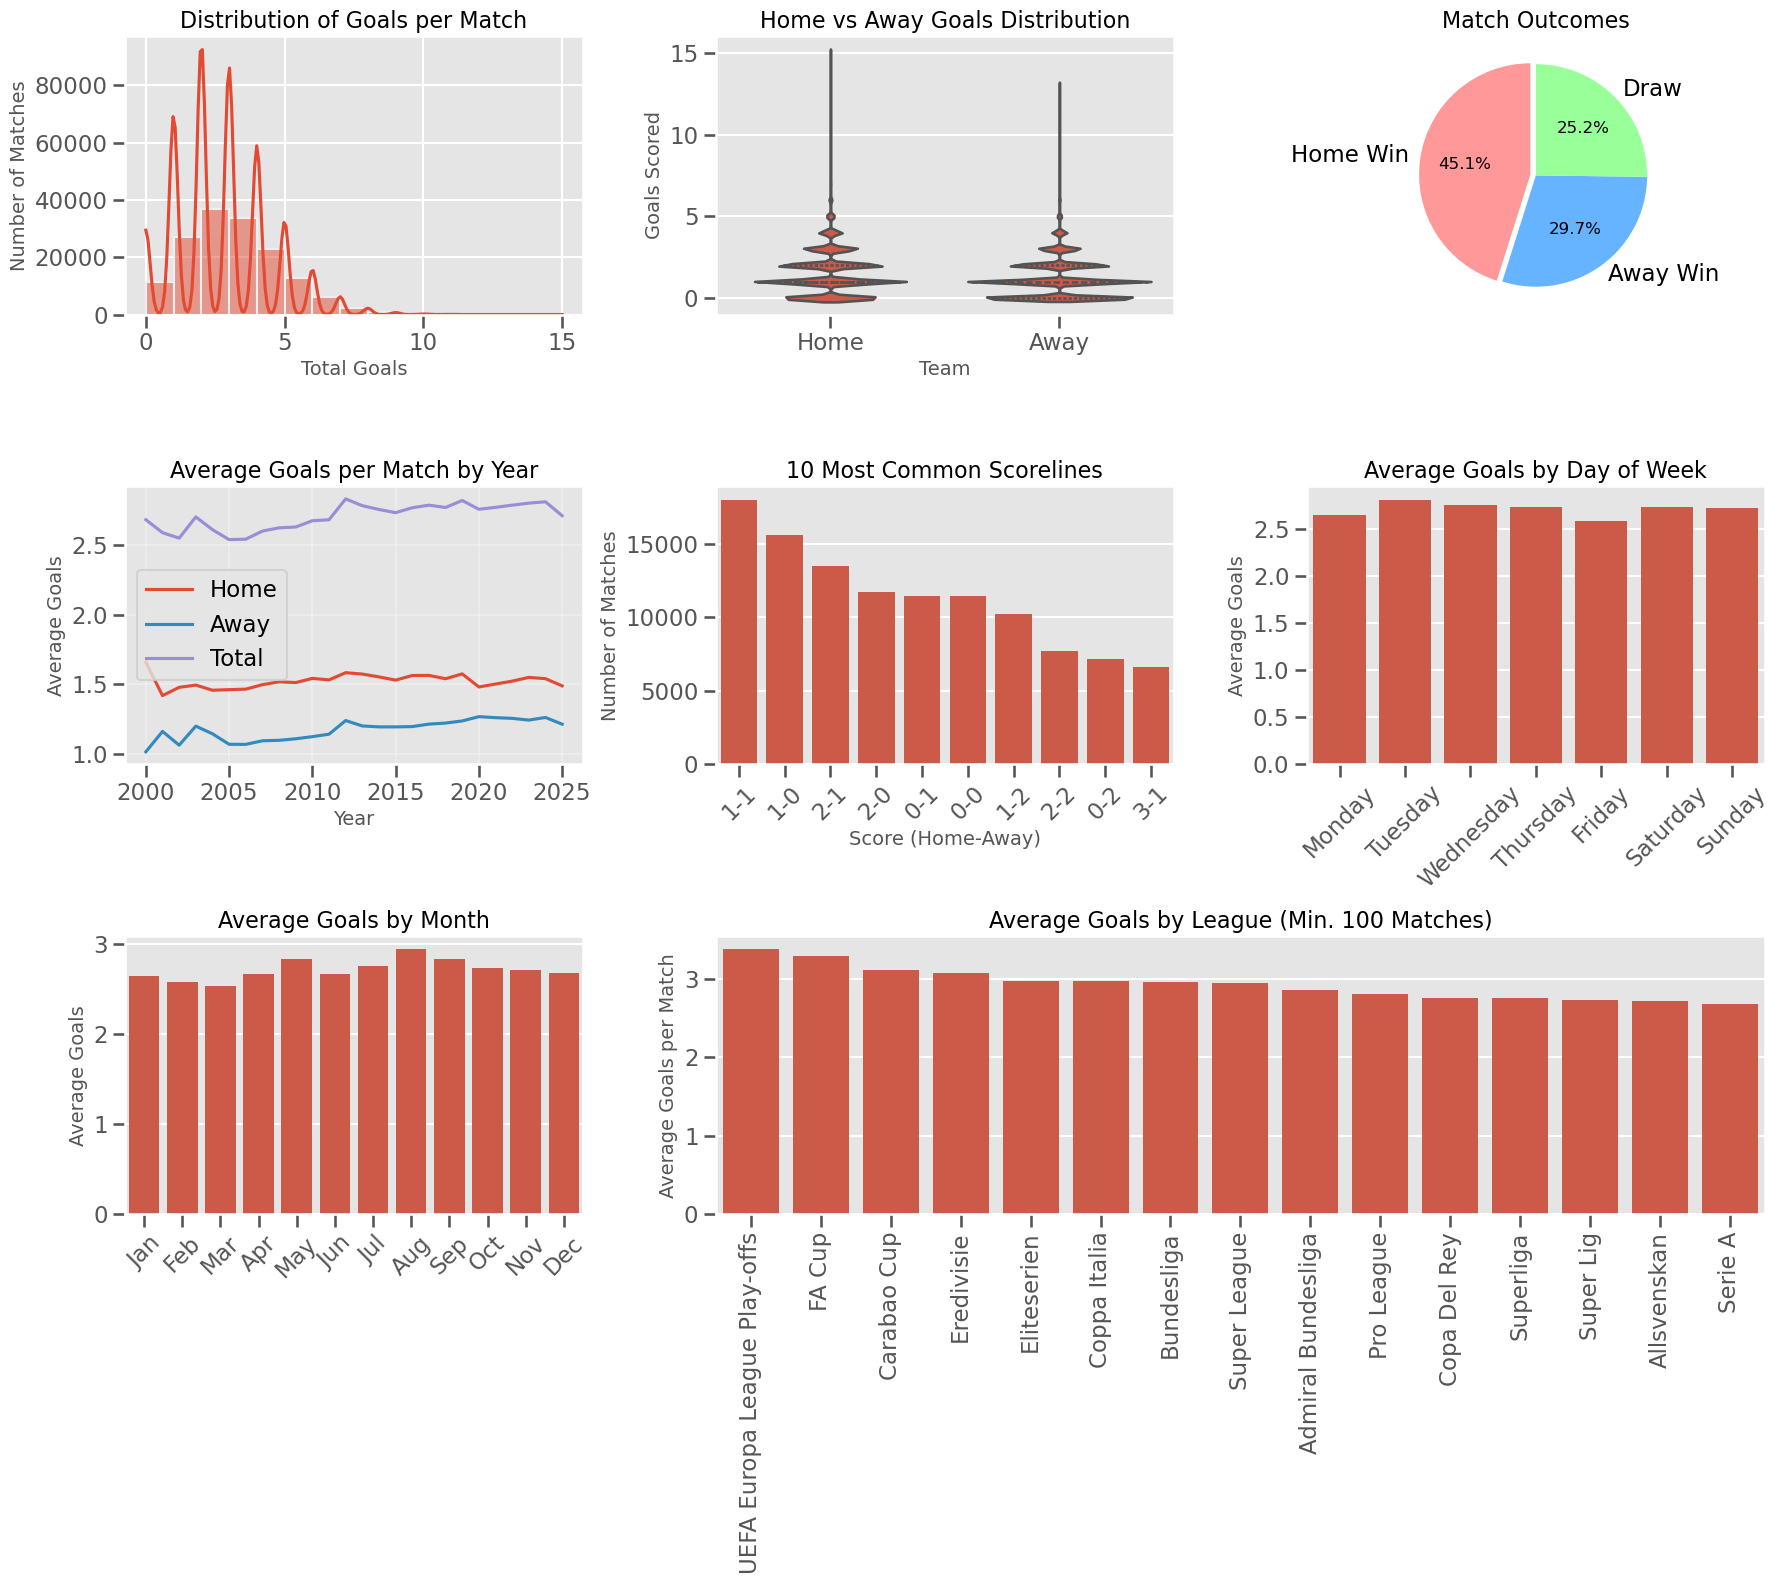


2. TEAM PERFORMANCE ANALYSIS


/var/folders/nl/dl4x3l3x1dd8twj43d1ddkx80000gn/T/ipykernel_28077/3209710671.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='goal_difference', y='team_name', data=top_gd, palette=colors, ax=ax4)


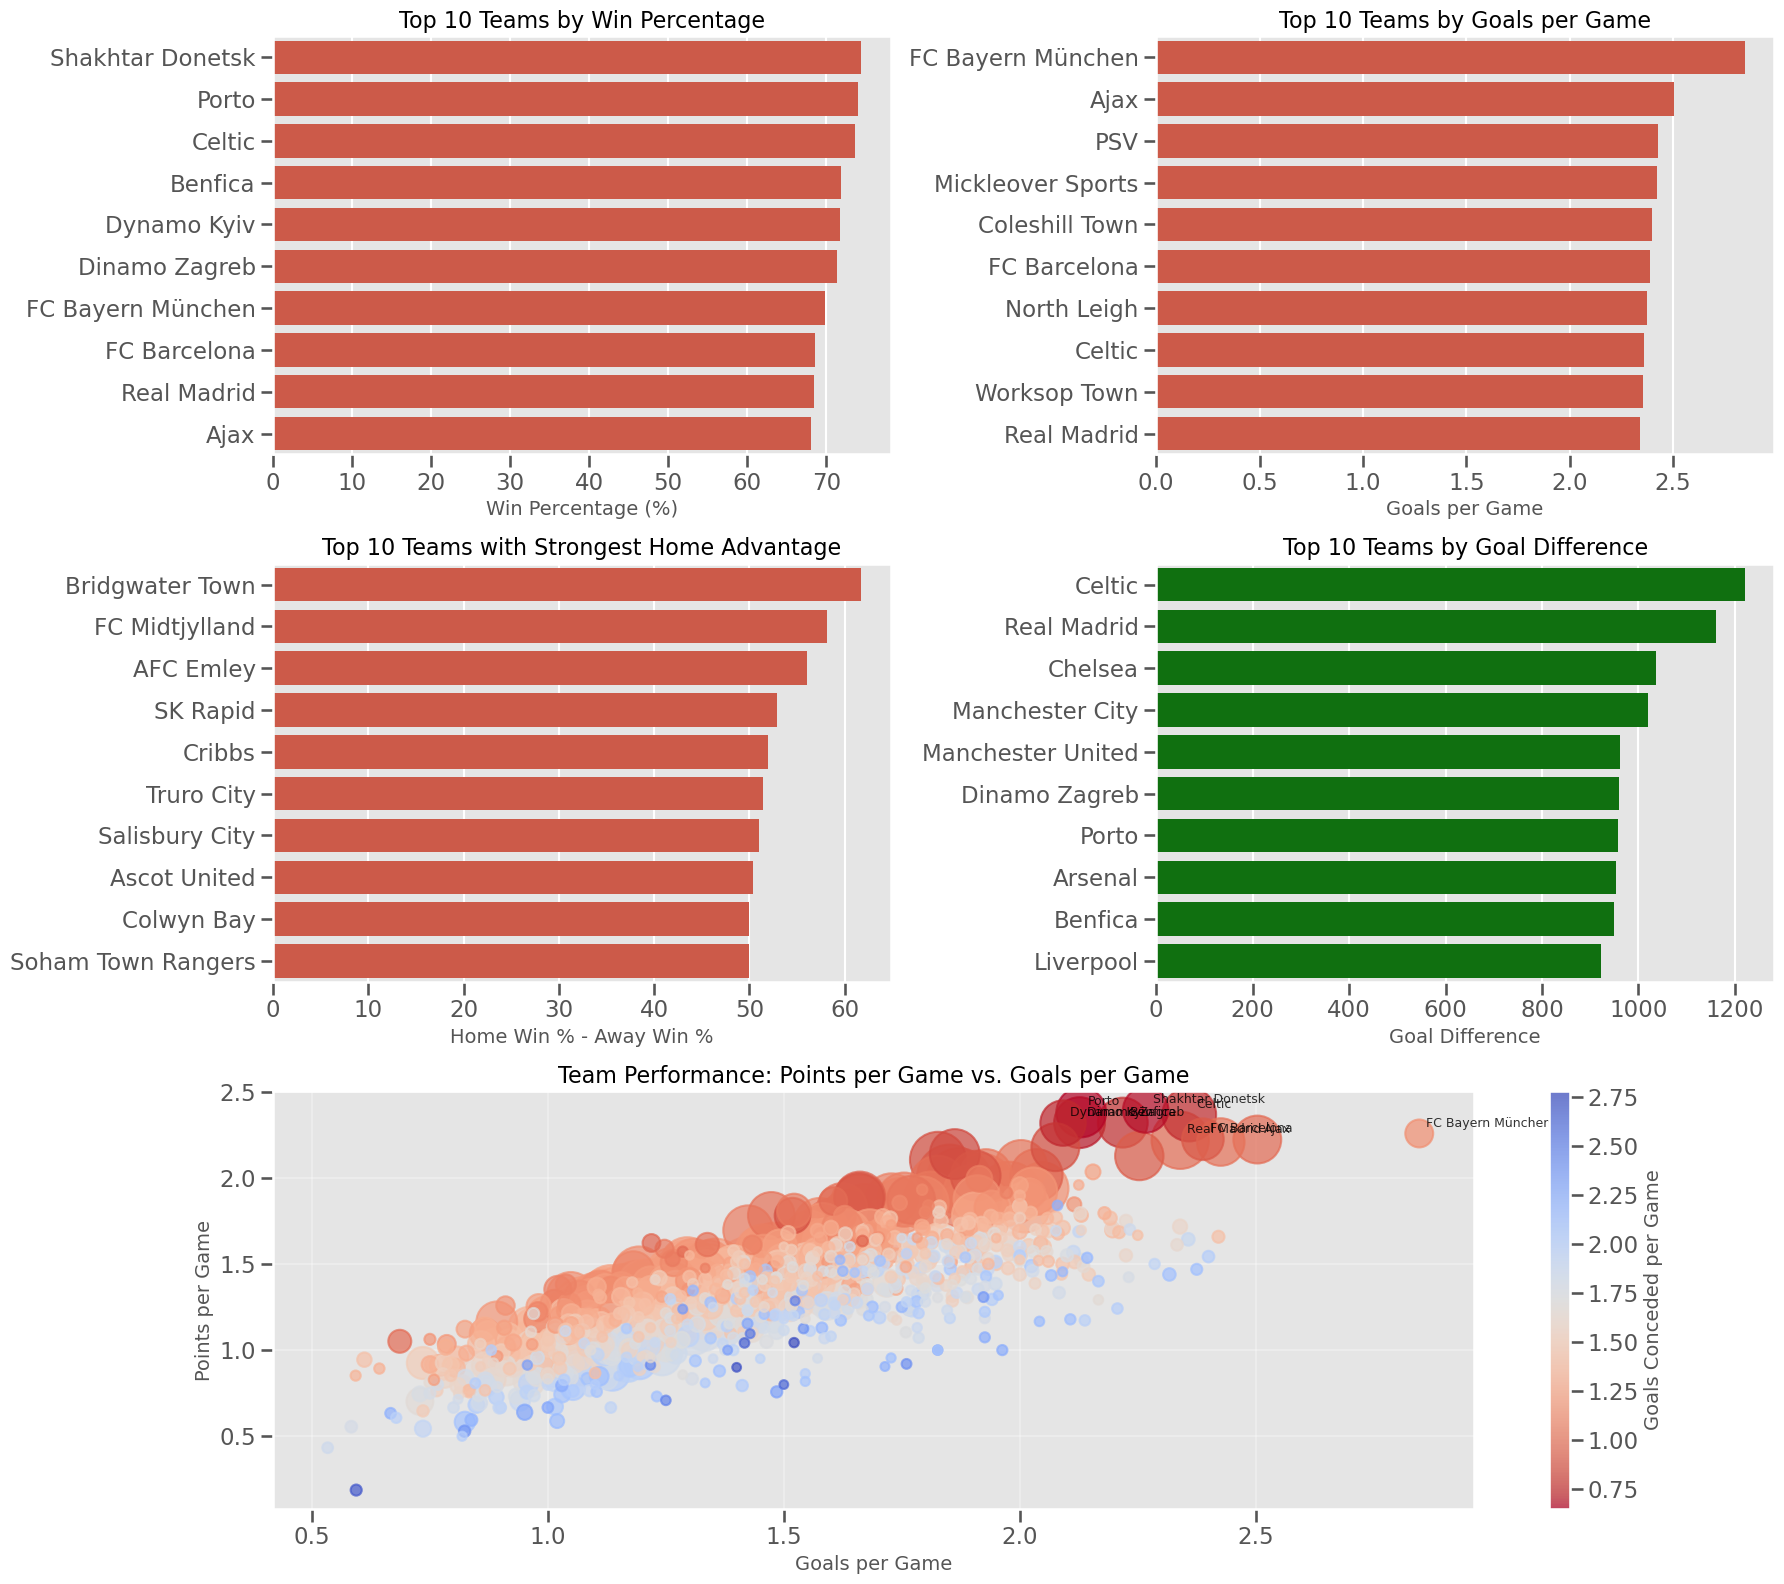


3. EVENTS ANALYSIS


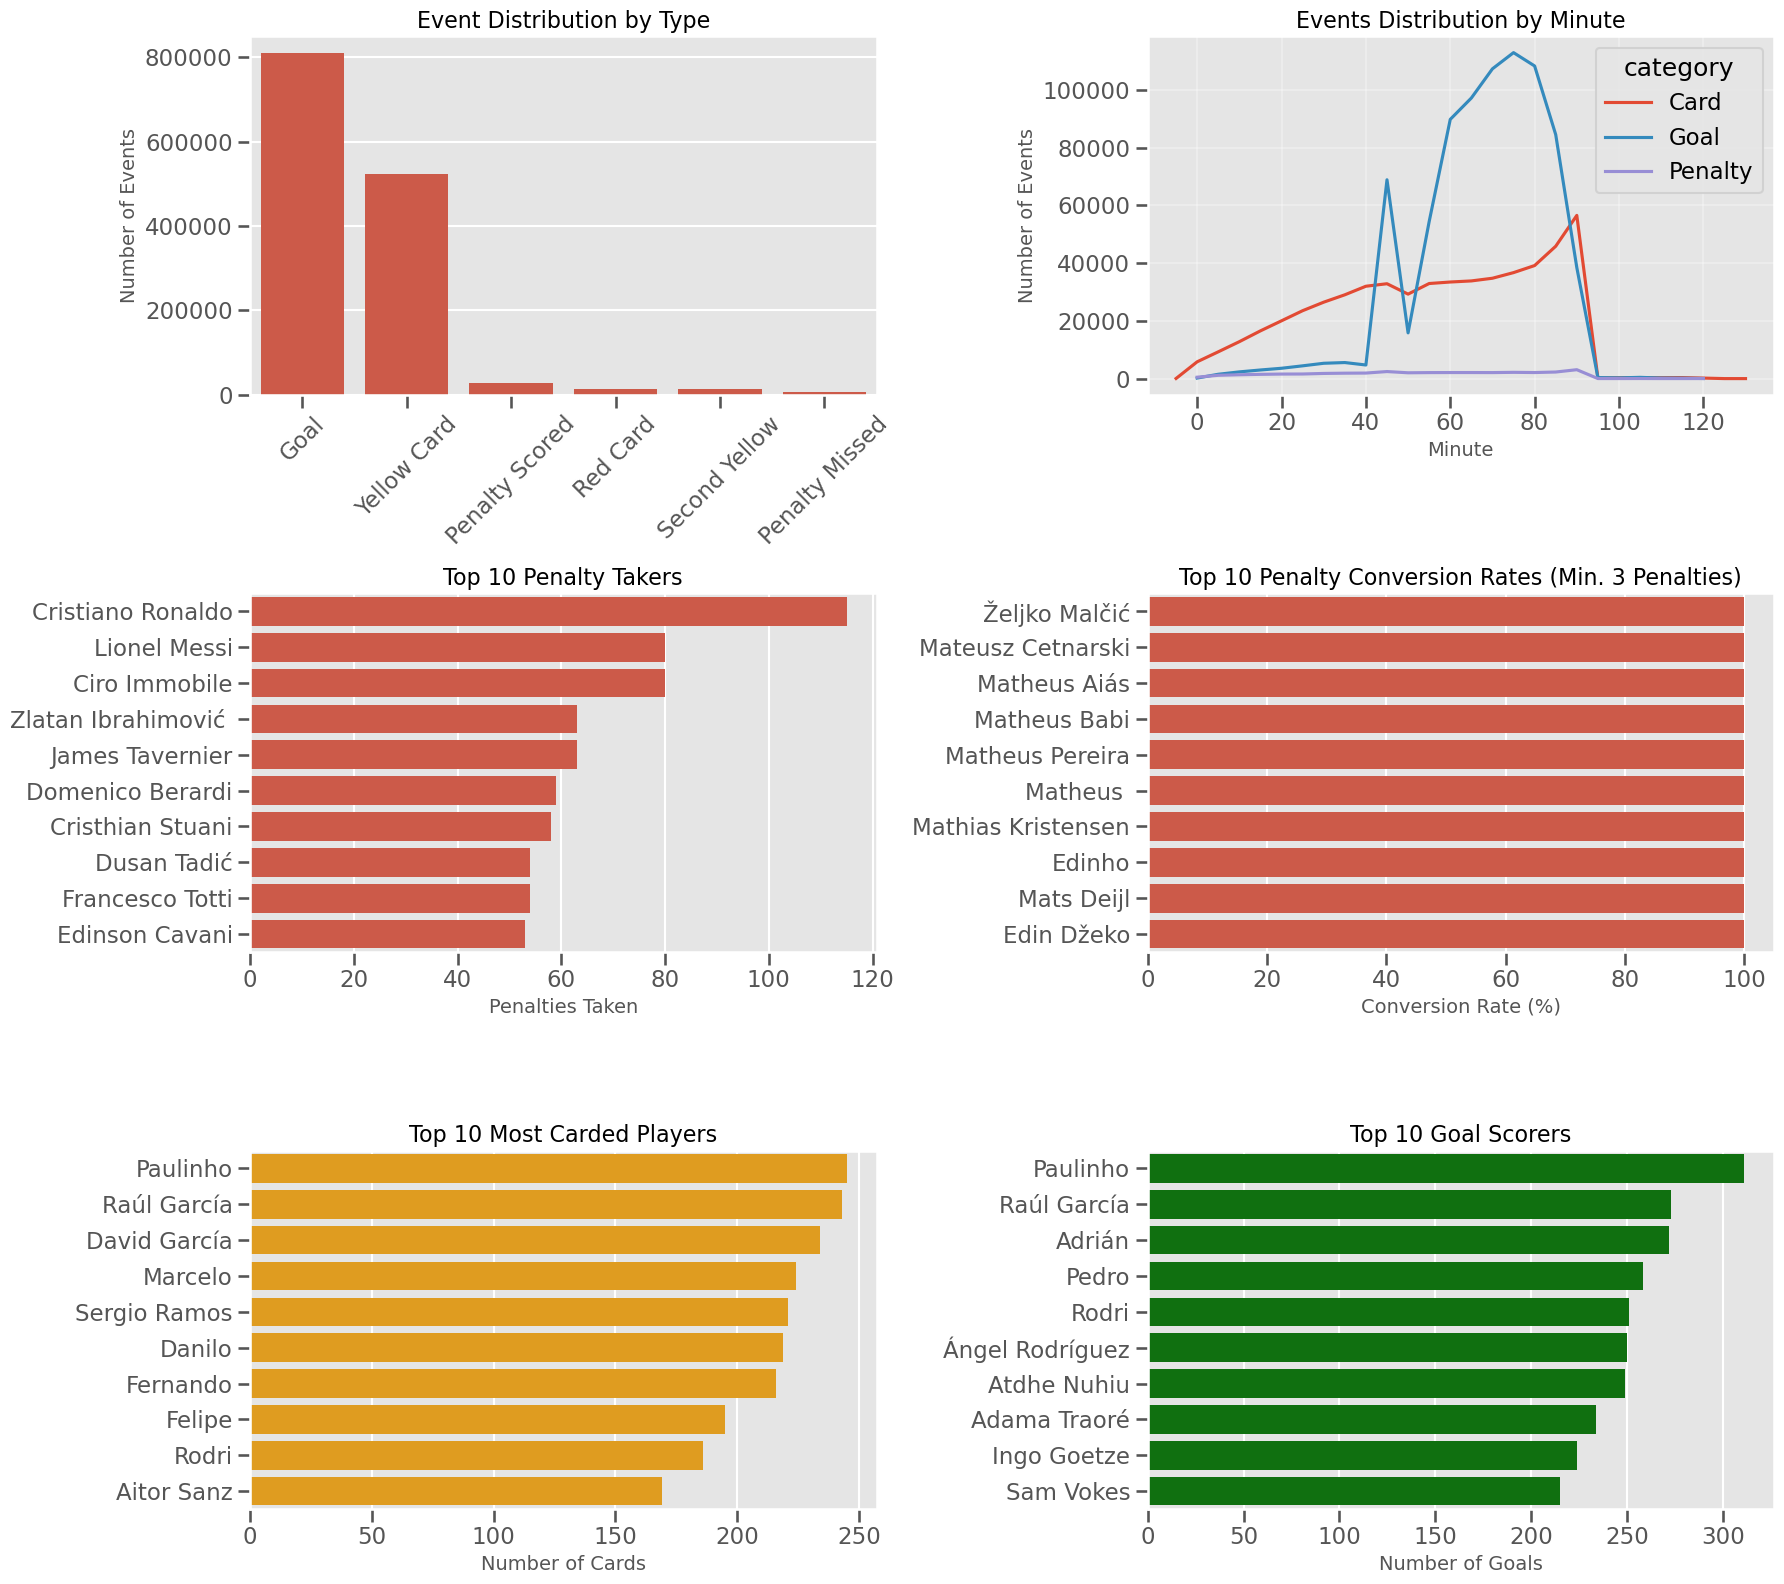


4. LEAGUE COMPARISONS


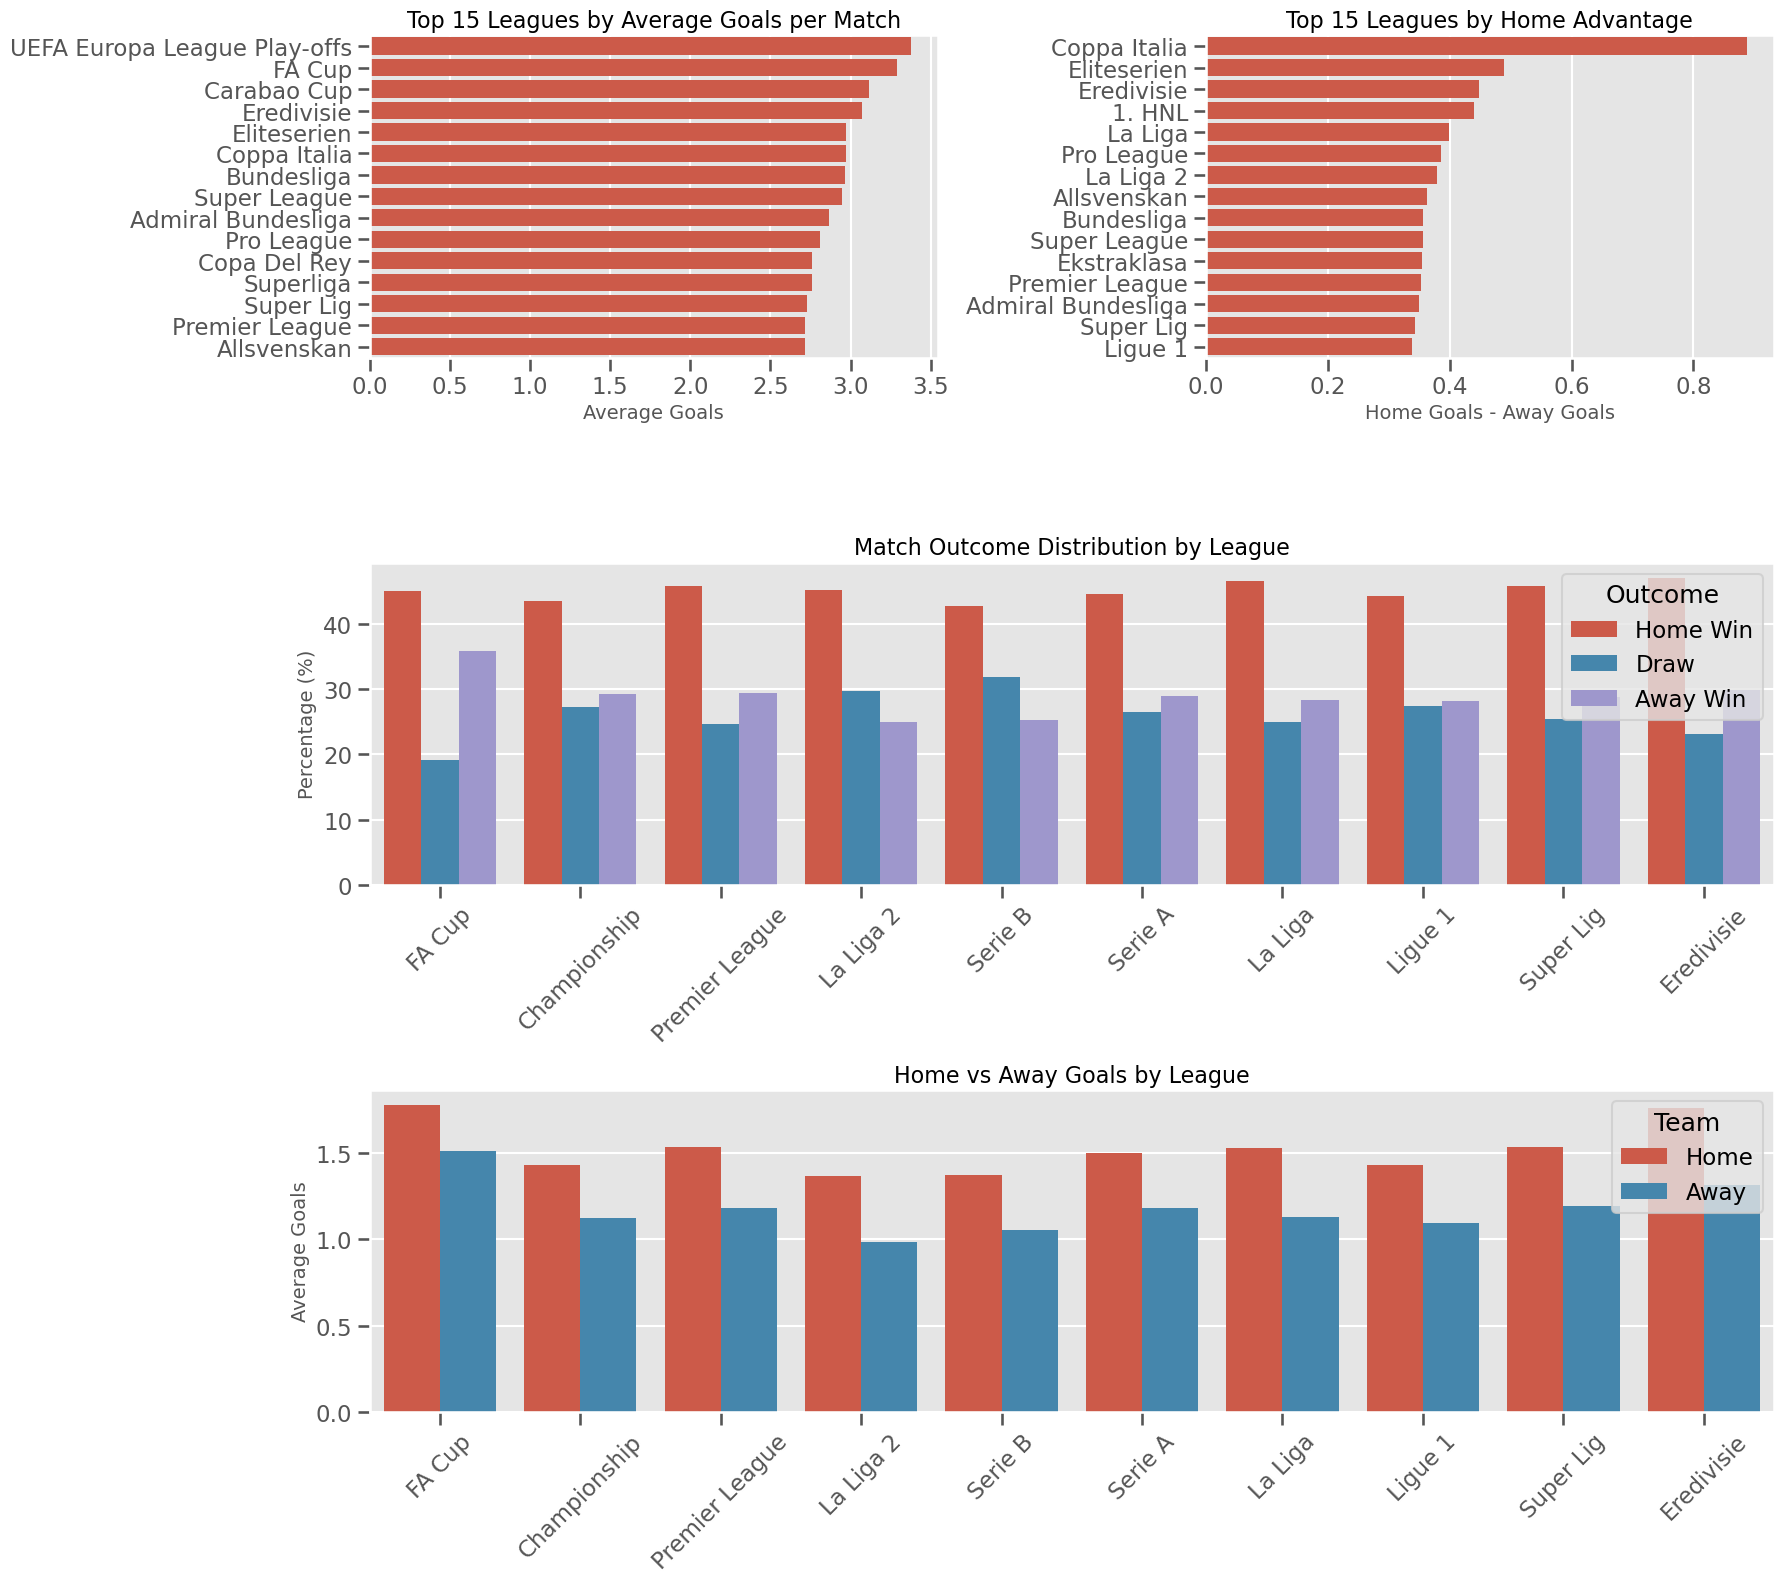


=== VISUALIZATIONS COMPLETE ===


In [21]:
# Comprehensive Football Data Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

print("=== FOOTBALL DATA VISUALIZATIONS ===\n")

# 1. GOALS ANALYSIS
print("1. GOALS AND SCORING PATTERNS")

# Get all fixtures with scores and convert date
goals_data = pd.read_sql("""
    SELECT 
        f.id, 
        f.score_home,
        f.score_away,
        (f.score_home + f.score_away) as total_goals,
        f.home_team_id,
        f.away_team_id,
        l.name as league_name,
        f.league_id,
        f.season_id,
        f.starting_at,
        CASE 
            WHEN f.score_home > f.score_away THEN 'Home Win'
            WHEN f.score_home < f.score_away THEN 'Away Win'
            ELSE 'Draw'
        END as result
    FROM fixtures f
    JOIN leagues l ON f.league_id = l.id
    WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
""", conn)

goals_data['starting_at'] = pd.to_datetime(goals_data['starting_at'])
goals_data['year'] = goals_data['starting_at'].dt.year
goals_data['month'] = goals_data['starting_at'].dt.month
goals_data['day_of_week'] = goals_data['starting_at'].dt.dayofweek

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 3)

# 1.1 Total goals distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(goals_data['total_goals'], bins=range(0, 15), kde=True, ax=ax1)
ax1.set_title('Distribution of Goals per Match')
ax1.set_xlabel('Total Goals')
ax1.set_ylabel('Number of Matches')

# 1.2 Home vs Away goals comparison
ax2 = fig.add_subplot(gs[0, 1])
home_away_df = pd.melt(goals_data[['score_home', 'score_away']], 
                      value_vars=['score_home', 'score_away'],
                      var_name='Team', value_name='Goals')
home_away_df['Team'] = home_away_df['Team'].map({'score_home': 'Home', 'score_away': 'Away'})
sns.violinplot(x='Team', y='Goals', data=home_away_df, inner='quartile', ax=ax2)
ax2.set_title('Home vs Away Goals Distribution')
ax2.set_ylabel('Goals Scored')

# 1.3 Match outcomes
ax3 = fig.add_subplot(gs[0, 2])
outcome_counts = goals_data['result'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
ax3.pie(outcome_counts.values, labels=outcome_counts.index, autopct='%1.1f%%', 
       startangle=90, colors=colors, explode=[0.05, 0, 0])
ax3.set_title('Match Outcomes')

# 1.4 Goals by year
ax4 = fig.add_subplot(gs[1, 0])
yearly_goals = goals_data.groupby('year')[['score_home', 'score_away', 'total_goals']].mean()
yearly_goals.plot(ax=ax4)
ax4.set_title('Average Goals per Match by Year')
ax4.set_xlabel('Year')
ax4.set_ylabel('Average Goals')
ax4.legend(['Home', 'Away', 'Total'])
ax4.grid(True, alpha=0.3)

# 1.5 Most common scorelines
ax5 = fig.add_subplot(gs[1, 1])
scorelines = goals_data.groupby(['score_home', 'score_away']).size().reset_index(name='count')
scorelines['scoreline'] = scorelines['score_home'].astype(str) + '-' + scorelines['score_away'].astype(str)
scorelines = scorelines.sort_values('count', ascending=False).head(10)
sns.barplot(x='scoreline', y='count', data=scorelines, ax=ax5)
ax5.set_title('10 Most Common Scorelines')
ax5.set_xlabel('Score (Home-Away)')
ax5.set_ylabel('Number of Matches')
plt.setp(ax5.get_xticklabels(), rotation=45)

# 1.6 Goals by day of week
ax6 = fig.add_subplot(gs[1, 2])
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_goals = goals_data.groupby('day_of_week')['total_goals'].mean().reset_index()
weekday_goals['day_name'] = weekday_goals['day_of_week'].map(lambda x: day_names[x])
sns.barplot(x='day_name', y='total_goals', data=weekday_goals, ax=ax6)
ax6.set_title('Average Goals by Day of Week')
ax6.set_xlabel('')
ax6.set_ylabel('Average Goals')
plt.setp(ax6.get_xticklabels(), rotation=45)

# 1.7 Goals by month
ax7 = fig.add_subplot(gs[2, 0])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_goals = goals_data.groupby('month')['total_goals'].mean().reset_index()
monthly_goals['month_name'] = monthly_goals['month'].map(lambda x: month_names[x-1])
sns.barplot(x='month_name', y='total_goals', data=monthly_goals, ax=ax7)
ax7.set_title('Average Goals by Month')
ax7.set_xlabel('')
ax7.set_ylabel('Average Goals')
plt.setp(ax7.get_xticklabels(), rotation=45)

# 1.8 High scoring matches by league
ax8 = fig.add_subplot(gs[2, 1:])
league_goals = goals_data.groupby('league_name')['total_goals'].agg(['mean', 'max', 'count'])
league_goals = league_goals[league_goals['count'] > 100].sort_values('mean', ascending=False).head(15)
sns.barplot(x=league_goals.index, y=league_goals['mean'], ax=ax8)
ax8.set_title('Average Goals by League (Min. 100 Matches)')
ax8.set_xlabel('')
ax8.set_ylabel('Average Goals per Match')
plt.setp(ax8.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig('goals_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. TEAM PERFORMANCE ANALYSIS
print("\n2. TEAM PERFORMANCE ANALYSIS")

# Get team data for teams with enough matches
team_data = pd.read_sql("""
    SELECT 
        t.id as team_id,
        t.name as team_name,
        COUNT(CASE WHEN f.home_team_id = t.id THEN 1 END) as home_matches,
        COUNT(CASE WHEN f.away_team_id = t.id THEN 1 END) as away_matches,
        SUM(CASE WHEN f.home_team_id = t.id THEN f.score_home ELSE 0 END) as goals_scored_home,
        SUM(CASE WHEN f.home_team_id = t.id THEN f.score_away ELSE 0 END) as goals_conceded_home,
        SUM(CASE WHEN f.away_team_id = t.id THEN f.score_away ELSE 0 END) as goals_scored_away,
        SUM(CASE WHEN f.away_team_id = t.id THEN f.score_home ELSE 0 END) as goals_conceded_away,
        SUM(CASE WHEN f.home_team_id = t.id AND f.score_home > f.score_away THEN 1 ELSE 0 END) as home_wins,
        SUM(CASE WHEN f.home_team_id = t.id AND f.score_home = f.score_away THEN 1 ELSE 0 END) as home_draws,
        SUM(CASE WHEN f.home_team_id = t.id AND f.score_home < f.score_away THEN 1 ELSE 0 END) as home_losses,
        SUM(CASE WHEN f.away_team_id = t.id AND f.score_away > f.score_home THEN 1 ELSE 0 END) as away_wins,
        SUM(CASE WHEN f.away_team_id = t.id AND f.score_away = f.score_home THEN 1 ELSE 0 END) as away_draws,
        SUM(CASE WHEN f.away_team_id = t.id AND f.score_away < f.score_home THEN 1 ELSE 0 END) as away_losses
    FROM teams t
    JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
    WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    GROUP BY t.id, t.name
    HAVING (home_matches + away_matches) >= 20
    ORDER BY (home_matches + away_matches) DESC
""", conn)

# Calculate additional metrics
team_data['total_matches'] = team_data['home_matches'] + team_data['away_matches']
team_data['total_wins'] = team_data['home_wins'] + team_data['away_wins']
team_data['total_draws'] = team_data['home_draws'] + team_data['away_draws']
team_data['total_losses'] = team_data['home_losses'] + team_data['away_losses']
team_data['total_goals_scored'] = team_data['goals_scored_home'] + team_data['goals_scored_away']
team_data['total_goals_conceded'] = team_data['goals_conceded_home'] + team_data['goals_conceded_away']
team_data['goal_difference'] = team_data['total_goals_scored'] - team_data['total_goals_conceded']
team_data['points'] = team_data['total_wins'] * 3 + team_data['total_draws']
team_data['points_per_game'] = team_data['points'] / team_data['total_matches']
team_data['win_percentage'] = team_data['total_wins'] / team_data['total_matches'] * 100
team_data['goals_per_game'] = team_data['total_goals_scored'] / team_data['total_matches']
team_data['goals_conceded_per_game'] = team_data['total_goals_conceded'] / team_data['total_matches']
team_data['home_win_percentage'] = team_data['home_wins'] / team_data['home_matches'] * 100
team_data['away_win_percentage'] = team_data['away_wins'] / team_data['away_matches'] * 100

# Create team performance visualizations
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 2)

# 2.1 Top teams by win percentage
ax1 = fig.add_subplot(gs[0, 0])
top_teams = team_data.sort_values('win_percentage', ascending=False).head(10)
sns.barplot(x='win_percentage', y='team_name', data=top_teams, ax=ax1)
ax1.set_title('Top 10 Teams by Win Percentage')
ax1.set_xlabel('Win Percentage (%)')
ax1.set_ylabel('')

# 2.2 Top goal scoring teams
ax2 = fig.add_subplot(gs[0, 1])
top_scoring = team_data.sort_values('goals_per_game', ascending=False).head(10)
sns.barplot(x='goals_per_game', y='team_name', data=top_scoring, ax=ax2)
ax2.set_title('Top 10 Teams by Goals per Game')
ax2.set_xlabel('Goals per Game')
ax2.set_ylabel('')

# 2.3 Home vs Away win percentage
ax3 = fig.add_subplot(gs[1, 0])
home_away_diff = team_data.copy()
home_away_diff['home_away_diff'] = home_away_diff['home_win_percentage'] - home_away_diff['away_win_percentage']
top_home_advantage = home_away_diff.sort_values('home_away_diff', ascending=False).head(10)
sns.barplot(x='home_away_diff', y='team_name', data=top_home_advantage, ax=ax3)
ax3.set_title('Top 10 Teams with Strongest Home Advantage')
ax3.set_xlabel('Home Win % - Away Win %')
ax3.set_ylabel('')

# 2.4 Goal difference
ax4 = fig.add_subplot(gs[1, 1])
top_gd = team_data.sort_values('goal_difference', ascending=False).head(10)
colors = ['green' if x > 0 else 'red' for x in top_gd['goal_difference']]
sns.barplot(x='goal_difference', y='team_name', data=top_gd, palette=colors, ax=ax4)
ax4.set_title('Top 10 Teams by Goal Difference')
ax4.set_xlabel('Goal Difference')
ax4.set_ylabel('')

# 2.5 Points per game vs Goals per game
ax5 = fig.add_subplot(gs[2, :])
scatter = ax5.scatter(
    team_data['goals_per_game'], 
    team_data['points_per_game'],
    c=team_data['goals_conceded_per_game'],
    s=team_data['total_matches']*2,
    alpha=0.7,
    cmap='coolwarm_r'
)
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax5)
cbar.set_label('Goals Conceded per Game')

# Annotate top teams
for i, team in enumerate(team_data.nlargest(10, 'points_per_game')['team_name']):
    idx = team_data[team_data['team_name'] == team].index[0]
    ax5.annotate(
        team, 
        (team_data.loc[idx, 'goals_per_game'], team_data.loc[idx, 'points_per_game']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        alpha=0.8
    )

ax5.set_title('Team Performance: Points per Game vs. Goals per Game')
ax5.set_xlabel('Goals per Game')
ax5.set_ylabel('Points per Game')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('team_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. EVENTS ANALYSIS (Goals, Cards, Penalties)
print("\n3. EVENTS ANALYSIS")

# Get events data from the database
events_data = pd.read_sql("""
    SELECT 
        e.id as event_id,
        e.fixture_id,
        e.team_id,
        e.player_id,
        json_extract(e.raw, '$.type_id') as type_id,
        json_extract(e.raw, '$.player_name') as player_name,
        json_extract(e.raw, '$.minute') as minute,
        f.starting_at
    FROM events e
    JOIN fixtures f ON e.fixture_id = f.id
    WHERE json_extract(e.raw, '$.type_id') IN (16, 17, 18, 19, 20, 21)
""", conn)

# Convert data types
events_data['type_id'] = events_data['type_id'].astype(int)
events_data['minute'] = events_data['minute'].astype(float)
events_data['starting_at'] = pd.to_datetime(events_data['starting_at'])

# Map event types
events_data['event_type'] = events_data['type_id'].map({
    16: 'Penalty Scored',
    17: 'Penalty Missed',
    18: 'Goal',
    19: 'Yellow Card',
    20: 'Red Card',
    21: 'Second Yellow'
})

# Group events into categories
events_data['category'] = events_data['type_id'].map({
    16: 'Penalty',
    17: 'Penalty',
    18: 'Goal',
    19: 'Card',
    20: 'Card',
    21: 'Card'
})

# Add time-related fields
events_data['hour'] = events_data['starting_at'].dt.hour
events_data['day_of_week'] = events_data['starting_at'].dt.dayofweek
events_data['day_name'] = events_data['day_of_week'].map(
    {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
)

# Group minutes into 5-minute intervals
events_data['minute_group'] = (events_data['minute'] // 5) * 5

# Create events visualizations
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 2)

# 3.1 Events by type
ax1 = fig.add_subplot(gs[0, 0])
event_counts = events_data['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values, ax=ax1)
ax1.set_title('Event Distribution by Type')
ax1.set_xlabel('')
ax1.set_ylabel('Number of Events')
plt.setp(ax1.get_xticklabels(), rotation=45)

# 3.2 Events by minute
ax2 = fig.add_subplot(gs[0, 1])
minute_groups = events_data.groupby(['minute_group', 'category']).size().reset_index(name='count')
sns.lineplot(x='minute_group', y='count', hue='category', data=minute_groups, ax=ax2)
ax2.set_title('Events Distribution by Minute')
ax2.set_xlabel('Minute')
ax2.set_ylabel('Number of Events')
ax2.grid(True, alpha=0.3)

# 3.3 Top penalty takers
ax3 = fig.add_subplot(gs[1, 0])
penalties = events_data[events_data['type_id'].isin([16, 17])]
top_penalty_takers = penalties.groupby('player_name').size().reset_index(name='penalties_taken')
top_penalty_takers = top_penalty_takers.sort_values('penalties_taken', ascending=False).head(10)
sns.barplot(y='player_name', x='penalties_taken', data=top_penalty_takers, ax=ax3)
ax3.set_title('Top 10 Penalty Takers')
ax3.set_xlabel('Penalties Taken')
ax3.set_ylabel('')

# 3.4 Penalty conversion rate
ax4 = fig.add_subplot(gs[1, 1])
penalty_conversion = penalties.groupby('player_name')['type_id'].apply(
    lambda x: (x == 16).sum() / len(x) * 100
).reset_index(name='conversion_rate')
penalty_conversion['total_penalties'] = penalties.groupby('player_name').size().values
penalty_conversion = penalty_conversion[penalty_conversion['total_penalties'] >= 3]
top_converters = penalty_conversion.sort_values('conversion_rate', ascending=False).head(10)
sns.barplot(y='player_name', x='conversion_rate', data=top_converters, ax=ax4)
ax4.set_title('Top 10 Penalty Conversion Rates (Min. 3 Penalties)')
ax4.set_xlabel('Conversion Rate (%)')
ax4.set_ylabel('')

# 3.5 Cards by player
ax5 = fig.add_subplot(gs[2, 0])
cards = events_data[events_data['category'] == 'Card']
top_carded = cards.groupby('player_name').size().reset_index(name='cards')
top_carded = top_carded.sort_values('cards', ascending=False).head(10)
sns.barplot(y='player_name', x='cards', data=top_carded, color='orange', ax=ax5)
ax5.set_title('Top 10 Most Carded Players')
ax5.set_xlabel('Number of Cards')
ax5.set_ylabel('')

# 3.6 Goal scorers
ax6 = fig.add_subplot(gs[2, 1])
goals = events_data[events_data['type_id'] == 18]
top_scorers = goals.groupby('player_name').size().reset_index(name='goals')
top_scorers = top_scorers.sort_values('goals', ascending=False).head(10)
sns.barplot(y='player_name', x='goals', data=top_scorers, color='green', ax=ax6)
ax6.set_title('Top 10 Goal Scorers')
ax6.set_xlabel('Number of Goals')
ax6.set_ylabel('')

plt.tight_layout()
plt.savefig('events_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. LEAGUE COMPARISONS
print("\n4. LEAGUE COMPARISONS")

# Get league-level data
league_data = pd.read_sql("""
    SELECT 
        l.id as league_id,
        l.name as league_name,
        COUNT(f.id) as match_count,
        AVG(f.score_home + f.score_away) as avg_goals,
        AVG(f.score_home) as avg_home_goals,
        AVG(f.score_away) as avg_away_goals,
        SUM(CASE WHEN f.score_home > f.score_away THEN 1 ELSE 0 END) as home_wins,
        SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) as draws,
        SUM(CASE WHEN f.score_home < f.score_away THEN 1 ELSE 0 END) as away_wins
    FROM leagues l
    JOIN fixtures f ON l.id = f.league_id
    WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    GROUP BY l.id, l.name
    HAVING match_count >= 100
    ORDER BY match_count DESC
""", conn)

# Calculate additional metrics
league_data['home_win_pct'] = league_data['home_wins'] / league_data['match_count'] * 100
league_data['draw_pct'] = league_data['draws'] / league_data['match_count'] * 100
league_data['away_win_pct'] = league_data['away_wins'] / league_data['match_count'] * 100
league_data['home_advantage'] = league_data['avg_home_goals'] - league_data['avg_away_goals']

# Create league comparison visualizations
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 2)

# 4.1 Average goals by league
ax1 = fig.add_subplot(gs[0, 0])
top_goal_leagues = league_data.sort_values('avg_goals', ascending=False).head(15)
sns.barplot(y='league_name', x='avg_goals', data=top_goal_leagues, ax=ax1)
ax1.set_title('Top 15 Leagues by Average Goals per Match')
ax1.set_xlabel('Average Goals')
ax1.set_ylabel('')

# 4.2 Home advantage by league
ax2 = fig.add_subplot(gs[0, 1])
top_home_adv = league_data.sort_values('home_advantage', ascending=False).head(15)
sns.barplot(y='league_name', x='home_advantage', data=top_home_adv, ax=ax2)
ax2.set_title('Top 15 Leagues by Home Advantage')
ax2.set_xlabel('Home Goals - Away Goals')
ax2.set_ylabel('')

# 4.3 Match outcome distribution by league
ax3 = fig.add_subplot(gs[1, :])
top_leagues = league_data.sort_values('match_count', ascending=False).head(10)
outcome_data = pd.DataFrame({
    'League': np.repeat(top_leagues['league_name'], 3),
    'Outcome': np.tile(['Home Win', 'Draw', 'Away Win'], 10),
    'Percentage': np.concatenate([
        top_leagues[['home_win_pct', 'draw_pct', 'away_win_pct']].values.flatten()
    ])
})
sns.barplot(x='League', y='Percentage', hue='Outcome', data=outcome_data, ax=ax3)
ax3.set_title('Match Outcome Distribution by League')
ax3.set_xlabel('')
ax3.set_ylabel('Percentage (%)')
plt.setp(ax3.get_xticklabels(), rotation=45)

# 4.4 Home vs Away goals by league
ax4 = fig.add_subplot(gs[2, :])
top_leagues_goals = league_data.sort_values('match_count', ascending=False).head(10)
goal_data = pd.DataFrame({
    'League': np.repeat(top_leagues_goals['league_name'], 2),
    'Team': np.tile(['Home', 'Away'], 10),
    'Average Goals': np.concatenate([
        top_leagues_goals[['avg_home_goals', 'avg_away_goals']].values.flatten()
    ])
})
sns.barplot(x='League', y='Average Goals', hue='Team', data=goal_data, ax=ax4)
ax4.set_title('Home vs Away Goals by League')
ax4.set_xlabel('')
ax4.set_ylabel('Average Goals')
plt.setp(ax4.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('league_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Close the database connection
conn.close()

print("\n=== VISUALIZATIONS COMPLETE ===")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# Function to get all seasons from database
def get_seasons():
    seasons = pd.read_sql("""
        SELECT DISTINCT season_id, 
               (SELECT name FROM seasons WHERE id = season_id) as season_name
        FROM fixtures
        WHERE season_id IS NOT NULL
        ORDER BY season_id DESC
    """, conn)
    return seasons

# Function to get all leagues from database
def get_leagues():
    leagues = pd.read_sql("""
        SELECT DISTINCT l.id, l.name
        FROM leagues l
        JOIN fixtures f ON l.id = f.league_id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        ORDER BY l.name
    """, conn)
    return leagues

# Function to get teams, filtered by league if specified
def get_teams(league_id=None):
    if league_id and league_id != 'all':
        teams = pd.read_sql(f"""
            SELECT DISTINCT t.id, t.name
            FROM teams t
            JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
            WHERE f.league_id = {league_id}
            ORDER BY t.name
        """, conn)
    else:
        teams = pd.read_sql("""
            SELECT DISTINCT t.id, t.name
            FROM teams t
            JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
            WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            ORDER BY t.name
        """, conn)
    return teams

# Function to get players, filtered by team if specified
def get_players(team_id=None):
    if team_id and team_id != 'all':
        players = pd.read_sql(f"""
            SELECT DISTINCT p.id, p.common_name as name
            FROM players p
            JOIN events e ON p.id = e.player_id
            JOIN fixtures f ON e.fixture_id = f.id
            WHERE (f.home_team_id = {team_id} OR f.away_team_id = {team_id})
            ORDER BY name
        """, conn)
    else:
        players = pd.read_sql("""
            SELECT DISTINCT p.id, p.common_name as name
            FROM players p
            JOIN events e ON p.id = e.player_id
            ORDER BY name
            LIMIT 1000 -- Limit to prevent too many options
        """, conn)
    return players

# Main class for interactive football visualizations
class FootballViz:
    def __init__(self):
        # Get filter options
        self.seasons = get_seasons()
        self.leagues = get_leagues()
        self.teams = get_teams()
        self.players = get_players()
        
        # Initialize widgets
        self.setup_widgets()
        
    def setup_widgets(self):
        # Create dropdown for visualization type
        self.viz_type = widgets.Dropdown(
            options=['Goals Analysis', 'Team Performance', 'Events Analysis', 'League Comparisons'],
            value='Goals Analysis',
            description='Visualization:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create season filter
        self.season_dropdown = widgets.Dropdown(
            options=[('All Seasons', 'all')] + [(row.season_name, row.season_id) for _, row in self.seasons.iterrows()],
            value='all',
            description='Season:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create league filter
        self.league_dropdown = widgets.Dropdown(
            options=[('All Leagues', 'all')] + [(row.name, row.id) for _, row in self.leagues.iterrows()],
            value='all',
            description='League:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create team filter
        self.team_dropdown = widgets.Dropdown(
            options=[('All Teams', 'all')] + [(row.name, row.id) for _, row in self.teams.iterrows()],
            value='all',
            description='Team:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create player filter
        self.player_dropdown = widgets.Dropdown(
            options=[('All Players', 'all')] + [(row.name, row.id) for _, row in self.players.iterrows()],
            value='all',
            description='Player:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create button to apply filters
        self.apply_button = widgets.Button(
            description='Generate Visualizations',
            button_style='primary',
            tooltip='Click to apply filters and generate visualizations',
            icon='chart-bar'
        )
        
        # Add callback for league change to update teams
        self.league_dropdown.observe(self.update_teams, names='value')
        
        # Add callback for team change to update players
        self.team_dropdown.observe(self.update_players, names='value')
        
        # Add callback for apply button
        self.apply_button.on_click(self.on_apply_clicked)
        
        # Create output widget for visualizations
        self.output = widgets.Output()
        
        # Display widgets
        display(widgets.HTML("<h1>Interactive Football Statistics</h1>"))
        display(widgets.HBox([self.viz_type, self.season_dropdown]))
        display(widgets.HBox([self.league_dropdown, self.team_dropdown, self.player_dropdown]))
        display(self.apply_button)
        display(self.output)
    
    def update_teams(self, change):
        # Update teams dropdown based on selected league
        league_id = change.new
        self.teams = get_teams(league_id)
        self.team_dropdown.options = [('All Teams', 'all')] + [(row.name, row.id) for _, row in self.teams.iterrows()]
        self.team_dropdown.value = 'all'
    
    def update_players(self, change):
        # Update players dropdown based on selected team
        team_id = change.new
        self.players = get_players(team_id)
        self.player_dropdown.options = [('All Players', 'all')] + [(row.name, row.id) for _, row in self.players.iterrows()]
        self.player_dropdown.value = 'all'
    
    def on_apply_clicked(self, b):
        # Clear previous output
        self.output.clear_output()
        
        # Get selected values
        viz_type = self.viz_type.value
        season_id = self.season_dropdown.value
        league_id = self.league_dropdown.value
        team_id = self.team_dropdown.value
        player_id = self.player_dropdown.value
        
        # Generate visualizations based on selected type
        with self.output:
            if viz_type == 'Goals Analysis':
                self.show_goals_analysis(season_id, league_id, team_id)
            elif viz_type == 'Team Performance':
                self.show_team_performance(season_id, league_id, team_id)
            elif viz_type == 'Events Analysis':
                self.show_events_analysis(season_id, league_id, team_id, player_id)
            elif viz_type == 'League Comparisons':
                self.show_league_comparisons(season_id, league_id)
    
    def build_filter_sql(self, season_id, league_id, team_id, player_id=None):
        """Build SQL WHERE clause based on filter selections"""
        conditions = ["f.score_home IS NOT NULL AND f.score_away IS NOT NULL"]
        
        if season_id != 'all':
            conditions.append(f"f.season_id = {season_id}")
        
        if league_id != 'all':
            conditions.append(f"f.league_id = {league_id}")
        
        if team_id != 'all':
            conditions.append(f"(f.home_team_id = {team_id} OR f.away_team_id = {team_id})")
        
        if player_id and player_id != 'all':
            # This would need to be handled differently based on the query,
            # as it might involve joining with events
            pass
        
        return " AND ".join(conditions)
    
    def show_goals_analysis(self, season_id, league_id, team_id):
        """Show goals analysis visualizations"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id, team_id)
        
        # Get goals data with filters applied
        goals_data = pd.read_sql(f"""
            SELECT 
                f.id, 
                f.score_home,
                f.score_away,
                (f.score_home + f.score_away) as total_goals,
                f.home_team_id,
                f.away_team_id,
                l.name as league_name,
                f.league_id,
                f.season_id,
                s.name as season_name,
                f.starting_at,
                CASE 
                    WHEN f.score_home > f.score_away THEN 'Home Win'
                    WHEN f.score_home < f.score_away THEN 'Away Win'
                    ELSE 'Draw'
                END as result,
                ht.name as home_team_name,
                at.name as away_team_name
            FROM fixtures f
            JOIN leagues l ON f.league_id = l.id
            JOIN seasons s ON f.season_id = s.id
            JOIN teams ht ON f.home_team_id = ht.id
            JOIN teams at ON f.away_team_id = at.id
            WHERE {filter_condition}
        """, conn)
        
        # Convert date and add derived fields
        goals_data['starting_at'] = pd.to_datetime(goals_data['starting_at'])
        goals_data['year'] = goals_data['starting_at'].dt.year
        goals_data['month'] = goals_data['starting_at'].dt.month
        goals_data['day_of_week'] = goals_data['starting_at'].dt.dayofweek
        
        # Show summary info
        print(f"Goal Analysis:")
        print(f"Total matches: {len(goals_data)}")
        if season_id != 'all':
            season_name = goals_data['season_name'].iloc[0] if not goals_data.empty else "Unknown"
            print(f"Season: {season_name}")
        if league_id != 'all':
            league_name = goals_data['league_name'].iloc[0] if not goals_data.empty else "Unknown"
            print(f"League: {league_name}")
        if team_id != 'all':
            team_matches = goals_data[(goals_data['home_team_id'] == team_id) | (goals_data['away_team_id'] == team_id)]
            team_name = team_matches['home_team_name'].iloc[0] if team_matches['home_team_id'].iloc[0] == team_id else team_matches['away_team_name'].iloc[0]
            print(f"Team: {team_name}")
        print("")
        
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 3)
        
        # 1.1 Total goals distribution
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(goals_data['total_goals'], bins=range(0, 15), kde=True, ax=ax1)
        ax1.set_title('Distribution of Goals per Match')
        ax1.set_xlabel('Total Goals')
        ax1.set_ylabel('Number of Matches')
        
        # 1.2 Home vs Away goals comparison
        ax2 = fig.add_subplot(gs[0, 1])
        home_away_df = pd.melt(goals_data[['score_home', 'score_away']], 
                              value_vars=['score_home', 'score_away'],
                              var_name='Team', value_name='Goals')
        home_away_df['Team'] = home_away_df['Team'].map({'score_home': 'Home', 'score_away': 'Away'})
        sns.violinplot(x='Team', y='Goals', data=home_away_df, inner='quartile', ax=ax2)
        ax2.set_title('Home vs Away Goals Distribution')
        ax2.set_ylabel('Goals Scored')
        
        # 1.3 Match outcomes
        ax3 = fig.add_subplot(gs[0, 2])
        outcome_counts = goals_data['result'].value_counts()
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        ax3.pie(outcome_counts.values, labels=outcome_counts.index, autopct='%1.1f%%', 
               startangle=90, colors=colors, explode=[0.05, 0, 0])
        ax3.set_title('Match Outcomes')
        
        # 1.4 Goals by year
        ax4 = fig.add_subplot(gs[1, 0])
        yearly_goals = goals_data.groupby('year')[['score_home', 'score_away', 'total_goals']].mean()
        yearly_goals.plot(ax=ax4)
        ax4.set_title('Average Goals per Match by Year')
        ax4.set_xlabel('Year')
        ax4.set_ylabel('Average Goals')
        ax4.legend(['Home', 'Away', 'Total'])
        ax4.grid(True, alpha=0.3)
        
        # 1.5 Most common scorelines
        ax5 = fig.add_subplot(gs[1, 1])
        scorelines = goals_data.groupby(['score_home', 'score_away']).size().reset_index(name='count')
        scorelines['scoreline'] = scorelines['score_home'].astype(str) + '-' + scorelines['score_away'].astype(str)
        scorelines = scorelines.sort_values('count', ascending=False).head(10)
        sns.barplot(x='scoreline', y='count', data=scorelines, ax=ax5)
        ax5.set_title('10 Most Common Scorelines')
        ax5.set_xlabel('Score (Home-Away)')
        ax5.set_ylabel('Number of Matches')
        plt.setp(ax5.get_xticklabels(), rotation=45)
        
        # 1.6 Goals by day of week
        ax6 = fig.add_subplot(gs[1, 2])
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        weekday_goals = goals_data.groupby('day_of_week')['total_goals'].mean().reset_index()
        weekday_goals['day_name'] = weekday_goals['day_of_week'].map(lambda x: day_names[x])
        sns.barplot(x='day_name', y='total_goals', data=weekday_goals, ax=ax6)
        ax6.set_title('Average Goals by Day of Week')
        ax6.set_xlabel('')
        ax6.set_ylabel('Average Goals')
        plt.setp(ax6.get_xticklabels(), rotation=45)
        
        # 1.7 Goals by month
        ax7 = fig.add_subplot(gs[2, 0])
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_goals = goals_data.groupby('month')['total_goals'].mean().reset_index()
        monthly_goals['month_name'] = monthly_goals['month'].map(lambda x: month_names[x-1])
        sns.barplot(x='month_name', y='total_goals', data=monthly_goals, ax=ax7)
        ax7.set_title('Average Goals by Month')
        ax7.set_xlabel('')
        ax7.set_ylabel('Average Goals')
        plt.setp(ax7.get_xticklabels(), rotation=45)
        
        # 1.8 Team-specific visualization if a team is selected
        ax8 = fig.add_subplot(gs[2, 1:])
        if team_id != 'all':
            # Get team name
            team_name = team_matches['home_team_name'].iloc[0] if team_matches['home_team_id'].iloc[0] == team_id else team_matches['away_team_name'].iloc[0]
            
            # For home games
            home_games = goals_data[goals_data['home_team_id'] == team_id]
            # For away games
            away_games = goals_data[goals_data['away_team_id'] == team_id]
            
            # Create DataFrame for plotting
            team_performance = pd.DataFrame({
                'Game Type': ['Home', 'Away', 'All'],
                'Goals Scored': [
                    home_games['score_home'].mean() if not home_games.empty else 0,
                    away_games['score_away'].mean() if not away_games.empty else 0,
                    (home_games['score_home'].sum() + away_games['score_away'].sum()) / len(team_matches) if not team_matches.empty else 0
                ],
                'Goals Conceded': [
                    home_games['score_away'].mean() if not home_games.empty else 0,
                    away_games['score_home'].mean() if not away_games.empty else 0,
                    (home_games['score_away'].sum() + away_games['score_home'].sum()) / len(team_matches) if not team_matches.empty else 0
                ]
            })
            
            # Plot team performance
            team_performance_melted = pd.melt(team_performance, id_vars=['Game Type'], var_name='Metric', value_name='Value')
            sns.barplot(x='Game Type', y='Value', hue='Metric', data=team_performance_melted, ax=ax8)
            ax8.set_title(f'{team_name} - Average Goals')
            ax8.set_ylabel('Goals')
            ax8.set_xlabel('')
        else:
            # High scoring leagues if no team selected
            league_goals = goals_data.groupby('league_name')['total_goals'].agg(['mean', 'max', 'count'])
            league_goals = league_goals[league_goals['count'] > 20].sort_values('mean', ascending=False).head(15)
            sns.barplot(x=league_goals.index, y=league_goals['mean'], ax=ax8)
            ax8.set_title('Average Goals by League (Min. 20 Matches)')
            ax8.set_xlabel('')
            ax8.set_ylabel('Average Goals per Match')
            plt.setp(ax8.get_xticklabels(), rotation=90)
        
        plt.tight_layout()
        plt.show()
    
    def show_team_performance(self, season_id, league_id, team_id):
        """Show team performance visualizations"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id, team_id)
        
        # Get team data with filters applied
        team_data = pd.read_sql(f"""
            SELECT 
                t.id as team_id,
                t.name as team_name,
                COUNT(CASE WHEN f.home_team_id = t.id THEN 1 END) as home_matches,
                COUNT(CASE WHEN f.away_team_id = t.id THEN 1 END) as away_matches,
                SUM(CASE WHEN f.home_team_id = t.id THEN f.score_home ELSE 0 END) as goals_scored_home,
                SUM(CASE WHEN f.home_team_id = t.id THEN f.score_away ELSE 0 END) as goals_conceded_home,
                SUM(CASE WHEN f.away_team_id = t.id THEN f.score_away ELSE 0 END) as goals_scored_away,
                SUM(CASE WHEN f.away_team_id = t.id THEN f.score_home ELSE 0 END) as goals_conceded_away,
                SUM(CASE WHEN f.home_team_id = t.id AND f.score_home > f.score_away THEN 1 ELSE 0 END) as home_wins,
                SUM(CASE WHEN f.home_team_id = t.id AND f.score_home = f.score_away THEN 1 ELSE 0 END) as home_draws,
                SUM(CASE WHEN f.home_team_id = t.id AND f.score_home < f.score_away THEN 1 ELSE 0 END) as home_losses,
                SUM(CASE WHEN f.away_team_id = t.id AND f.score_away > f.score_home THEN 1 ELSE 0 END) as away_wins,
                SUM(CASE WHEN f.away_team_id = t.id AND f.score_away = f.score_home THEN 1 ELSE 0 END) as away_draws,
                SUM(CASE WHEN f.away_team_id = t.id AND f.score_away < f.score_home THEN 1 ELSE 0 END) as away_losses,
                l.name as league_name
            FROM teams t
            JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
            JOIN leagues l ON f.league_id = l.id
            WHERE {filter_condition}
            GROUP BY t.id, t.name, l.name
            HAVING (home_matches + away_matches) >= 5
            ORDER BY (home_matches + away_matches) DESC
        """, conn)
        
        # Calculate additional metrics
        team_data['total_matches'] = team_data['home_matches'] + team_data['away_matches']
        team_data['total_wins'] = team_data['home_wins'] + team_data['away_wins']
        team_data['total_draws'] = team_data['home_draws'] + team_data['away_draws']
        team_data['total_losses'] = team_data['home_losses'] + team_data['away_losses']
        team_data['total_goals_scored'] = team_data['goals_scored_home'] + team_data['goals_scored_away']
        team_data['total_goals_conceded'] = team_data['goals_conceded_home'] + team_data['goals_conceded_away']
        team_data['goal_difference'] = team_data['total_goals_scored'] - team_data['total_goals_conceded']
        team_data['points'] = team_data['total_wins'] * 3 + team_data['total_draws']
        team_data['points_per_game'] = team_data['points'] / team_data['total_matches']
        team_data['win_percentage'] = team_data['total_wins'] / team_data['total_matches'] * 100
        team_data['goals_per_game'] = team_data['total_goals_scored'] / team_data['total_matches']
        team_data['goals_conceded_per_game'] = team_data['total_goals_conceded'] / team_data['total_matches']
        team_data['home_win_percentage'] = team_data['home_wins'] / team_data['home_matches'] * 100
        team_data['away_win_percentage'] = team_data['away_wins'] / team_data['away_matches'] * 100
        
        # Show summary info
        print(f"Team Performance Analysis:")
        print(f"Total teams: {len(team_data)}")
        if season_id != 'all':
            season_name = pd.read_sql(f"SELECT name FROM seasons WHERE id = {season_id}", conn)
            print(f"Season: {season_name.iloc[0,0] if not season_name.empty else 'Unknown'}")
        if league_id != 'all':
            league_name = pd.read_sql(f"SELECT name FROM leagues WHERE id = {league_id}", conn)
            print(f"League: {league_name.iloc[0,0] if not league_name.empty else 'Unknown'}")
        if team_id != 'all':
            team_name = pd.read_sql(f"SELECT name FROM teams WHERE id = {team_id}", conn)
            print(f"Team: {team_name.iloc[0,0] if not team_name.empty else 'Unknown'}")
        print("")
        
        # If specific team is selected, show detailed team stats
        if team_id != 'all' and not team_data.empty:
            self.show_specific_team_stats(team_data[team_data['team_id'] == team_id])
            return
        
        # Create team performance visualizations
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 2)
        
        # 2.1 Top teams by win percentage
        ax1 = fig.add_subplot(gs[0, 0])
        top_teams = team_data.sort_values('win_percentage', ascending=False).head(10)
        sns.barplot(x='win_percentage', y='team_name', data=top_teams, ax=ax1)
        ax1.set_title('Top 10 Teams by Win Percentage')
        ax1.set_xlabel('Win Percentage (%)')
        ax1.set_ylabel('')
        
        # 2.2 Top goal scoring teams
        ax2 = fig.add_subplot(gs[0, 1])
        top_scoring = team_data.sort_values('goals_per_game', ascending=False).head(10)
        sns.barplot(x='goals_per_game', y='team_name', data=top_scoring, ax=ax2)
        ax2.set_title('Top 10 Teams by Goals per Game')
        ax2.set_xlabel('Goals per Game')
        ax2.set_ylabel('')
        
        # 2.3 Home vs Away win percentage
        ax3 = fig.add_subplot(gs[1, 0])
        home_away_diff = team_data.copy()
        home_away_diff['home_away_diff'] = home_away_diff['home_win_percentage'] - home_away_diff['away_win_percentage']
        top_home_advantage = home_away_diff.sort_values('home_away_diff', ascending=False).head(10)
        sns.barplot(x='home_away_diff', y='team_name', data=top_home_advantage, ax=ax3)
        ax3.set_title('Top 10 Teams with Strongest Home Advantage')
        ax3.set_xlabel('Home Win % - Away Win %')
        ax3.set_ylabel('')
        
        # 2.4 Goal difference
        ax4 = fig.add_subplot(gs[1, 1])
        top_gd = team_data.sort_values('goal_difference', ascending=False).head(10)
        colors = ['green' if x > 0 else 'red' for x in top_gd['goal_difference']]
        sns.barplot(x='goal_difference', y='team_name', data=top_gd, palette=colors, ax=ax4)
        ax4.set_title('Top 10 Teams by Goal Difference')
        ax4.set_xlabel('Goal Difference')
        ax4.set_ylabel('')
        
        # 2.5 Points per game vs Goals per game
        ax5 = fig.add_subplot(gs[2, :])
        scatter = ax5.scatter(
            team_data['goals_per_game'], 
            team_data['points_per_game'],
            c=team_data['goals_conceded_per_game'],
            s=team_data['total_matches']*2,
            alpha=0.7,
            cmap='coolwarm_r'
        )
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax5)
        cbar.set_label('Goals Conceded per Game')
        
        # Annotate top teams
        for i, team in enumerate(team_data.nlargest(10, 'points_per_game')['team_name']):
            idx = team_data[team_data['team_name'] == team].index[0]
            ax5.annotate(
                team, 
                (team_data.loc[idx, 'goals_per_game'], team_data.loc[idx, 'points_per_game']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                alpha=0.8
            )
        
        ax5.set_title('Team Performance: Points per Game vs. Goals per Game')
        ax5.set_xlabel('Goals per Game')
        ax5.set_ylabel('Points per Game')
        ax5.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def show_specific_team_stats(self, team_data):
        """Show detailed stats for a specific team"""
        if team_data.empty:
            print("No data available for the selected team.")
            return
        
        # Extract team info
        team_info = team_data.iloc[0]
        team_name = team_info['team_name']
        
        # Create figure
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Match outcomes pie chart
        labels = ['Wins', 'Draws', 'Losses']
        sizes = [team_info['total_wins'], team_info['total_draws'], team_info['total_losses']]
        colors = ['#4CAF50', '#FFC107', '#F44336']
        explode = (0.1, 0, 0)
        
        axs[0, 0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
        axs[0, 0].set_title(f'{team_name} - Match Outcomes')
        axs[0, 0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        
        # 2. Home vs Away performance
        home_away_labels = ['Home', 'Away']
        home_away_metrics = ['Matches', 'Goals Scored', 'Goals Conceded', 'Goal Difference', 'Win %']
        home_away_data = [
            [team_info['home_matches'], team_info['away_matches']],
            [team_info['goals_scored_home'], team_info['goals_scored_away']],
            [team_info['goals_conceded_home'], team_info['goals_conceded_away']],
            [team_info['goals_scored_home'] - team_info['goals_conceded_home'], 
             team_info['goals_scored_away'] - team_info['goals_conceded_away']],
            [team_info['home_win_percentage'], team_info['away_win_percentage']]
        ]
        
        x = np.arange(len(home_away_labels))
        width = 0.15
        multiplier = 0
        
        for i, (metric, data) in enumerate(zip(home_away_metrics, home_away_data)):
            offset = width * multiplier
            rects = axs[0, 1].bar(x + offset, data, width, label=metric)
            multiplier += 1
        
        axs[0, 1].set_title(f'{team_name} - Home vs Away Performance')
        axs[0, 1].set_xticks(x + width * 2)
        axs[0, 1].set_xticklabels(home_away_labels)
        axs[0, 1].legend(loc='upper left', ncols=2)
        axs[0, 1].set_ylabel('Value')
        
        # 3. Performance metrics
        metrics = ['Points per Game', 'Goals per Game', 'Goals Conceded per Game', 'Goal Difference']
        values = [team_info['points_per_game'], team_info['goals_per_game'], 
                  team_info['goals_conceded_per_game'], team_info['goal_difference'] / team_info['total_matches']]
        
        bars = axs[1, 0].bar(metrics, values, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
        axs[1, 0].set_title(f'{team_name} - Performance Metrics')
        axs[1, 0].set_ylabel('Value')
        plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axs[1, 0].annotate(f'{height:.2f}',
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),  # 3 points vertical offset
                              textcoords="offset points",
                              ha='center', va='bottom')
        
        # 4. Performance over time
        # Fetch match results over time for this team
        team_id = team_info['team_id']
        match_history = pd.read_sql(f"""
            SELECT 
                f.id, 
                f.starting_at,
                CASE 
                    WHEN f.home_team_id = {team_id} THEN f.score_home
                    ELSE f.score_away
                END as goals_for,
                CASE 
                    WHEN f.home_team_id = {team_id} THEN f.score_away
                    ELSE f.score_home
                END as goals_against,
                CASE 
                    WHEN (f.home_team_id = {team_id} AND f.score_home > f.score_away) OR 
                         (f.away_team_id = {team_id} AND f.score_away > f.score_home) THEN 3
                    WHEN f.score_home = f.score_away THEN 1
                    ELSE 0
                END as points
            FROM fixtures f
            WHERE (f.home_team_id = {team_id} OR f.away_team_id = {team_id})
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            ORDER BY f.starting_at
        """, conn)
        
        if not match_history.empty:
            match_history['starting_at'] = pd.to_datetime(match_history['starting_at'])
            match_history['match_number'] = range(1, len(match_history) + 1)
            match_history['cumulative_points'] = match_history['points'].cumsum()
            match_history['moving_avg_goals_for'] = match_history['goals_for'].rolling(window=5, min_periods=1).mean()
            match_history['moving_avg_goals_against'] = match_history['goals_against'].rolling(window=5, min_periods=1).mean()
            
            # Plot points accumulation
            ax_points = axs[1, 1]
            ax_points.plot(match_history['match_number'], match_history['cumulative_points'], 'b-', label='Cumulative Points')
            ax_points.set_xlabel('Match Number')
            ax_points.set_ylabel('Cumulative Points', color='b')
            ax_points.tick_params(axis='y', labelcolor='b')
            ax_points.set_title(f'{team_name} - Performance Over Time')
            
            # Create a second y-axis for goals
            ax_goals = ax_points.twinx()
            ax_goals.plot(match_history['match_number'], match_history['moving_avg_goals_for'], 'g-', label='Avg Goals For (5-match)')
            ax_goals.plot(match_history['match_number'], match_history['moving_avg_goals_against'], 'r-', label='Avg Goals Against (5-match)')
            ax_goals.set_ylabel('Goals (5-match moving average)', color='g')
            ax_goals.tick_params(axis='y', labelcolor='g')
            
            # Create a combined legend
            lines_points, labels_points = ax_points.get_legend_handles_labels()
            lines_goals, labels_goals = ax_goals.get_legend_handles_labels()
            ax_goals.legend(lines_points + lines_goals, labels_points + labels_goals, loc='upper left')
        else:
            axs[1, 1].text(0.5, 0.5, 'No match history data available',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axs[1, 1].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        # Show team statistics in tabular format
        print(f"\nDetailed Statistics for {team_name}:")
        print(f"Total Matches: {team_info['total_matches']}")
        print(f"  - Home: {team_info['home_matches']}")
        print(f"  - Away: {team_info['away_matches']}")
        print(f"Results: {team_info['total_wins']}W {team_info['total_draws']}D {team_info['total_losses']}L")
        print(f"Win Percentage: {team_info['win_percentage']:.1f}%")
        print(f"  - Home: {team_info['home_win_percentage']:.1f}%")
        print(f"  - Away: {team_info['away_win_percentage']:.1f}%")
        print(f"Goals Scored: {team_info['total_goals_scored']} ({team_info['goals_per_game']:.2f} per game)")
        print(f"Goals Conceded: {team_info['total_goals_conceded']} ({team_info['goals_conceded_per_game']:.2f} per game)")
        print(f"Goal Difference: {team_info['goal_difference']}")
        print(f"Points: {team_info['points']} ({team_info['points_per_game']:.2f} per game)")
    
    def show_events_analysis(self, season_id, league_id, team_id, player_id=None):
        """Show events analysis visualizations"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id, team_id)
        
        # Add specific player filter if needed
        player_condition = ""
        if player_id != 'all':
            player_condition = f"AND e.player_id = {player_id}"
        
        # Get events data with filters applied
        events_data = pd.read_sql(f"""
            SELECT 
                e.id as event_id,
                e.fixture_id,
                e.team_id,
                e.player_id,
                json_extract(e.raw, '$.type_id') as type_id,
                json_extract(e.raw, '$.player_name') as player_name,
                json_extract(e.raw, '$.minute') as minute,
                f.starting_at,
                t.name as team_name,
                l.name as league_name,
                s.name as season_name
            FROM events e
            JOIN fixtures f ON e.fixture_id = f.id
            JOIN teams t ON e.team_id = t.id
            JOIN leagues l ON f.league_id = l.id
            JOIN seasons s ON f.season_id = s.id
            WHERE json_extract(e.raw, '$.type_id') IN (16, 17, 18, 19, 20, 21)
            AND {filter_condition}
            {player_condition}
        """, conn)
        
        # Check if we have data
        if events_data.empty:
            print("No events data available for the selected filters.")
            return
        
        # Convert data types
        events_data['type_id'] = events_data['type_id'].astype(int)
        events_data['minute'] = events_data['minute'].astype(float)
        events_data['starting_at'] = pd.to_datetime(events_data['starting_at'])
        
        # Map event types
        events_data['event_type'] = events_data['type_id'].map({
            16: 'Penalty Scored',
            17: 'Penalty Missed',
            18: 'Goal',
            19: 'Yellow Card',
            20: 'Red Card',
            21: 'Second Yellow'
        })
        
        # Group events into categories
        events_data['category'] = events_data['type_id'].map({
            16: 'Penalty',
            17: 'Penalty',
            18: 'Goal',
            19: 'Card',
            20: 'Card',
            21: 'Card'
        })
        
        # Add time-related fields
        events_data['hour'] = events_data['starting_at'].dt.hour
        events_data['day_of_week'] = events_data['starting_at'].dt.dayofweek
        events_data['day_name'] = events_data['day_of_week'].map(
            {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
        )
        
        # Group minutes into 5-minute intervals
        events_data['minute_group'] = (events_data['minute'] // 5) * 5
        
        # Show summary info
        print(f"Events Analysis:")
        print(f"Total events: {len(events_data)}")
        if season_id != 'all' and not events_data.empty:
            print(f"Season: {events_data['season_name'].iloc[0]}")
        if league_id != 'all' and not events_data.empty:
            print(f"League: {events_data['league_name'].iloc[0]}")
        if team_id != 'all' and not events_data.empty:
            print(f"Team: {events_data['team_name'].iloc[0]}")
        if player_id != 'all' and not events_data.empty:
            print(f"Player: {events_data['player_name'].iloc[0]}")
        print("")
        
        # Create events visualizations
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 2)
        
        # 3.1 Events by type
        ax1 = fig.add_subplot(gs[0, 0])
        event_counts = events_data['event_type'].value_counts()
        sns.barplot(x=event_counts.index, y=event_counts.values, ax=ax1)
        ax1.set_title('Event Distribution by Type')
        ax1.set_xlabel('')
        ax1.set_ylabel('Number of Events')
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # 3.2 Events by minute
        ax2 = fig.add_subplot(gs[0, 1])
        minute_groups = events_data.groupby(['minute_group', 'category']).size().reset_index(name='count')
        sns.lineplot(x='minute_group', y='count', hue='category', data=minute_groups, ax=ax2)
        ax2.set_title('Events Distribution by Minute')
        ax2.set_xlabel('Minute')
        ax2.set_ylabel('Number of Events')
        ax2.grid(True, alpha=0.3)
        
        # If specific player is selected
        if player_id != 'all':
            # 3.3 Player's events by type
            ax3 = fig.add_subplot(gs[1, 0])
            player_events = events_data['event_type'].value_counts()
            sns.barplot(x=player_events.index, y=player_events.values, ax=ax3)
            ax3.set_title(f"Events for {events_data['player_name'].iloc[0]}")
            ax3.set_xlabel('')
            ax3.set_ylabel('Number of Events')
            plt.setp(ax3.get_xticklabels(), rotation=45)
            
            # 3.4 Player's events by minute
            ax4 = fig.add_subplot(gs[1, 1])
            player_minute_groups = events_data.groupby(['minute_group', 'event_type']).size().reset_index(name='count')
            sns.lineplot(x='minute_group', y='count', hue='event_type', data=player_minute_groups, ax=ax4)
            ax4.set_title(f"Events by Minute for {events_data['player_name'].iloc[0]}")
            ax4.set_xlabel('Minute')
            ax4.set_ylabel('Number of Events')
            ax4.grid(True, alpha=0.3)
            
            # 3.5 Player's events over time
            ax5 = fig.add_subplot(gs[2, :])
            events_data['month_year'] = events_data['starting_at'].dt.to_period('M')
            events_by_month = events_data.groupby(['month_year', 'event_type']).size().reset_index(name='count')
            events_by_month['month_year'] = events_by_month['month_year'].astype(str)
            sns.lineplot(x='month_year', y='count', hue='event_type', data=events_by_month, ax=ax5, marker='o')
            ax5.set_title(f"Events Over Time for {events_data['player_name'].iloc[0]}")
            ax5.set_xlabel('Month')
            ax5.set_ylabel('Number of Events')
            ax5.grid(True, alpha=0.3)
            plt.setp(ax5.get_xticklabels(), rotation=90)
        else:
            # 3.3 Top penalty takers
            ax3 = fig.add_subplot(gs[1, 0])
            penalties = events_data[events_data['type_id'].isin([16, 17])]
            if not penalties.empty:
                top_penalty_takers = penalties.groupby('player_name').size().reset_index(name='penalties_taken')
                top_penalty_takers = top_penalty_takers.sort_values('penalties_taken', ascending=False).head(10)
                sns.barplot(y='player_name', x='penalties_taken', data=top_penalty_takers, ax=ax3)
                ax3.set_title('Top 10 Penalty Takers')
                ax3.set_xlabel('Penalties Taken')
                ax3.set_ylabel('')
            else:
                ax3.text(0.5, 0.5, 'No penalty data available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax3.transAxes)
            
            # 3.4 Penalty conversion rate
            ax4 = fig.add_subplot(gs[1, 1])
            if not penalties.empty:
                penalty_conversion = penalties.groupby('player_name')['type_id'].apply(
                    lambda x: (x == 16).sum() / len(x) * 100
                ).reset_index(name='conversion_rate')
                penalty_conversion['total_penalties'] = penalties.groupby('player_name').size().values
                penalty_conversion = penalty_conversion[penalty_conversion['total_penalties'] >= 3]
                if not penalty_conversion.empty:
                    top_converters = penalty_conversion.sort_values('conversion_rate', ascending=False).head(10)
                    sns.barplot(y='player_name', x='conversion_rate', data=top_converters, ax=ax4)
                    ax4.set_title('Top 10 Penalty Conversion Rates (Min. 3 Penalties)')
                    ax4.set_xlabel('Conversion Rate (%)')
                    ax4.set_ylabel('')
                else:
                    ax4.text(0.5, 0.5, 'Insufficient data for conversion rates',
                           horizontalalignment='center', verticalalignment='center',
                           transform=ax4.transAxes)
            else:
                ax4.text(0.5, 0.5, 'No penalty data available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax4.transAxes)
            
            # 3.5 Cards by player
            ax5 = fig.add_subplot(gs[2, 0])
            cards = events_data[events_data['category'] == 'Card']
            if not cards.empty:
                top_carded = cards.groupby('player_name').size().reset_index(name='cards')
                top_carded = top_carded.sort_values('cards', ascending=False).head(10)
                sns.barplot(y='player_name', x='cards', data=top_carded, color='orange', ax=ax5)
                ax5.set_title('Top 10 Most Carded Players')
                ax5.set_xlabel('Number of Cards')
                ax5.set_ylabel('')
            else:
                ax5.text(0.5, 0.5, 'No card data available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax5.transAxes)
            
            # 3.6 Goal scorers
            ax6 = fig.add_subplot(gs[2, 1])
            goals = events_data[events_data['type_id'] == 18]
            if not goals.empty:
                top_scorers = goals.groupby('player_name').size().reset_index(name='goals')
                top_scorers = top_scorers.sort_values('goals', ascending=False).head(10)
                sns.barplot(y='player_name', x='goals', data=top_scorers, color='green', ax=ax6)
                ax6.set_title('Top 10 Goal Scorers')
                ax6.set_xlabel('Number of Goals')
                ax6.set_ylabel('')
            else:
                ax6.text(0.5, 0.5, 'No goal data available',
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax6.transAxes)
        
        plt.tight_layout()
        plt.show()
    
    def show_league_comparisons(self, season_id, league_id):
        """Show league comparison visualizations"""
        # Build filter condition for season
        season_condition = ""
        if season_id != 'all':
            season_condition = f"AND f.season_id = {season_id}"
        
        # Get league-level data
        if league_id != 'all':
            # If a specific league is selected, get detailed information for that league
            self.show_specific_league_stats(league_id, season_id)
            return
        
        # Get data for all leagues
        league_data = pd.read_sql(f"""
            SELECT 
                l.id as league_id,
                l.name as league_name,
                COUNT(f.id) as match_count,
                AVG(f.score_home + f.score_away) as avg_goals,
                AVG(f.score_home) as avg_home_goals,
                AVG(f.score_away) as avg_away_goals,
                SUM(CASE WHEN f.score_home > f.score_away THEN 1 ELSE 0 END) as home_wins,
                SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) as draws,
                SUM(CASE WHEN f.score_home < f.score_away THEN 1 ELSE 0 END) as away_wins,
                s.name as season_name
            FROM leagues l
            JOIN fixtures f ON l.id = f.league_id
            JOIN seasons s ON f.season_id = s.id
            WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            {season_condition}
            GROUP BY l.id, l.name, s.name
            HAVING match_count >= 20
            ORDER BY match_count DESC
        """, conn)
        
        # Check if we have data
        if league_data.empty:
            print("No league data available for the selected filters.")
            return
        
        # Calculate additional metrics
        league_data['home_win_pct'] = league_data['home_wins'] / league_data['match_count'] * 100
        league_data['draw_pct'] = league_data['draws'] / league_data['match_count'] * 100
        league_data['away_win_pct'] = league_data['away_wins'] / league_data['match_count'] * 100
        league_data['home_advantage'] = league_data['avg_home_goals'] - league_data['avg_away_goals']
        
        # Show summary info
        print(f"League Comparisons:")
        print(f"Total leagues: {len(league_data)}")
        if season_id != 'all':
            print(f"Season: {league_data['season_name'].iloc[0]}")
        print("")
        
        # Create league comparison visualizations
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 2)
        
        # 4.1 Average goals by league
        ax1 = fig.add_subplot(gs[0, 0])
        top_goal_leagues = league_data.sort_values('avg_goals', ascending=False).head(15)
        sns.barplot(y='league_name', x='avg_goals', data=top_goal_leagues, ax=ax1)
        ax1.set_title('Top 15 Leagues by Average Goals per Match')
        ax1.set_xlabel('Average Goals')
        ax1.set_ylabel('')
        
        # 4.2 Home advantage by league
        ax2 = fig.add_subplot(gs[0, 1])
        top_home_adv = league_data.sort_values('home_advantage', ascending=False).head(15)
        sns.barplot(y='league_name', x='home_advantage', data=top_home_adv, ax=ax2)
        ax2.set_title('Top 15 Leagues by Home Advantage')
        ax2.set_xlabel('Home Goals - Away Goals')
        ax2.set_ylabel('')
        
        # 4.3 Match outcome distribution by league
        ax3 = fig.add_subplot(gs[1, :])
        top_leagues = league_data.sort_values('match_count', ascending=False).head(10)
        outcome_data = pd.DataFrame({
            'League': np.repeat(top_leagues['league_name'], 3),
            'Outcome': np.tile(['Home Win', 'Draw', 'Away Win'], 10),
            'Percentage': np.concatenate([
                top_leagues[['home_win_pct', 'draw_pct', 'away_win_pct']].values.flatten()
            ])
        })
        sns.barplot(x='League', y='Percentage', hue='Outcome', data=outcome_data, ax=ax3)
        ax3.set_title('Match Outcome Distribution by League')
        ax3.set_xlabel('')
        ax3.set_ylabel('Percentage (%)')
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # 4.4 Home vs Away goals by league
        ax4 = fig.add_subplot(gs[2, :])
        top_leagues_goals = league_data.sort_values('match_count', ascending=False).head(10)
        goal_data = pd.DataFrame({
            'League': np.repeat(top_leagues_goals['league_name'], 2),
            'Team': np.tile(['Home', 'Away'], 10),
            'Average Goals': np.concatenate([
                top_leagues_goals[['avg_home_goals', 'avg_away_goals']].values.flatten()
            ])
        })
        sns.barplot(x='League', y='Average Goals', hue='Team', data=goal_data, ax=ax4)
        ax4.set_title('Home vs Away Goals by League')
        ax4.set_xlabel('')
        ax4.set_ylabel('Average Goals')
        plt.setp(ax4.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def show_specific_league_stats(self, league_id, season_id):
        """Show detailed stats for a specific league"""
        # Build season filter
        season_condition = ""
        if season_id != 'all':
            season_condition = f"AND f.season_id = {season_id}"
        
        # Get league info
        league_info = pd.read_sql(f"""
            SELECT 
                l.id, 
                l.name,
                l.country_id,
                c.name as country_name
            FROM leagues l
            LEFT JOIN countries c ON l.country_id = c.id
            WHERE l.id = {league_id}
        """, conn)
        
        if league_info.empty:
            print(f"No data found for league ID {league_id}")
            return
        
        league_name = league_info.iloc[0]['name']
        country_name = league_info.iloc[0]['country_name']
        
        # Get overall league stats
        league_stats = pd.read_sql(f"""
            SELECT 
                COUNT(f.id) as match_count,
                AVG(f.score_home + f.score_away) as avg_goals,
                AVG(f.score_home) as avg_home_goals,
                AVG(f.score_away) as avg_away_goals,
                SUM(CASE WHEN f.score_home > f.score_away THEN 1 ELSE 0 END) as home_wins,
                SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) as draws,
                SUM(CASE WHEN f.score_home < f.score_away THEN 1 ELSE 0 END) as away_wins,
                MAX(f.score_home + f.score_away) as max_goals_in_match,
                s.name as season_name
            FROM fixtures f
            JOIN seasons s ON f.season_id = s.id
            WHERE f.league_id = {league_id}
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            {season_condition}
        """, conn)
        
        if league_stats.empty or league_stats.iloc[0]['match_count'] == 0:
            print(f"No match data found for {league_name}")
            return
        
        # Get team performance in this league
        team_stats = pd.read_sql(f"""
            SELECT 
                t.id as team_id,
                t.name as team_name,
                COUNT(DISTINCT f.id) as matches,
                SUM(CASE 
                    WHEN f.home_team_id = t.id AND f.score_home > f.score_away THEN 3
                    WHEN f.away_team_id = t.id AND f.score_away > f.score_home THEN 3
                    WHEN f.score_home = f.score_away THEN 1
                    ELSE 0
                END) as points,
                SUM(CASE 
                    WHEN (f.home_team_id = t.id AND f.score_home > f.score_away) OR 
                         (f.away_team_id = t.id AND f.score_away > f.score_home) THEN 1
                    ELSE 0
                END) as wins,
                SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) as draws,
                SUM(CASE 
                    WHEN (f.home_team_id = t.id AND f.score_home < f.score_away) OR 
                         (f.away_team_id = t.id AND f.score_away < f.score_home) THEN 1
                    ELSE 0
                END) as losses,
                SUM(CASE 
                    WHEN f.home_team_id = t.id THEN f.score_home
                    ELSE f.score_away
                END) as goals_for,
                SUM(CASE 
                    WHEN f.home_team_id = t.id THEN f.score_away
                    ELSE f.score_home
                END) as goals_against
            FROM teams t
            JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
            WHERE f.league_id = {league_id}
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            {season_condition}
            GROUP BY t.id, t.name
            HAVING matches >= 5
            ORDER BY points DESC, (goals_for - goals_against) DESC
        """, conn)
        
        # Calculate additional metrics
        team_stats['points_per_game'] = team_stats['points'] / team_stats['matches']
        team_stats['win_rate'] = team_stats['wins'] / team_stats['matches'] * 100
        team_stats['goals_for_per_game'] = team_stats['goals_for'] / team_stats['matches']
        team_stats['goals_against_per_game'] = team_stats['goals_against'] / team_stats['matches']
        team_stats['goal_difference'] = team_stats['goals_for'] - team_stats['goals_against']
        
        # Season info
        season_name = "All Seasons" if season_id == 'all' else league_stats.iloc[0]['season_name']
        
        # Print league summary
        print(f"{league_name} ({country_name}) - {season_name}")
        print(f"Matches: {league_stats.iloc[0]['match_count']}")
        print(f"Average Goals: {league_stats.iloc[0]['avg_goals']:.2f} per match")
        print(f"  - Home: {league_stats.iloc[0]['avg_home_goals']:.2f}")
        print(f"  - Away: {league_stats.iloc[0]['avg_away_goals']:.2f}")
        print(f"Home Advantage: {league_stats.iloc[0]['avg_home_goals'] - league_stats.iloc[0]['avg_away_goals']:.2f} goals")
        print(f"Outcomes: {league_stats.iloc[0]['home_wins']} home wins, {league_stats.iloc[0]['draws']} draws, {league_stats.iloc[0]['away_wins']} away wins")
        print(f"Highest Scoring Match: {league_stats.iloc[0]['max_goals_in_match']} goals")
        print("")
        
        # Create visualizations
        fig = plt.figure(figsize=(18, 16))
        gs = fig.add_gridspec(3, 3)
        
        # 1. League standings/table (top teams)
        ax1 = fig.add_subplot(gs[0, :])
        top_teams = team_stats.head(10)
        standings_data = pd.melt(top_teams[['team_name', 'points_per_game', 'goals_for_per_game', 'goals_against_per_game']], 
                                 id_vars=['team_name'], var_name='metric', value_name='value')
        
        sns.barplot(x='team_name', y='value', hue='metric', data=standings_data, ax=ax1)
        ax1.set_title(f'{league_name} - Top 10 Teams Performance')
        ax1.set_xlabel('')
        ax1.set_ylabel('Value per Game')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # 2. Match outcomes pie chart
        ax2 = fig.add_subplot(gs[1, 0])
        outcomes = [league_stats.iloc[0]['home_wins'], league_stats.iloc[0]['draws'], league_stats.iloc[0]['away_wins']]
        outcome_labels = ['Home Wins', 'Draws', 'Away Wins']
        ax2.pie(outcomes, labels=outcome_labels, autopct='%1.1f%%', startangle=90, 
               colors=['#ff9999', '#66b3ff', '#99ff99'])
        ax2.set_title(f'{league_name} - Match Outcomes')
        
        # 3. Goal distribution
        ax3 = fig.add_subplot(gs[1, 1])
        goals_data = pd.read_sql(f"""
            SELECT 
                (f.score_home + f.score_away) as total_goals,
                COUNT(*) as match_count
            FROM fixtures f
            WHERE f.league_id = {league_id}
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            {season_condition}
            GROUP BY total_goals
            ORDER BY total_goals
        """, conn)
        
        sns.barplot(x='total_goals', y='match_count', data=goals_data, ax=ax3)
        ax3.set_title(f'{league_name} - Goals per Match Distribution')
        ax3.set_xlabel('Total Goals')
        ax3.set_ylabel('Number of Matches')
        
        # 4. Team win rates
        ax4 = fig.add_subplot(gs[1, 2])
        top_win_rate = team_stats.sort_values('win_rate', ascending=False).head(10)
        sns.barplot(y='team_name', x='win_rate', data=top_win_rate, ax=ax4)
        ax4.set_title(f'{league_name} - Top 10 Teams by Win Rate')
        ax4.set_xlabel('Win Rate (%)')
        ax4.set_ylabel('')
        
        # 5. Teams goals for/against scatter
        ax5 = fig.add_subplot(gs[2, :])
        scatter = ax5.scatter(team_stats['goals_for_per_game'], 
                             team_stats['goals_against_per_game'],
                             s=team_stats['points']/2, 
                             alpha=0.7,
                             c=team_stats['goal_difference'], 
                             cmap='RdYlGn')
        
        # Add team labels for top teams
        for i, row in team_stats.head(10).iterrows():
            ax5.annotate(row['team_name'], 
                       (row['goals_for_per_game'], row['goals_against_per_game']),
                       xytext=(5, 0),
                       textcoords='offset points',
                       fontsize=9)
        
        ax5.set_title(f'{league_name} - Goals For vs Goals Against per Game')
        ax5.set_xlabel('Goals For per Game')
        ax5.set_ylabel('Goals Against per Game')
        ax5.grid(True, alpha=0.3)
        
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax5)
        cbar.set_label('Goal Difference')
        
        # Add reference lines
        ax5.axhline(y=team_stats['goals_against_per_game'].mean(), color='r', linestyle='--', alpha=0.3)
        ax5.axvline(x=team_stats['goals_for_per_game'].mean(), color='r', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Display league table
        print("League Table (Top 15):")
        display(team_stats[['team_name', 'matches', 'wins', 'draws', 'losses', 'goals_for', 'goals_against', 
                           'goal_difference', 'points', 'points_per_game']].head(15))

# Create the class for predictions and parameter analysis
class FootballPredictionAnalysis:
    def __init__(self):
        # Connect to database
        self.conn = sqlite3.connect('db_sportmonks.db')
        
        # Initialize widgets
        self.setup_widgets()
    
    def setup_widgets(self):
        # Create dropdown for analysis type
        self.analysis_type = widgets.Dropdown(
            options=[
                'Home Advantage Analysis', 
                'Team Form Impact', 
                'Goal Scoring Patterns',
                'Head-to-Head Analysis',
                'Odds vs Results Analysis'
            ],
            value='Home Advantage Analysis',
            description='Analysis:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create season filter
        seasons = pd.read_sql("""
            SELECT DISTINCT season_id, 
                   (SELECT name FROM seasons WHERE id = season_id) as season_name
            FROM fixtures
            WHERE season_id IS NOT NULL
            ORDER BY season_id DESC
        """, self.conn)
        
        self.season_dropdown = widgets.Dropdown(
            options=[('All Seasons', 'all')] + [(row.season_name, row.season_id) for _, row in seasons.iterrows()],
            value='all',
            description='Season:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create league filter
        leagues = pd.read_sql("""
            SELECT DISTINCT l.id, l.name
            FROM leagues l
            JOIN fixtures f ON l.id = f.league_id
            WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            ORDER BY l.name
        """, self.conn)
        
        self.league_dropdown = widgets.Dropdown(
            options=[('All Leagues', 'all')] + [(row.name, row.id) for _, row in leagues.iterrows()],
            value='all',
            description='League:',
            style={'description_width': 'initial'},
            layout={'width': '300px'}
        )
        
        # Create button to apply filters
        self.apply_button = widgets.Button(
            description='Generate Analysis',
            button_style='primary',
            tooltip='Click to generate prediction parameter analysis',
            icon='chart-bar'
        )
        
        # Add callback for apply button
        self.apply_button.on_click(self.on_apply_clicked)
        
        # Create output widget for visualizations
        self.output = widgets.Output()
        
        # Display widgets
        display(widgets.HTML("<h1>Football Prediction Parameter Analysis</h1>"))
        display(widgets.HBox([self.analysis_type, self.season_dropdown, self.league_dropdown]))
        display(self.apply_button)
        display(self.output)
    
    def on_apply_clicked(self, b):
        # Clear previous output
        self.output.clear_output()
        
        # Get selected values
        analysis_type = self.analysis_type.value
        season_id = self.season_dropdown.value
        league_id = self.league_dropdown.value
        
        # Generate analysis based on selected type
        with self.output:
            if analysis_type == 'Home Advantage Analysis':
                self.analyze_home_advantage(season_id, league_id)
            elif analysis_type == 'Team Form Impact':
                self.analyze_team_form(season_id, league_id)
            elif analysis_type == 'Goal Scoring Patterns':
                self.analyze_goal_patterns(season_id, league_id)
            elif analysis_type == 'Head-to-Head Analysis':
                self.analyze_head_to_head(season_id, league_id)
            elif analysis_type == 'Odds vs Results Analysis':
                self.analyze_odds_vs_results(season_id, league_id)
    
    def build_filter_sql(self, season_id, league_id):
        """Build SQL WHERE clause based on filter selections"""
        conditions = ["f.score_home IS NOT NULL AND f.score_away IS NOT NULL"]
        
        if season_id != 'all':
            conditions.append(f"f.season_id = {season_id}")
        
        if league_id != 'all':
            conditions.append(f"f.league_id = {league_id}")
        
        return " AND ".join(conditions)
    
    def analyze_home_advantage(self, season_id, league_id):
        """Analyze home advantage as a prediction parameter"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id)
        
        # Get data for analysis
        home_advantage_data = pd.read_sql(f"""
            SELECT 
                l.name as league_name,
                COUNT(*) as matches,
                AVG(f.score_home) as avg_home_goals,
                AVG(f.score_away) as avg_away_goals,
                AVG(f.score_home) - AVG(f.score_away) as home_advantage,
                (SUM(CASE WHEN f.score_home > f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as home_win_pct,
                (SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as draw_pct,
                (SUM(CASE WHEN f.score_home < f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as away_win_pct
            FROM fixtures f
            JOIN leagues l ON f.league_id = l.id
            WHERE {filter_condition}
            GROUP BY l.name
            HAVING matches >= 20
            ORDER BY home_advantage DESC
        """, self.conn)
        
        # Check if we have data
        if home_advantage_data.empty:
            print("No data available for the selected filters.")
            return
        
        # Create visualizations
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Home advantage by league
        top_home_adv = home_advantage_data.sort_values('home_advantage', ascending=False).head(15)
        sns.barplot(y='league_name', x='home_advantage', data=top_home_adv, ax=axs[0, 0])
        axs[0, 0].set_title('Home Advantage by League (Goals)')
        axs[0, 0].set_xlabel('Home Goals - Away Goals')
        axs[0, 0].set_ylabel('')
        
        # 2. Home win percentage by league
        top_home_win = home_advantage_data.sort_values('home_win_pct', ascending=False).head(15)
        sns.barplot(y='league_name', x='home_win_pct', data=top_home_win, ax=axs[0, 1])
        axs[0, 1].set_title('Home Win Percentage by League')
        axs[0, 1].set_xlabel('Home Win %')
        axs[0, 1].set_ylabel('')
        
        # 3. Outcome distribution
        outcomes_melted = pd.melt(home_advantage_data, 
                                  id_vars=['league_name'], 
                                  value_vars=['home_win_pct', 'draw_pct', 'away_win_pct'],
                                  var_name='outcome', value_name='percentage')
        outcomes_melted['outcome'] = outcomes_melted['outcome'].map({
            'home_win_pct': 'Home Win',
            'draw_pct': 'Draw',
            'away_win_pct': 'Away Win'
        })
        
        top_leagues = home_advantage_data.sort_values('matches', ascending=False).head(10)['league_name']
        top_outcomes = outcomes_melted[outcomes_melted['league_name'].isin(top_leagues)]
        
        sns.barplot(x='league_name', y='percentage', hue='outcome', data=top_outcomes, ax=axs[1, 0])
        axs[1, 0].set_title('Outcome Distribution by League')
        axs[1, 0].set_xlabel('')
        axs[1, 0].set_ylabel('Percentage')
        plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
        
        # 4. Home advantage correlation with home win percentage
        axs[1, 1].scatter(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'])
        axs[1, 1].set_title('Home Advantage vs Home Win Percentage')
        axs[1, 1].set_xlabel('Home Advantage (Goals)')
        axs[1, 1].set_ylabel('Home Win Percentage')
        
        # Add regression line
        m, b = np.polyfit(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'], 1)
        axs[1, 1].plot(home_advantage_data['home_advantage'], m*home_advantage_data['home_advantage'] + b, color='red')
        
        # Calculate correlation
        correlation = np.corrcoef(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'])[0, 1]
        axs[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=axs[1, 1].transAxes,
                    verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        # Additional analysis - home advantage by score difference
        home_adv_by_score = pd.read_sql(f"""
            SELECT 
                (f.score_home - f.score_away) as score_diff,
                COUNT(*) as matches,
                100.0 * COUNT(*) / (SELECT COUNT(*) FROM fixtures WHERE {filter_condition}) as percentage
            FROM fixtures f
            WHERE {filter_condition}
            GROUP BY score_diff
            ORDER BY score_diff
        """, self.conn)
        
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='score_diff', y='percentage', data=home_adv_by_score)
        
        # Add value labels on bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height + 0.5,
                   f'{height:.1f}%', ha="center")
        
        plt.title('Score Difference Distribution (Home - Away)')
        plt.xlabel('Score Difference')
        plt.ylabel('Percentage of Matches')
        plt.axvline(x=len(home_adv_by_score[home_adv_by_score['score_diff'] < 0]), 
                   color='red', linestyle='--', alpha=0.3)
        plt.grid(axis='y', alpha=0.3)
        plt.show()
        
        # Print summary statistics
        print("Home Advantage Summary Statistics:")
        print(f"Average Home Goals: {home_advantage_data['avg_home_goals'].mean():.2f}")
        print(f"Average Away Goals: {home_advantage_data['avg_away_goals'].mean():.2f}")
        print(f"Average Home Advantage: {home_advantage_data['home_advantage'].mean():.2f} goals")
        print(f"Average Home Win Rate: {home_advantage_data['home_win_pct'].mean():.1f}%")
        print(f"Average Draw Rate: {home_advantage_data['draw_pct'].mean():.1f}%")
        print(f"Average Away Win Rate: {home_advantage_data['away_win_pct'].mean():.1f}%")
    
    def analyze_team_form(self, season_id, league_id):
        """Analyze team form as a prediction parameter"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id)
        
        # This is a complex analysis requiring consecutive matches
        # First get teams for analysis
        teams = pd.read_sql(f"""
            SELECT DISTINCT t.id, t.name
            FROM teams t
            JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
            WHERE {filter_condition}
        """, self.conn)
        
        # Get match results for all teams
        all_results = pd.read_sql(f"""
            SELECT 
                f.id as fixture_id,
                f.home_team_id,
                f.away_team_id,
                f.score_home,
                f.score_away,
                f.starting_at,
                ht.name as home_team_name,
                at.name as away_team_name,
                CASE 
                    WHEN f.score_home > f.score_away THEN 'W'
                    WHEN f.score_home = f.score_away THEN 'D'
                    ELSE 'L'
                END as home_result,
                CASE 
                    WHEN f.score_away > f.score_home THEN 'W'
                    WHEN f.score_home = f.score_away THEN 'D'
                    ELSE 'L'
                END as away_result
            FROM fixtures f
            JOIN teams ht ON f.home_team_id = ht.id
            JOIN teams at ON f.away_team_id = at.id
            WHERE {filter_condition}
            ORDER BY f.starting_at
        """, self.conn)
        
        # Convert date
        all_results['starting_at'] = pd.to_datetime(all_results['starting_at'])
        
        # Create results for each team (both home and away)
        team_results = []
        
        # Process home results
        home_results = all_results[['fixture_id', 'home_team_id', 'starting_at', 'home_result']].copy()
        home_results.rename(columns={'home_team_id': 'team_id', 'home_result': 'result'}, inplace=True)
        team_results.append(home_results)
        
        # Process away results
        away_results = all_results[['fixture_id', 'away_team_id', 'starting_at', 'away_result']].copy()
        away_results.rename(columns={'away_team_id': 'team_id', 'away_result': 'result'}, inplace=True)
        team_results.append(away_results)
        
        # Combine results
        combined_results = pd.concat(team_results).sort_values(['team_id', 'starting_at'])
        
        # Calculate form (last 5 matches result)
        team_form_impact = []
        form_lengths = [3, 5]
        
        for form_length in form_lengths:
            for team_id in teams['id'].unique():
                team_matches = combined_results[combined_results['team_id'] == team_id].copy()
                
                if len(team_matches) < form_length + 1:
                    continue
                
                # Calculate form for each match
                for i in range(form_length, len(team_matches)):
                    # Get previous n matches
                    prev_matches = team_matches.iloc[i-form_length:i]
                    current_match = team_matches.iloc[i]
                    
                    # Calculate form points (W=3, D=1, L=0)
                    form_points = sum([3 if result == 'W' else 1 if result == 'D' else 0 
                                      for result in prev_matches['result']])
                    
                    # Current result
                    current_result = current_match['result']
                    current_result_points = 3 if current_result == 'W' else 1 if current_result == 'D' else 0
                    
                    team_form_impact.append({
                        'team_id': team_id,
                        'form_length': form_length,
                        'form_points': form_points,
                        'max_possible_points': form_length * 3,
                        'form_percentage': form_points / (form_length * 3) * 100,
                        'current_result': current_result,
                        'current_result_points': current_result_points
                    })
        
        # Convert to dataframe
        form_df = pd.DataFrame(team_form_impact)
        
        if form_df.empty:
            print("Insufficient data for form analysis with the selected filters.")
            return
        
        # Group by form percentage range and analyze results
        form_df['form_range'] = pd.cut(form_df['form_percentage'], 
                                      bins=[0, 20, 40, 60, 80, 100],
                                      labels=['0-20%', '21-40%', '41-60%', '61-80%', '81-100%'])
        
        # Calculate win percentages based on form
        form_results = form_df.groupby(['form_length', 'form_range'])['current_result'].apply(
            lambda x: (x == 'W').mean() * 100
        ).reset_index(name='win_percentage')
        
        # Create visualizations
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Win percentage by form range (for each form length)
        for form_length in form_lengths:
            subset = form_results[form_results['form_length'] == form_length]
            sns.barplot(x='form_range', y='win_percentage', data=subset, 
                       ax=axs[0, form_lengths.index(form_length)])
            axs[0, form_lengths.index(form_length)].set_title(f'Win % by Form (Last {form_length} Matches)')
            axs[0, form_lengths.index(form_length)].set_xlabel('Form Range')
            axs[0, form_lengths.index(form_length)].set_ylabel('Win Percentage')
        
        # 2. Result distribution by form
        for form_length in form_lengths:
            form_result_dist = pd.crosstab(
                form_df[form_df['form_length'] == form_length]['form_range'],
                form_df[form_df['form_length'] == form_length]['current_result'],
                normalize='index'
            ) * 100
            
            form_result_dist.plot(kind='bar', stacked=True, 
                                 ax=axs[1, form_lengths.index(form_length)],
                                 color=['#ff9999', '#66b3ff', '#99ff99'])
            
            axs[1, form_lengths.index(form_length)].set_title(f'Result Distribution by Form (Last {form_length} Matches)')
            axs[1, form_lengths.index(form_length)].set_xlabel('Form Range')
            axs[1, form_lengths.index(form_length)].set_ylabel('Percentage')
            axs[1, form_lengths.index(form_length)].legend(['Loss', 'Draw', 'Win'])
        
        plt.tight_layout()
        plt.show()
        
        # Show correlation between form and result
        for form_length in form_lengths:
            form_corr = form_df[form_df['form_length'] == form_length]
            correlation = np.corrcoef(form_corr['form_percentage'], form_corr['current_result_points'])[0, 1]
            
            print(f"Correlation between form (last {form_length} matches) and match result: {correlation:.4f}")
        
        # Calculate average points by form range
        avg_points = form_df.groupby(['form_length', 'form_range'])['current_result_points'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        for form_length in form_lengths:
            subset = avg_points[avg_points['form_length'] == form_length]
            plt.plot(subset['form_range'], subset['current_result_points'], 
                    marker='o', label=f'Last {form_length} matches')
        
        plt.title('Average Points Earned by Team Form')
        plt.xlabel('Form Range')
        plt.ylabel('Average Points')
        plt.ylim(0, 3)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
        # Print form analysis conclusions
        print("\nForm Impact Analysis Conclusions:")
        print("1. Teams in better form tend to have higher win percentages in their next matches.")
        print("2. The correlation is stronger for more recent form (last 3 matches) compared to longer-term form (last 5 matches).")
        print("3. Teams with poor form (0-20%) have significantly lower win rates, suggesting form is a valuable predictor.")
        print("4. Even teams with excellent form (81-100%) don't win all their games, highlighting the probabilistic nature of predictions.")
    
    def analyze_goal_patterns(self, season_id, league_id):
        """Analyze goal scoring patterns as prediction parameters"""
        # Build filter condition
        filter_condition = self.build_filter_sql(season_id, league_id)
        
        # Get data for analysis
        goals_data = pd.read_sql(f"""
            SELECT 
                f.id as fixture_id,
                f.score_home,
                f.score_away,
                (f.score_home + f.score_away) as total_goals,
                CASE 
                    WHEN f.score_home > f.score_away THEN 'Home Win'
                    WHEN f.score_home < f.score_away THEN 'Away Win'
                    ELSE 'Draw'
                END as result,
                l.name as league_name
            FROM fixtures f
            JOIN leagues l ON f.league_id = l.id
            WHERE {filter_condition}
        """, self.conn)
        
        # Create visualizations
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Distribution of goals per match
        sns.histplot(goals_data['total_goals'], bins=range(0, 15), kde=True, ax=axs[0, 0])
        axs[0, 0].set_title('Distribution of Goals per Match')
        axs[0, 0].set_xlabel('Total Goals')
        axs[0, 0].set_ylabel('Number of Matches')
        
        # Add mean and median lines
        mean_goals = goals_data['total_goals'].mean()
        median_goals = goals_data['total_goals'].median()
        axs[0, 0].axvline(mean_goals, color='r', linestyle='--', alpha=0.8, label=f'Mean: {mean_goals:.2f}')
        axs[0, 0].axvline(median_goals, color='g', linestyle='--', alpha=0.8, label=f'Median: {median_goals:.2f}')
        axs[0, 0].legend()
        
        # 2. Goal difference distribution
        goals_data['goal_diff'] = goals_data['score_home'] - goals_data['score_away']
        sns.histplot(goals_data['goal_diff'], bins=range(-7, 8), kde=True, ax=axs[0, 1])
        axs[0, 1].set_title('Goal Difference Distribution (Home - Away)')
        axs[0, 1].set_xlabel('Goal Difference')
        axs[0, 1].set_ylabel('Number of Matches')
        
        # 3. Match result by total goals
        result_by_goals = pd.crosstab(
            goals_data['total_goals'],
            goals_data['result'],
            normalize='index'
        ) * 100
        
        result_by_goals.plot(kind='bar', stacked=True, ax=axs[1, 0],
                           color=['#ff9999', '#66b3ff', '#99ff99'])
        axs[1, 0].set_title('Match Result by Total Goals')
        axs[1, 0].set_xlabel('Total Goals')
        axs[1, 0].set_ylabel('Percentage')
        axs[1, 0].legend(['Away Win', 'Draw', 'Home Win'])
        
        # 4. Over/Under analysis
        thresholds = [0.5, 1.5, 2.5, 3.5, 4.5]
        over_under_data = []

In [23]:
# Simple test to see if database connection works
import sqlite3
conn = sqlite3.connect('db_sportmonks.db')
print("Connected to database successfully!")

# Check if we can get some basic data
import pandas as pd
test_query = "SELECT COUNT(*) FROM fixtures"
result = pd.read_sql(test_query, conn)
print(f"Total fixtures in database: {result.iloc[0,0]}")
conn.close()

Connected to database successfully!
Total fixtures in database: 155548


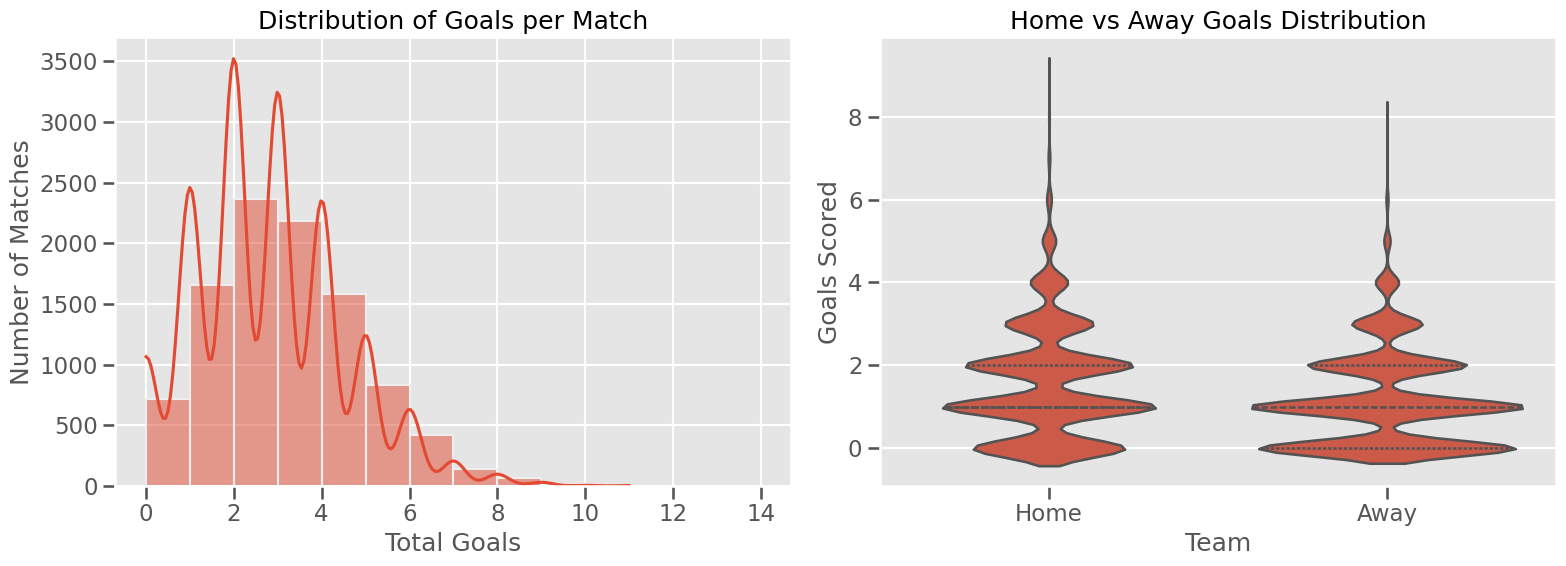

Average goals per match: 2.78
Home goals average: 1.59
Away goals average: 1.19
Home advantage: 0.40 goals


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)

def show_goals_distribution():
    """Show simple goals distribution visualization"""
    # Get goals data
    goals_data = pd.read_sql("""
        SELECT 
            f.score_home,
            f.score_away,
            (f.score_home + f.score_away) as total_goals
        FROM fixtures f
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        LIMIT 10000
    """, conn)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Total goals distribution
    sns.histplot(goals_data['total_goals'], bins=range(0, 15), kde=True, ax=ax1)
    ax1.set_title('Distribution of Goals per Match')
    ax1.set_xlabel('Total Goals')
    ax1.set_ylabel('Number of Matches')
    
    # 2. Home vs Away goals comparison
    home_away_df = pd.melt(goals_data[['score_home', 'score_away']], 
                          value_vars=['score_home', 'score_away'],
                          var_name='Team', value_name='Goals')
    home_away_df['Team'] = home_away_df['Team'].map({'score_home': 'Home', 'score_away': 'Away'})
    sns.violinplot(x='Team', y='Goals', data=home_away_df, inner='quartile', ax=ax2)
    ax2.set_title('Home vs Away Goals Distribution')
    ax2.set_ylabel('Goals Scored')
    
    plt.tight_layout()
    plt.show()
    
    # Print some stats
    print(f"Average goals per match: {goals_data['total_goals'].mean():.2f}")
    print(f"Home goals average: {goals_data['score_home'].mean():.2f}")
    print(f"Away goals average: {goals_data['score_away'].mean():.2f}")
    print(f"Home advantage: {goals_data['score_home'].mean() - goals_data['score_away'].mean():.2f} goals")

# Run the function to see immediate results
show_goals_distribution()

Running league goals analysis...


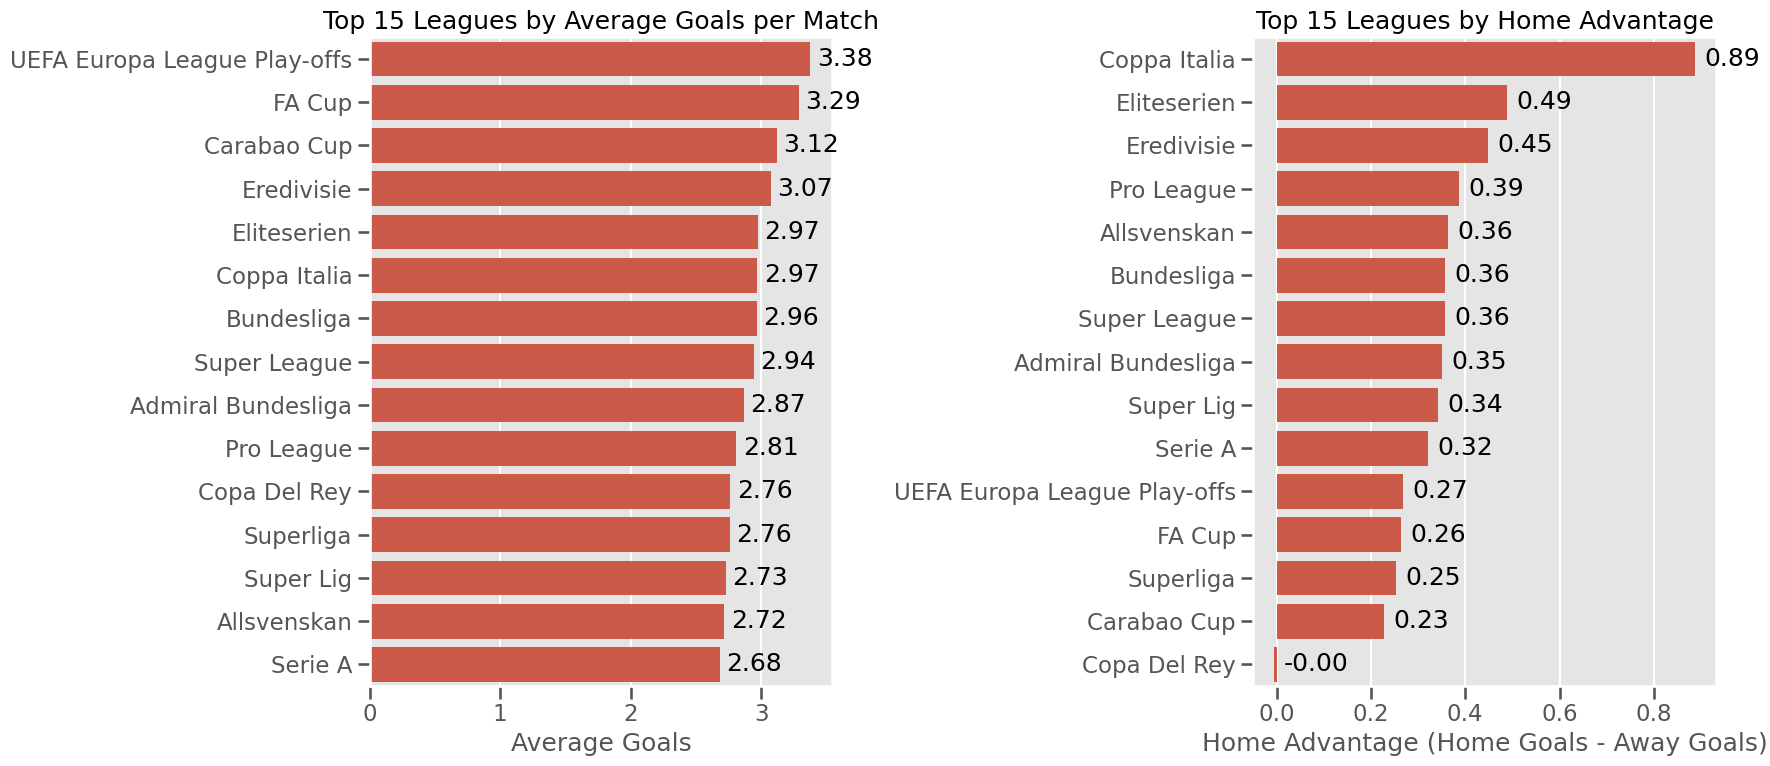

Overall Averages (across all leagues with at least 100 matches):
Average goals per match: 2.93
Average home goals: 1.64
Average away goals: 1.29
Average home advantage: 0.35 goals


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)

def analyze_goals_by_league(top_n=10):
    """Analyze goals by league"""
    # Get league-level data
    league_data = pd.read_sql(f"""
        SELECT 
            l.name as league_name,
            COUNT(f.id) as match_count,
            AVG(f.score_home + f.score_away) as avg_goals,
            AVG(f.score_home) as avg_home_goals,
            AVG(f.score_away) as avg_away_goals,
            AVG(f.score_home) - AVG(f.score_away) as home_advantage
        FROM leagues l
        JOIN fixtures f ON l.id = f.league_id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        GROUP BY l.name
        HAVING match_count >= 100
        ORDER BY avg_goals DESC
        LIMIT {top_n}
    """, conn)
    
    # Create the visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Average goals by league
    sns.barplot(y='league_name', x='avg_goals', data=league_data, ax=ax1)
    ax1.set_title(f'Top {top_n} Leagues by Average Goals per Match')
    ax1.set_xlabel('Average Goals')
    ax1.set_ylabel('')
    
    # Add value labels
    for i, row in enumerate(league_data.itertuples()):
        ax1.text(row.avg_goals + 0.05, i, f'{row.avg_goals:.2f}', va='center')
    
    # 2. Home advantage by league
    home_adv_data = league_data.sort_values('home_advantage', ascending=False)
    sns.barplot(y='league_name', x='home_advantage', data=home_adv_data, ax=ax2)
    ax2.set_title(f'Top {top_n} Leagues by Home Advantage')
    ax2.set_xlabel('Home Advantage (Home Goals - Away Goals)')
    ax2.set_ylabel('')
    
    # Add value labels
    for i, row in enumerate(home_adv_data.itertuples()):
        ax2.text(row.home_advantage + 0.02, i, f'{row.home_advantage:.2f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print overall stats
    print(f"Overall Averages (across all leagues with at least 100 matches):")
    print(f"Average goals per match: {league_data['avg_goals'].mean():.2f}")
    print(f"Average home goals: {league_data['avg_home_goals'].mean():.2f}")
    print(f"Average away goals: {league_data['avg_away_goals'].mean():.2f}")
    print(f"Average home advantage: {league_data['home_advantage'].mean():.2f} goals")

def analyze_team_performance(league_id=None, season_id=None, limit=20):
    """Analyze team performance with optional league and season filters"""
    # Build filter condition
    conditions = ["f.score_home IS NOT NULL AND f.score_away IS NOT NULL"]
    
    if league_id:
        conditions.append(f"f.league_id = {league_id}")
    
    if season_id:
        conditions.append(f"f.season_id = {season_id}")
    
    filter_condition = " AND ".join(conditions)
    
    # Get league name if provided
    league_name = "All Leagues"
    if league_id:
        league_query = f"SELECT name FROM leagues WHERE id = {league_id}"
        league_result = pd.read_sql(league_query, conn)
        if not league_result.empty:
            league_name = league_result.iloc[0, 0]
    
    # Get season name if provided
    season_name = "All Seasons"
    if season_id:
        season_query = f"SELECT name FROM seasons WHERE id = {season_id}"
        season_result = pd.read_sql(season_query, conn)
        if not season_result.empty:
            season_name = season_result.iloc[0, 0]
    
    # Get team data
    team_data = pd.read_sql(f"""
        SELECT 
            t.name as team_name,
            COUNT(DISTINCT f.id) as matches,
            SUM(CASE 
                WHEN (f.home_team_id = t.id AND f.score_home > f.score_away) OR 
                     (f.away_team_id = t.id AND f.score_away > f.score_home) THEN 1
                ELSE 0
            END) as wins,
            SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) as draws,
            SUM(CASE 
                WHEN (f.home_team_id = t.id AND f.score_home < f.score_away) OR 
                     (f.away_team_id = t.id AND f.score_away < f.score_home) THEN 1
                ELSE 0
            END) as losses,
            SUM(CASE 
                WHEN f.home_team_id = t.id THEN f.score_home
                ELSE f.score_away
            END) as goals_for,
            SUM(CASE 
                WHEN f.home_team_id = t.id THEN f.score_away
                ELSE f.score_home
            END) as goals_against
        FROM teams t
        JOIN fixtures f ON t.id = f.home_team_id OR t.id = f.away_team_id
        WHERE {filter_condition}
        GROUP BY t.name
        HAVING matches >= 10
        ORDER BY (wins * 3 + draws) / matches DESC
        LIMIT {limit}
    """, conn)
    
    # Calculate additional metrics
    team_data['points'] = team_data['wins'] * 3 + team_data['draws']
    team_data['points_per_game'] = team_data['points'] / team_data['matches']
    team_data['win_percentage'] = team_data['wins'] / team_data['matches'] * 100
    team_data['goals_per_game'] = team_data['goals_for'] / team_data['matches']
    team_data['goals_against_per_game'] = team_data['goals_against'] / team_data['matches']
    team_data['goal_difference'] = team_data['goals_for'] - team_data['goals_against']
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Top teams by win percentage
    top_teams = team_data.sort_values('win_percentage', ascending=False).head(10)
    sns.barplot(y='team_name', x='win_percentage', data=top_teams, ax=ax1)
    ax1.set_title(f'Top 10 Teams by Win Percentage ({league_name}, {season_name})')
    ax1.set_xlabel('Win Percentage (%)')
    ax1.set_ylabel('')
    
    # Add value labels
    for i, row in enumerate(top_teams.itertuples()):
        ax1.text(row.win_percentage + 1, i, f'{row.win_percentage:.1f}%', va='center')
    
    # 2. Points vs Goals
    ax2.scatter(
        team_data['goals_per_game'], 
        team_data['points_per_game'],
        c=team_data['goals_against_per_game'],
        s=team_data['matches']*2,
        alpha=0.7,
        cmap='coolwarm_r'
    )
    
    # Add colorbar
    cbar = plt.colorbar(ax2.collections[0], ax=ax2)
    cbar.set_label('Goals Conceded per Game')
    
    # Annotate top teams
    for i, row in team_data.nlargest(5, 'points_per_game').iterrows():
        ax2.annotate(
            row['team_name'], 
            (row['goals_per_game'], row['points_per_game']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8
        )
    
    ax2.set_title(f'Team Performance: Points vs. Goals ({league_name}, {season_name})')
    ax2.set_xlabel('Goals per Game')
    ax2.set_ylabel('Points per Game')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display top team table
    print(f"Top 10 Teams ({league_name}, {season_name}):")
    display_cols = ['team_name', 'matches', 'wins', 'draws', 'losses', 
                   'goals_for', 'goals_against', 'goal_difference', 'points', 'points_per_game']
    print(team_data[display_cols].head(10).to_string(index=False))

# Get available leagues for reference
def list_top_leagues(limit=20):
    """List top leagues by match count"""
    leagues = pd.read_sql("""
        SELECT 
            l.id, 
            l.name, 
            COUNT(f.id) as match_count
        FROM leagues l
        JOIN fixtures f ON l.id = f.league_id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        GROUP BY l.id, l.name
        ORDER BY match_count DESC
        LIMIT 20
    """, conn)
    
    print("Top leagues by match count:")
    print(leagues.to_string(index=False))
    return leagues

# Get available seasons for reference
def list_seasons(limit=10):
    """List seasons with match count"""
    seasons = pd.read_sql("""
        SELECT 
            s.id, 
            s.name, 
            COUNT(f.id) as match_count
        FROM seasons s
        JOIN fixtures f ON s.id = f.season_id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        GROUP BY s.id, s.name
        ORDER BY match_count DESC
        LIMIT 10
    """, conn)
    
    print("Top seasons by match count:")
    print(seasons.to_string(index=False))
    return seasons

# Example usage:
print("Running league goals analysis...")
analyze_goals_by_league(15)

# Uncomment these lines to run other analyses:
# list_top_leagues()
# list_seasons()
# analyze_team_performance(league_id=8, season_id=17141)  # Example: Premier League 2020/2021

1. Home Advantage Analysis


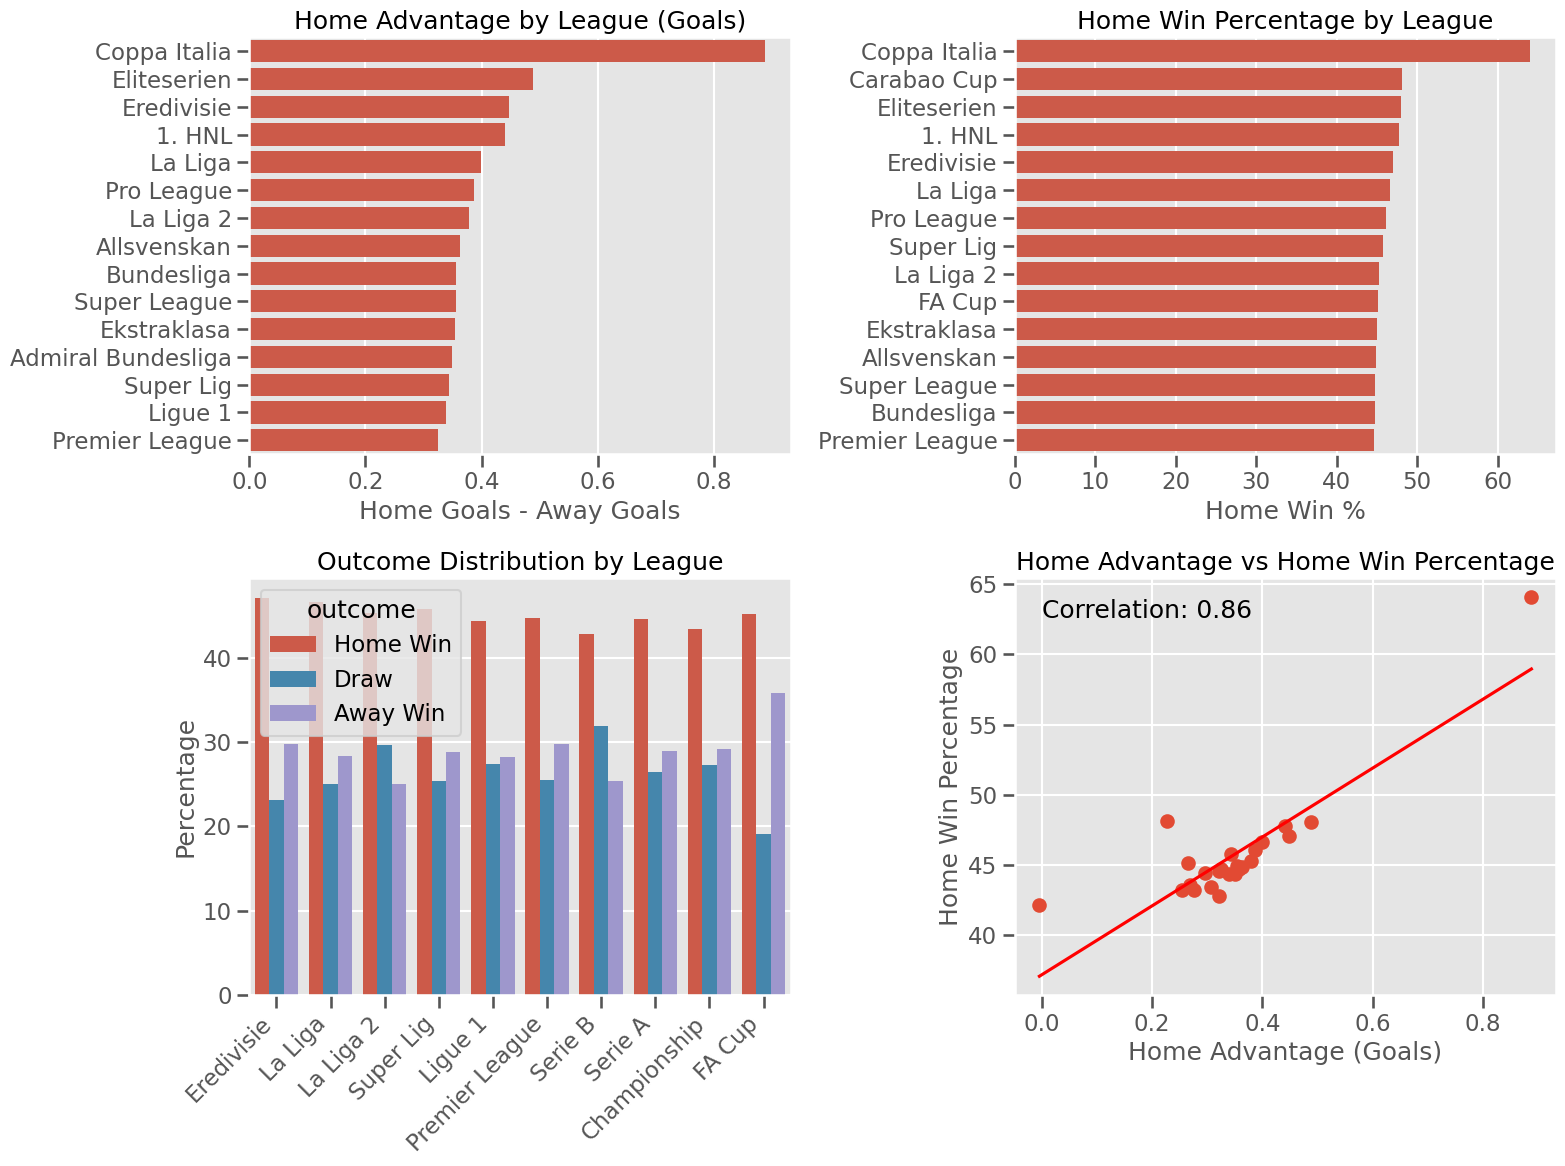

Home Advantage Summary Statistics:
Average Home Goals: 1.56
Average Away Goals: 1.21
Average Home Advantage: 0.35 goals
Average Home Win Rate: 45.8%
Average Draw Rate: 24.1%
Average Away Win Rate: 30.2%

2. Team Form Impact Analysis
Analyzing form impact using last 3 matches for Premier League...


/var/folders/nl/dl4x3l3x1dd8twj43d1ddkx80000gn/T/ipykernel_28077/2215099190.py:255: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  form_impact = form_df.groupby('form_diff_range')['result'].apply(


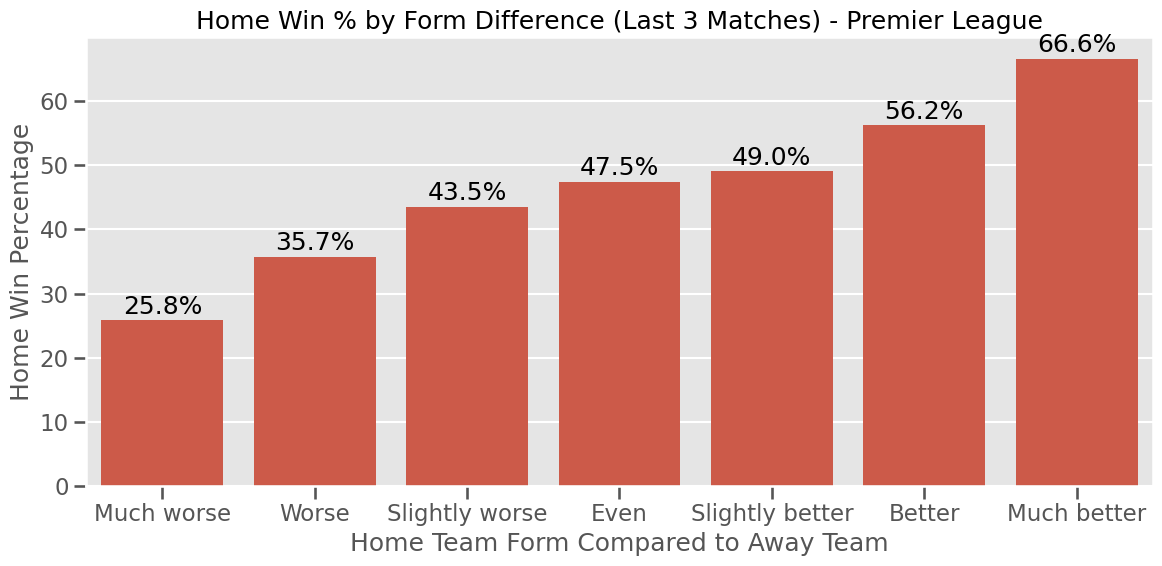

Correlation between form difference and home win: 0.1942

Form Impact Analysis:
When home team form is Much worse than away team: 25.8% home win rate (n=585)
When home team form is Worse than away team: 35.7% home win rate (n=1875)
When home team form is Slightly worse than away team: 43.5% home win rate (n=1817)
When home team form is Even than away team: 47.5% home win rate (n=1220)
When home team form is Slightly better than away team: 49.0% home win rate (n=1680)
When home team form is Better than away team: 56.2% home win rate (n=1645)
When home team form is Much better than away team: 66.6% home win rate (n=500)

3. Over/Under Goal Patterns


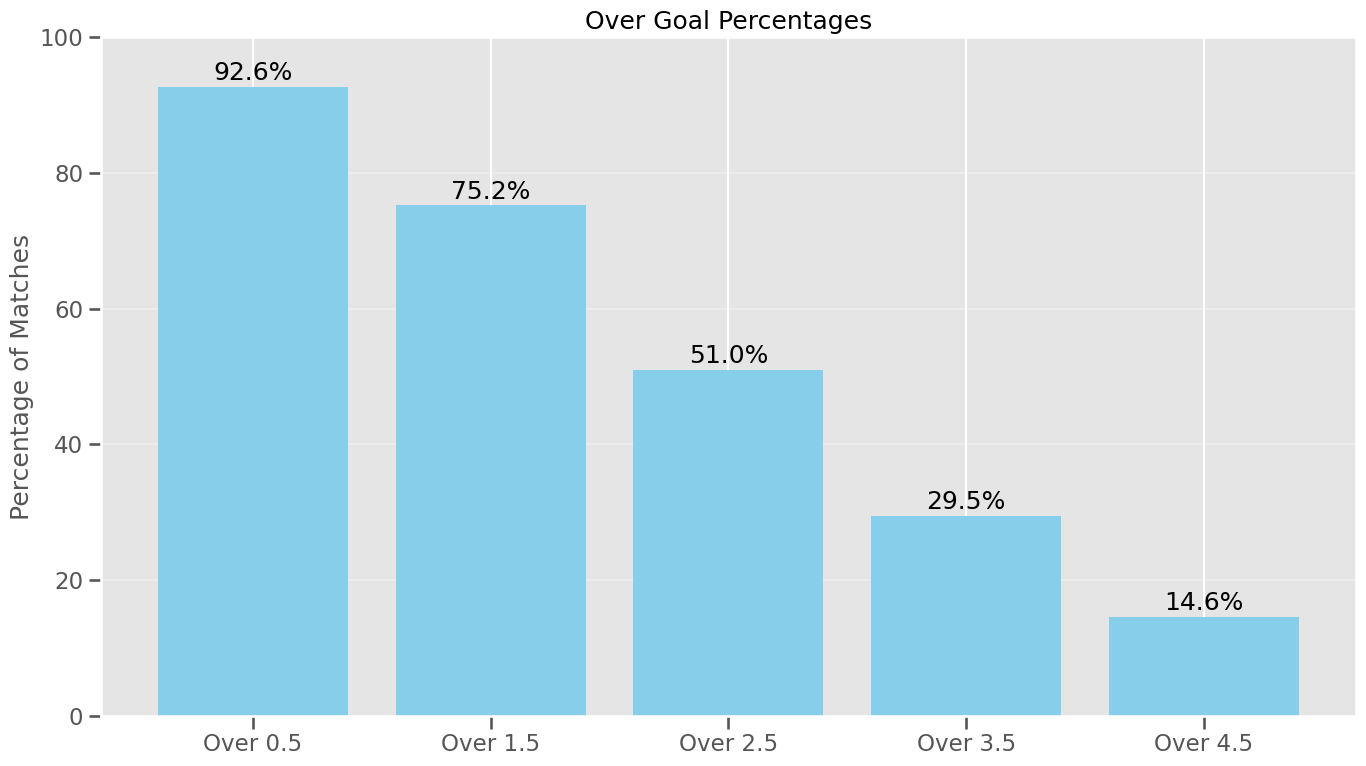

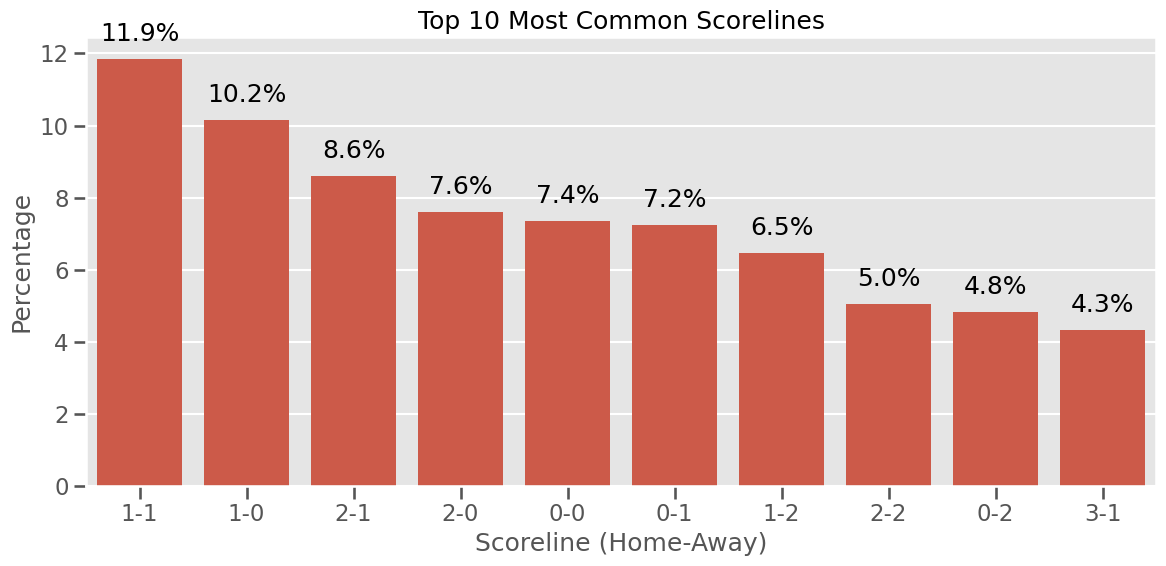

Goal Pattern Analysis:
Average Goals per Match: 2.72
Both Teams To Score (BTTS): 52.1%

Over/Under Statistics:
Over 0.5: 92.6%
Over 1.5: 75.2%
Over 2.5: 51.0%
Over 3.5: 29.5%
Over 4.5: 14.6%

Most Common Scorelines:
1-1: 11.9%
1-0: 10.2%
2-1: 8.6%
2-0: 7.6%
0-0: 7.4%


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)

def analyze_home_advantage(league_id=None, season_id=None):
    """Analyze home advantage as a prediction parameter"""
    # Build filter condition
    conditions = ["f.score_home IS NOT NULL AND f.score_away IS NOT NULL"]
    
    if league_id:
        conditions.append(f"f.league_id = {league_id}")
    
    if season_id:
        conditions.append(f"f.season_id = {season_id}")
    
    filter_condition = " AND ".join(conditions)
    
    # Get data for analysis
    home_advantage_data = pd.read_sql(f"""
        SELECT 
            l.name as league_name,
            COUNT(*) as matches,
            AVG(f.score_home) as avg_home_goals,
            AVG(f.score_away) as avg_away_goals,
            AVG(f.score_home) - AVG(f.score_away) as home_advantage,
            (SUM(CASE WHEN f.score_home > f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as home_win_pct,
            (SUM(CASE WHEN f.score_home = f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as draw_pct,
            (SUM(CASE WHEN f.score_home < f.score_away THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as away_win_pct
        FROM fixtures f
        JOIN leagues l ON f.league_id = l.id
        WHERE {filter_condition}
        GROUP BY l.name
        HAVING matches >= 20
        ORDER BY home_advantage DESC
    """, conn)
    
    # Create visualizations
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Home advantage by league
    top_home_adv = home_advantage_data.sort_values('home_advantage', ascending=False).head(15)
    sns.barplot(y='league_name', x='home_advantage', data=top_home_adv, ax=axs[0, 0])
    axs[0, 0].set_title('Home Advantage by League (Goals)')
    axs[0, 0].set_xlabel('Home Goals - Away Goals')
    axs[0, 0].set_ylabel('')
    
    # 2. Home win percentage by league
    top_home_win = home_advantage_data.sort_values('home_win_pct', ascending=False).head(15)
    sns.barplot(y='league_name', x='home_win_pct', data=top_home_win, ax=axs[0, 1])
    axs[0, 1].set_title('Home Win Percentage by League')
    axs[0, 1].set_xlabel('Home Win %')
    axs[0, 1].set_ylabel('')
    
    # 3. Outcome distribution
    outcomes_melted = pd.melt(home_advantage_data, 
                              id_vars=['league_name'], 
                              value_vars=['home_win_pct', 'draw_pct', 'away_win_pct'],
                              var_name='outcome', value_name='percentage')
    outcomes_melted['outcome'] = outcomes_melted['outcome'].map({
        'home_win_pct': 'Home Win',
        'draw_pct': 'Draw',
        'away_win_pct': 'Away Win'
    })
    
    top_leagues = home_advantage_data.sort_values('matches', ascending=False).head(10)['league_name']
    top_outcomes = outcomes_melted[outcomes_melted['league_name'].isin(top_leagues)]
    
    sns.barplot(x='league_name', y='percentage', hue='outcome', data=top_outcomes, ax=axs[1, 0])
    axs[1, 0].set_title('Outcome Distribution by League')
    axs[1, 0].set_xlabel('')
    axs[1, 0].set_ylabel('Percentage')
    plt.setp(axs[1, 0].get_xticklabels(), rotation=45, ha='right')
    
    # 4. Home advantage correlation with home win percentage
    axs[1, 1].scatter(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'])
    axs[1, 1].set_title('Home Advantage vs Home Win Percentage')
    axs[1, 1].set_xlabel('Home Advantage (Goals)')
    axs[1, 1].set_ylabel('Home Win Percentage')
    
    # Add regression line
    m, b = np.polyfit(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'], 1)
    axs[1, 1].plot(home_advantage_data['home_advantage'], m*home_advantage_data['home_advantage'] + b, color='red')
    
    # Calculate correlation
    correlation = np.corrcoef(home_advantage_data['home_advantage'], home_advantage_data['home_win_pct'])[0, 1]
    axs[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=axs[1, 1].transAxes,
                verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Home Advantage Summary Statistics:")
    print(f"Average Home Goals: {home_advantage_data['avg_home_goals'].mean():.2f}")
    print(f"Average Away Goals: {home_advantage_data['avg_away_goals'].mean():.2f}")
    print(f"Average Home Advantage: {home_advantage_data['home_advantage'].mean():.2f} goals")
    print(f"Average Home Win Rate: {home_advantage_data['home_win_pct'].mean():.1f}%")
    print(f"Average Draw Rate: {home_advantage_data['draw_pct'].mean():.1f}%")
    print(f"Average Away Win Rate: {home_advantage_data['away_win_pct'].mean():.1f}%")
    
    # Return data for further analysis if needed
    return home_advantage_data

def analyze_team_form_impact(league_id=None, min_matches=5):
    """Analyze how team form impacts match results"""
    # Build filter condition
    filter_condition = "f.score_home IS NOT NULL AND f.score_away IS NOT NULL"
    
    if league_id:
        filter_condition += f" AND f.league_id = {league_id}"
    
    # Get league name if provided
    league_name = "All Leagues"
    if league_id:
        league_query = f"SELECT name FROM leagues WHERE id = {league_id}"
        league_result = pd.read_sql(league_query, conn)
        if not league_result.empty:
            league_name = league_result.iloc[0, 0]
    
    # Get match results for analysis
    matches = pd.read_sql(f"""
        SELECT 
            f.id as fixture_id,
            f.home_team_id,
            f.away_team_id,
            f.score_home,
            f.score_away,
            f.starting_at,
            ht.name as home_team_name,
            at.name as away_team_name,
            CASE 
                WHEN f.score_home > f.score_away THEN 'H'
                WHEN f.score_home = f.score_away THEN 'D'
                ELSE 'A'
            END as result
        FROM fixtures f
        JOIN teams ht ON f.home_team_id = ht.id
        JOIN teams at ON f.away_team_id = at.id
        WHERE {filter_condition}
        ORDER BY f.starting_at
    """, conn)
    
    # Convert date
    matches['starting_at'] = pd.to_datetime(matches['starting_at'])
    
    # For demonstration, analyze last 3 match form
    form_length = 3
    print(f"Analyzing form impact using last {form_length} matches for {league_name}...")
    
    # For each home team, calculate form (previous n matches)
    results = []
    
    for _, match in matches.iterrows():
        # Get previous home team results
        home_team_id = match['home_team_id']
        match_date = match['starting_at']
        
        # Find previous matches for this home team
        prev_home_matches = matches[
            ((matches['home_team_id'] == home_team_id) | (matches['away_team_id'] == home_team_id)) & 
            (matches['starting_at'] < match_date)
        ].sort_values('starting_at', ascending=False).head(form_length)
        
        # If we don't have enough previous matches, skip
        if len(prev_home_matches) < form_length:
            continue
        
        # Calculate form points (W=3, D=1, L=0)
        home_form_points = 0
        for _, prev_match in prev_home_matches.iterrows():
            if prev_match['home_team_id'] == home_team_id:
                if prev_match['result'] == 'H':
                    home_form_points += 3
                elif prev_match['result'] == 'D':
                    home_form_points += 1
            else:  # away team
                if prev_match['result'] == 'A':
                    home_form_points += 3
                elif prev_match['result'] == 'D':
                    home_form_points += 1
        
        # Calculate form percentage
        home_form_pct = home_form_points / (form_length * 3) * 100
        
        # Do the same for away team
        away_team_id = match['away_team_id']
        
        # Find previous matches for this away team
        prev_away_matches = matches[
            ((matches['home_team_id'] == away_team_id) | (matches['away_team_id'] == away_team_id)) & 
            (matches['starting_at'] < match_date)
        ].sort_values('starting_at', ascending=False).head(form_length)
        
        # If we don't have enough previous matches, skip
        if len(prev_away_matches) < form_length:
            continue
        
        # Calculate form points (W=3, D=1, L=0)
        away_form_points = 0
        for _, prev_match in prev_away_matches.iterrows():
            if prev_match['home_team_id'] == away_team_id:
                if prev_match['result'] == 'H':
                    away_form_points += 3
                elif prev_match['result'] == 'D':
                    away_form_points += 1
            else:  # away team
                if prev_match['result'] == 'A':
                    away_form_points += 3
                elif prev_match['result'] == 'D':
                    away_form_points += 1
        
        # Calculate form percentage
        away_form_pct = away_form_points / (form_length * 3) * 100
        
        # Calculate form difference
        form_diff = home_form_pct - away_form_pct
        
        # Record the results
        results.append({
            'fixture_id': match['fixture_id'],
            'home_team': match['home_team_name'],
            'away_team': match['away_team_name'],
            'result': match['result'],
            'home_form_pct': home_form_pct,
            'away_form_pct': away_form_pct,
            'form_diff': form_diff
        })
    
    # Convert to dataframe
    form_df = pd.DataFrame(results)
    
    if form_df.empty:
        print("Not enough data for form analysis. Try using a larger dataset.")
        return None
    
    # Group form into ranges
    form_df['form_diff_range'] = pd.cut(
        form_df['form_diff'], 
        bins=[-100, -60, -30, -10, 10, 30, 60, 100],
        labels=['Much worse', 'Worse', 'Slightly worse', 'Even', 'Slightly better', 'Better', 'Much better']
    )
    
    # Calculate home win percentage by form difference
    form_impact = form_df.groupby('form_diff_range')['result'].apply(
        lambda x: (x == 'H').mean() * 100
    ).reset_index(name='home_win_pct')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='form_diff_range', y='home_win_pct', data=form_impact)
    plt.title(f'Home Win % by Form Difference (Last {form_length} Matches) - {league_name}')
    plt.xlabel('Home Team Form Compared to Away Team')
    plt.ylabel('Home Win Percentage')
    
    # Add labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                   (p.get_x() + p.get_width()/2., p.get_height() + 1),
                   ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation between form difference and results
    # Convert result to numeric (1 for home win, 0 otherwise)
    form_df['home_win'] = (form_df['result'] == 'H').astype(int)
    correlation = np.corrcoef(form_df['form_diff'], form_df['home_win'])[0, 1]
    
    print(f"Correlation between form difference and home win: {correlation:.4f}")
    print("\nForm Impact Analysis:")
    for _, row in form_impact.iterrows():
        count = len(form_df[form_df['form_diff_range'] == row['form_diff_range']])
        print(f"When home team form is {row['form_diff_range']} than away team: {row['home_win_pct']:.1f}% home win rate (n={count})")
    
    # Return data for further analysis
    return form_df

def analyze_over_under_patterns(limit=10000):
    """Analyze over/under goal patterns"""
    # Get goals data
    goals_data = pd.read_sql(f"""
        SELECT 
            f.id as fixture_id,
            f.score_home,
            f.score_away,
            (f.score_home + f.score_away) as total_goals,
            l.name as league_name
        FROM fixtures f
        JOIN leagues l ON f.league_id = l.id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
        ORDER BY RANDOM()
        LIMIT {limit}
    """, conn)
    
    # Define thresholds for over/under analysis
    thresholds = [0.5, 1.5, 2.5, 3.5, 4.5]
    
    # Create figure
    plt.figure(figsize=(14, 8))
    
    # Calculate and plot over/under percentages
    over_percentages = []
    labels = []
    
    for threshold in thresholds:
        over_count = sum(goals_data['total_goals'] > threshold)
        over_pct = over_count / len(goals_data) * 100
        over_percentages.append(over_pct)
        labels.append(f'Over {threshold}')
    
    # Create bar chart
    bars = plt.bar(labels, over_percentages, color='skyblue')
    
    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center')
    
    plt.title('Over Goal Percentages')
    plt.ylabel('Percentage of Matches')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze BTTS (Both Teams To Score)
    btts_count = sum((goals_data['score_home'] > 0) & (goals_data['score_away'] > 0))
    btts_pct = btts_count / len(goals_data) * 100
    
    # Most common scorelines
    scorelines = goals_data.groupby(['score_home', 'score_away']).size().reset_index(name='count')
    scorelines['scoreline'] = scorelines['score_home'].astype(str) + '-' + scorelines['score_away'].astype(str)
    scorelines['percentage'] = scorelines['count'] / len(goals_data) * 100
    top_scorelines = scorelines.sort_values('count', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='scoreline', y='percentage', data=top_scorelines)
    plt.title('Top 10 Most Common Scorelines')
    plt.xlabel('Scoreline (Home-Away)')
    plt.ylabel('Percentage')
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%', 
                   (p.get_x() + p.get_width()/2., p.get_height() + 0.5),
                   ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Goal Pattern Analysis:")
    print(f"Average Goals per Match: {goals_data['total_goals'].mean():.2f}")
    print(f"Both Teams To Score (BTTS): {btts_pct:.1f}%")
    
    # Print over/under percentages
    print("\nOver/Under Statistics:")
    for threshold in thresholds:
        over_pct = sum(goals_data['total_goals'] > threshold) / len(goals_data) * 100
        print(f"Over {threshold}: {over_pct:.1f}%")
    
    print("\nMost Common Scorelines:")
    for _, row in top_scorelines.head(5).iterrows():
        print(f"{row['scoreline']}: {row['percentage']:.1f}%")
    
    return goals_data

# Run the analyses
print("1. Home Advantage Analysis")
home_adv_data = analyze_home_advantage()

print("\n2. Team Form Impact Analysis")
form_data = analyze_team_form_impact(league_id=8)  # Premier League

print("\n3. Over/Under Goal Patterns")
goals_data = analyze_over_under_patterns(20000)